In [11]:
# Boilerplate from Randy cheatsheet at https://docs.google.com/document/d/1utZuLHcKQEZNXTQLOysTNCxTHrqxczAUymmtplpn27Q/edit#
import pandas as pd
import geopandas as gpd
import numpy as np
from geopandas import GeoSeries, GeoDataFrame
import re
%matplotlib inline
pd.set_option('display.max_columns', 500)

# Wide display
from IPython.core.display import display, HTML
display(HTML("<style>#notebook-container { margin-left:-14px; width:calc(100% + 27px) !important; }</style>"))

In [112]:
import pandas as pd
import csv, json, os, math, numbers, pandas, re, scipy, scipy.sparse, shutil
import struct, subprocess, sys, threading, time, urllib2
import sqlite3, thread, urllib

def exec_ipynb(filename_or_url):
    nb = (urllib2.urlopen(filename_or_url) if re.match(r'https?:', filename_or_url) else open(filename_or_url)).read()
    jsonNb = json.loads(nb)
    #check for the modified formatting of Jupyter Notebook v4
    if(jsonNb['nbformat'] == 4):
        exec '\n'.join([''.join(cell['source']) for cell in jsonNb['cells'] if cell['cell_type'] == 'code']) in globals()
    else:
        exec '\n'.join([''.join(cell['input']) for cell in jsonNb['worksheets'][0]['cells'] if cell['cell_type'] == 'code']) in globals()

exec_ipynb('timelapse-utilities.ipynb')

In [13]:
def get_segments_from_ring(r):
    ret = set()
    for i in range(0, len(r)):
        ret.add((r[i - 1][0], r[i - 1][1], r[i][0], r[i][1]))
    return ret

def get_segments_from_polygon(p):
    return set.union(*[get_segments_from_ring(r) for r in p])

def get_segments_from_multipolygon(mp):
    return set.union(*[get_segments_from_polygon(p) for p in mp])

def get_segments(g):
    if 'features' in g:
        return set.union(*[get_segments(f) for f in g['features']])
    elif 'geometry' in g:
        if g['geometry']['type'] == 'Polygon':
            return get_segments_from_polygon(g['geometry']['coordinates'])
        elif g['geometry']['type'] == 'MultiPolygon':
            return get_segments_from_multipolygon(g['geometry']['coordinates'])
        else:
            raise Exception('unrecognized geometry type %s' % g['geometry']['type'])
    else:
        raise 'unrecognized type'
        
def LonLatToWebMercator(lon, lat):
    x = (lon + 180.0) * 256.0 / 360.0
    y = 128.0 - math.log(math.tan((lat + 90.0) * math.pi / 360.0)) * 128.0 / math.pi
    return [x, y]

def WebMercatorToLonLat(x,y):
    lat = math.atan(math.exp((128.0 - y) * math.pi / 128.0)) * 360.0 / math.pi - 90.0
    lon = x * 360.0 / 256.0 - 180.0
    return [lon, lat]

def project_and_binarize_segment(segment, dest):
    (x1, y1) = LonLatToWebMercator(segment[0], segment[1])
    (x2, y2) = LonLatToWebMercator(segment[2], segment[3])
    dest.write(struct.pack('<ffff', x1, y1, x2, y2))

def binarize_geojson_outlines(src, dest):
    gj = json.load(open(src))
    print 'Read %d features from %s' % (len(gj['features']), src)
    segments = get_segments(gj)
    print '%d segments' % len(segments)

    try:
        os.makedirs(os.path.dirname(dest))
    except OSError:
        pass
        
    out = open(dest + '.tmp', 'w')
    for segment in segments:
        project_and_binarize_segment(segment, out)
    out.close()
    os.rename(dest + '.tmp', dest)
    print 'Created %s (%d segments)' % (dest, os.stat(dest).st_size / 16)
        

In [14]:
pandas.options.display.max_colwidth = 300
pandas.set_option('display.max_columns', 500)

# Read in 2018 US House boundaries

In [11]:
ush_2018 = gpd.read_file('voting/Remedial Plan Shapefile.shp').to_crs(epsg=4326)

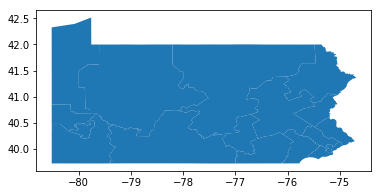

In [12]:
ush_2018.plot()

In [13]:
ush_2018

,ID,AREA,DISTRICT,MEMBERS,LOCKED,NAME,POPULATION,F18_POP,F18_AP_BLK,NH18_WHT,IDEAL_VALU,DEVIATION,F_DEVIATIO,F_18_AP_BL,F_NH18_WHT,geometry
0,1,655.201721,01,1.0,None,None,705687,543412,20074,474616,705688.0,-1.0,-0.000001,0.036941,0.873400,"POLYGON ((-75.48405700000001 40.418451, -75.479192 40.422939, -75.479049 40.423073, -75.475499 40.426399, -75.473145 40.428563, -75.472915 40.428775, -75.471053 40.430488, -75.471035 40.430503, -75.470972 40.430561, -75.469026 40.432359, -75.467159 40.434264, -75.46715 40.434274, -75.467108 40.4..."
1,2,65.945671,02,1.0,None,None,705688,526334,135399,258603,705688.0,0.0,0.000000,0.257249,0.491329,"POLYGON ((-74.980688 40.065007, -74.98070199999999 40.064878, -74.980706 40.064838, -74.980718 40.06472, -74.98073100000001 40.064592, -74.98081000000001 40.064389, -74.98090500000001 40.064269, -74.981022 40.063818, -74.981139 40.063683, -74.98114 40.063368, -74.98090500000001 40.06300700000001..."
2,3,54.538364,03,1.0,None,None,705688,568892,326217,187806,705688.0,0.0,0.000000,0.573425,0.330126,"POLYGON ((-75.206968 40.011372, -75.206914 40.011416, -75.20687100000001 40.01144800000001, -75.20679199999999 40.011512, -75.20628600000001 40.01192300000001, -75.206405 40.012002, -75.207599 40.012719, -75.207628 40.012736, -75.207728 40.012805, -75.20800800000001 40.012997, -75.20864899999999..."
3,4,480.801880,04,1.0,None,None,705687,543711,49311,443923,705688.0,-1.0,-0.000001,0.090693,0.816469,"POLYGON ((-75.48405700000001 40.418451, -75.48292499999999 40.417938, -75.48288700000001 40.417923, -75.482485 40.417686, -75.480785 40.416685, -75.47984099999999 40.41613, -75.477323 40.414648, -75.47653 40.414181, -75.474388 40.41297900000001, -75.47425800000001 40.412907, -75.47126 40.41114, ..."
4,5,221.704346,05,1.0,None,None,705688,541035,116060,377905,705688.0,0.0,0.000000,0.214515,0.698485,"POLYGON ((-75.502135 39.954367, -75.501051 39.954861, -75.499427 39.95560300000001, -75.49780199999999 39.956345, -75.496765 39.956819, -75.496719 39.95684, -75.495532 39.957382, -75.49434599999999 39.957924, -75.4939 39.958128, -75.49374299999999 39.958195, -75.493617 39.958253, -75.492351 39.9..."
5,6,922.566833,06,1.0,None,None,705688,528267,36673,420028,705688.0,0.0,0.000000,0.069421,0.795106,"POLYGON ((-75.46172900000001 40.103035, -75.461809 40.10247400000001, -75.461798 40.102346, -75.461795 40.102324, -75.461789 40.102255, -75.461788 40.102059, -75.46183000000001 40.101769, -75.461995 40.101498, -75.462361 40.101105, -75.462475 40.10095700000001, -75.46263 40.100578, -75.462637000..."
6,7,867.563293,07,1.0,None,None,705688,545100,32094,435449,705688.0,0.0,0.000000,0.058877,0.798842,"POLYGON ((-75.196803 40.60858, -75.19714999999999 40.60841600000001, -75.197287 40.608351, -75.19743200000001 40.60828300000001, -75.19759500000001 40.608205, -75.197654 40.608177, -75.197755 40.608129, -75.197802 40.60811200000001, -75.19782499999999 40.608103, -75.198019 40.608016, -75.198635 ..."
7,8,1117.711420,10,1.0,None,None,705688,545746,56209,446632,705688.0,0.0,0.000000,0.102995,0.818388,"POLYGON ((-76.701624 40.658082, -76.701566 40.658048, -76.70150700000001 40.658014, -76.70093300000001 40.65768, -76.698863 40.656477, -76.698173 40.656076, -76.696916 40.655321, -76.693145 40.653057, -76.691889 40.652303, -76.691603 40.652118, -76.69074600000002 40.651565, -76.69056 40.651445, ..."
8,9,1545.007080,11,1.0,None,None,705688,533533,18009,476409,705688.0,0.0,0.000000,0.033754,0.892933,"POLYGON ((-76.72162 40.12007, -76.721349 40.120606, -76.72094500000001 40.12141, -76.72054 40.122214, -76.720279 40.122734, -76.72027 40.122751, -76.720266 40.122757, -76.72025600000001 40.122778, -76.72025300000001 40.122785, -76.720139 40.123012, -76.72002500000001 40.123238, -76.7200200000000..."
9,10,9975.768550,12,1.0,None,None,705688,560669,12883,527131,705688.0,0.0,0.000000,0.022978,0.940182,"POLYGON ((-77.939424 40.775485, -77.93929 40.775576, -77.936916 40.777277, -77.93570200000001 40.778148, -77.927571 40.784001, -77.927249 40.7

In [14]:
# Create a GeoDataFrame that just has DISTRICT and geometry
ush_out_2018 = gpd.GeoDataFrame(ush_2018[['DISTRICT']], geometry=ush_2018.geometry,crs={'init': 'epsg:4326'})

In [15]:
ush_out_2018

,DISTRICT,geometry
0,01,"POLYGON ((-75.48405700000001 40.418451, -75.479192 40.422939, -75.479049 40.423073, -75.475499 40.426399, -75.473145 40.428563, -75.472915 40.428775, -75.471053 40.430488, -75.471035 40.430503, -75.470972 40.430561, -75.469026 40.432359, -75.467159 40.434264, -75.46715 40.434274, -75.467108 40.4..."
1,02,"POLYGON ((-74.980688 40.065007, -74.98070199999999 40.064878, -74.980706 40.064838, -74.980718 40.06472, -74.98073100000001 40.064592, -74.98081000000001 40.064389, -74.98090500000001 40.064269, -74.981022 40.063818, -74.981139 40.063683, -74.98114 40.063368, -74.98090500000001 40.06300700000001..."
2,03,"POLYGON ((-75.206968 40.011372, -75.206914 40.011416, -75.20687100000001 40.01144800000001, -75.20679199999999 40.011512, -75.20628600000001 40.01192300000001, -75.206405 40.012002, -75.207599 40.012719, -75.207628 40.012736, -75.207728 40.012805, -75.20800800000001 40.012997, -75.20864899999999..."
3,04,"POLYGON ((-75.48405700000001 40.418451, -75.48292499999999 40.417938, -75.48288700000001 40.417923, -75.482485 40.417686, -75.480785 40.416685, -75.47984099999999 40.41613, -75.477323 40.414648, -75.47653 40.414181, -75.474388 40.41297900000001, -75.47425800000001 40.412907, -75.47126 40.41114, ..."
4,05,"POLYGON ((-75.502135 39.954367, -75.501051 39.954861, -75.499427 39.95560300000001, -75.49780199999999 39.956345, -75.496765 39.956819, -75.496719 39.95684, -75.495532 39.957382, -75.49434599999999 39.957924, -75.4939 39.958128, -75.49374299999999 39.958195, -75.493617 39.958253, -75.492351 39.9..."
5,06,"POLYGON ((-75.46172900000001 40.103035, -75.461809 40.10247400000001, -75.461798 40.102346, -75.461795 40.102324, -75.461789 40.102255, -75.461788 40.102059, -75.46183000000001 40.101769, -75.461995 40.101498, -75.462361 40.101105, -75.462475 40.10095700000001, -75.46263 40.100578, -75.462637000..."
6,07,"POLYGON ((-75.196803 40.60858, -75.19714999999999 40.60841600000001, -75.197287 40.608351, -75.19743200000001 40.60828300000001, -75.19759500000001 40.608205, -75.197654 40.608177, -75.197755 40.608129, -75.197802 40.60811200000001, -75.19782499999999 40.608103, -75.198019 40.608016, -75.198635 ..."
7,10,"POLYGON ((-76.701624 40.658082, -76.701566 40.658048, -76.70150700000001 40.658014, -76.70093300000001 40.65768, -76.698863 40.656477, -76.698173 40.656076, -76.696916 40.655321, -76.693145 40.653057, -76.691889 40.652303, -76.691603 40.652118, -76.69074600000002 40.651565, -76.69056 40.651445, ..."
8,11,"POLYGON ((-76.72162 40.12007, -76.721349 40.120606, -76.72094500000001 40.12141, -76.72054 40.122214, -76.720279 40.122734, -76.72027 40.122751, -76.720266 40.122757, -76.72025600000001 40.122778, -76.72025300000001 40.122785, -76.720139 40.123012, -76.72002500000001 40.123238, -76.7200200000000..."
9,12,"POLYGON ((-77.939424 40.775485, -77.93929 40.775576, -77.936916 40.777277, -77.93570200000001 40.778148, -77.927571 40.784001, -77.927249 40.784218, -77.922938 40.787312, -77.921674 40.78822, -77.920844 40.788816, -77.920072 40.789364, -77.919318 40.7899, -77.917469 40.791233, -77.916546 40.7918..."


In [16]:
# Write out the 2018 US House geometry as a geojson file
ush_out_2018.to_file('voting/pa_us_house_boundaries_2018.geojson', driver="GeoJSON")

In [17]:
binarize_geojson_outlines('voting/pa_us_house_boundaries_2018.geojson', 
                          'voting/pa_us_house_boundaries_2018.bin')

Read 18 features from voting/pa_us_house_boundaries_2018.geojson
112242 segments
Created voting/pa_us_house_boundaries_2018.bin (112242 segments)


# Deal with voting file from county

In [2]:
# Key is string canonical address, value is a map: {'canonical_in_census_db': True/False,'canonical_in_google_db': True/False, 'other_addr_strings':Set, 'census_value':str, 'google_value':str
canonical_addr_map={}

In [3]:
def canonicalize_string(text):
    # Remove any leading or trailing whitespace, replace any internal whitespace with single spaces, upcase it all
    ret = re.sub("^\s+|\s+$", "", text)
    ret = re.sub("\s+", " ", ret)
    return ret.upper()

In [5]:
# Try to load canonical_addr_map originally created by 
#  http://localhost:8820/notebooks/projects/demographics/Fixup%20Address%20DB.ipynb
import pickle
pickle_file_path = 'assessments/canonical_addr_map.pickle'

In [6]:
# Load in canonical_addr_map
with open(pickle_file_path, 'rb') as handle:
    canonical_addr_map = pickle.load(handle)

In [180]:
# Save out canonical_addr_map
with open(pickle_file_path, 'wb') as handle:
    pickle.dump(canonical_addr_map, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [96]:
# From http://localhost:8820/notebooks/projects/demographics/Allegheny%20County%20Property%20Assessments-AW9.ipynb

# assessments/cd/AC Property Assessments_10012017.xls (which is actually TDF) from Amy Gottsegen and Randy Sargent buying a CD from the county assessors office
# assessments/Allegheny_County_Parcel_Boundaries.geojson from https://data.wprdc.org/dataset/allegheny-county-parcel-boundaries
import array, csv, datetime, json, math, numpy, os, random, re 
from dateutil.parser import parse
from shapely.geometry import mapping, shape
from PIL import Image
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import pandas,numbers
from operator import itemgetter, attrgetter
import string
import calendar,time
from IPython.core.display import HTML

# Use geopandas.  Boilerplate from https://docs.google.com/document/d/1utZuLHcKQEZNXTQLOysTNCxTHrqxczAUymmtplpn27Q/edit#heading=h.f50xoxwmcir
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
%matplotlib inline

pd.options.display.max_colwidth = 300
pd.options.display.max_rows = 100
pd.set_option('display.max_columns', 500)

# Built-in time handling fails for times before 1900.  Use arrow instead.  
# See https://arrow.readthedocs.io/en/latest/ for info
import arrow
import dateparser

def LonLatToPixelXY(lonlat):
    (lon, lat) = lonlat
    x = (lon + 180.0) * 256.0 / 360.0
    y = 128.0 - math.log(math.tan((lat + 90.0) * math.pi / 360.0)) * 128.0 / math.pi
    return [x, y]

# This does the same as above, but takes a GeoJSON point (which is what centroid returns)
def PointToPixelXY(point):
    lon=point.x
    lat=point.y
    x = (lon + 180.0) * 256.0 / 360.0
    y = 128.0 - math.log(math.tan((lat + 90.0) * math.pi / 360.0)) * 128.0 / math.pi
    return [x, y]

def GetCentroid(geometry):
    s = shape(geometry)
    return (s.centroid.x, s.centroid.y)   

def GetEpoch(date):
    return (date - datetime.datetime(1970, 1, 1)).total_seconds()

def HexToRgb(hex_string):
    rgb = colors.hex2color(hex_string)
    r,g,b = tuple([int(255*x) for x in rgb])
    return (r,g,b)

In [97]:
vrec = voter_map[voter_map.keys()[0]]
regdate = vrec['reg_date']
rdate = dateparser.parse(regdate)
print "%r %r %r" % (regdate, rdate, GetEpoch(rdate))

'12/9/2011' datetime.datetime(2011, 12, 9, 0, 0) 1323388800.0


In [114]:
# Google addresses with the addition of using canonical_addr_map as cache
# Original version was from 
#  http://localhost:8820/notebooks/projects/demographics/Allegheny%20County%20Property%20Assessments-AW9.ipynb#
from shapely.geometry import Point
import collections


# Google geocoding API to geocode an address
# Assumes key is in google_api_key.txt
# Use as second level lookup only for those which fail census lookup

re_noalnum = re.compile('^([^\w]+)$')

def geocode_address_google(address):
    if(pandas.isnull(address) or re_noalnum.match(address)):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(address)
        return None

    # String canonicalize the address
    caddr = canonicalize_string(address)

    # Check if we already have a value in canonical_addr_map, if so return it
    if(caddr in canonical_addr_map and canonical_addr_map[caddr]['google_value']):
        result = json.loads(canonical_addr_map[caddr]['google_value'])
    else:
        # Not yet in canonical_addr_map, fetch from sqlite DB or google address lookup service
        try:
            geocode_address_google.conn
        except:
            geocode_address_google.conn = sqlite3.connect('geocoding_cache')
            geocode_address_google.cur = geocode_address_google.conn.cursor()
            geocode_address_google.cur.execute(('CREATE TABLE IF NOT EXISTS kvs'
                                         ' (key PRIMARY KEY, value)'
                                         ' WITHOUT ROWID;'))
            geocode_address_google.conn.commit()

        geocode_address_google.cur.execute('SELECT value FROM kvs WHERE key=?', (caddr,))
        rows = geocode_address_google.cur.fetchall()
        if rows:
            #print "Google: Found %r in cache" % (caddr)
            gval = rows[0][0]
        else:
            # Not in sqlite, ask google address service
            #print "Google: %r not found in cache, fetching" % (address)

            api_key = open('google-api-key-do-not-commit.txt').read()
            payload = {'address':caddr, 'key':api_key}
            result = json.load(urllib2.urlopen('https://maps.googleapis.com/maps/api/geocode/json?%s' % urllib.urlencode(payload)))
            # Keep the stringified version for the DB/canonical_addr_map
            gval = json.dumps(result)
            geocode_address_google.cur.execute(('INSERT OR REPLACE INTO kvs (key, value)'
                                         ' VALUES (?, ?);'),
                                         (caddr, gval))
            geocode_address_google.conn.commit()
            
            # If the result succeeded and generated a formatted address, cache under that key too
            try:
                if(result['status']=='OK'):
                    if(len(result['results'])== 1):
                        canonical = result['results'][0]['formatted_address']
                        #print "Google: Storing canonical addr of %r for %r" % (canonical, address)
                        geocode_address_google.cur.execute(('INSERT OR REPLACE INTO kvs (key, value)'
                                                             ' VALUES (?, ?);'),
                                                             (canonical, gval))
                        geocode_address_google.conn.commit()
                    else:
                        print "Google: Fetch %r seemed to succeed, but results empty or non-unique" % (address)

                else:
                    print "Google: Fetch %r failed" % (address)
                
            except:
                #pass
                raise
                
        # We had to resort to sqlite/google address service.  Add gval to canonical_addr_map
        if(caddr not in canonical_addr_map):
            canonical_addr_map[caddr]={'canonical_in_census_db':False,'canonical_in_google_db': True, 
                                       'census_value':None, 'google_value':gval}
        else:
            # Already there, presumably for census.  Add google value 
            canonical_addr_map[caddr]['canonical_in_google_db']=True
            canonical_addr_map[caddr]['google_value']=gval
 
    
    return result

def get_canonical_address_google(raw_addr):
    if(pandas.isnull(raw_addr) or re_noalnum.match(raw_addr)):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(raw_addr)
        return None

    try:
        result=geocode_address_google(raw_addr)
        if(result['status']=='OK' and len(result['results'])== 1):
            return(result['results'][0]['formatted_address'])
        else:
            return None
    except:
        return None

def get_canonical_zip_google(addr):
    if(pandas.isnull(addr) or re_noalnum.match(addr)):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(addr)
        return None

    try:
        result=geocode_address_google(addr)
        if(result['status']=='OK' and len(result['results'])== 1):
            addr_comps = result['results'][0]['address_components']
            for i in range(0, len(addr_comps)):
                if('postal_code' in addr_comps[i]['types']):
                    return addr_comps[i]['short_name']
        
        return None
    except:
        return None
    
def get_canonical_coords_google(addr):
    if(pandas.isnull(addr) or re_noalnum.match(addr)):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(addr)
        return None

    try:
        result=geocode_address_google(addr)
        if(result['status']=='OK' and len(result['results'])== 1):
            latlon = result['results'][0]['geometry']['location']
            if(latlon):
                return(Point(latlon['lng'], latlon['lat']))
        return None
    except:
        return None


In [122]:
str(get_canonical_coords('3990 C 5TH AVE LITCHFIELD TOWER PITTSBURGH PA 15213'))

'POINT (-79.95579499999999 40.443695)'

In [115]:
# Census addresses with the addition of using canonical_addr_map as cache
# Original version was from 
#  http://localhost:8820/notebooks/projects/demographics/Allegheny%20County%20Property%20Assessments-AW9.ipynb#

# Uses Census geocoding API to geocode an address

import sqlite3
import urllib,urllib2
import json
from shapely.geometry import Point
import collections

# Match if the string contains no alphanumerics
re_noalnum = re.compile('^([^\w]+)$')

def geocode_address_census(address):
    if(pandas.isnull(address) or re_noalnum.match(address)):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(address)
        return None

    # String canonicalize the address
    caddr = canonicalize_string(address)

    # Check if we already have a value in canonical_addr_map, if so return it
    if(caddr in canonical_addr_map and canonical_addr_map[caddr]['census_value']):
        result = json.loads(canonical_addr_map[caddr]['census_value'])
    else:
        # Not yet in canonical_addr_map, fetch from sqlite DB or census address lookup service
        try:
            geocode_address_census.sqlite
        except:
            geocode_address_census.sqlite = {}

        tpid = '%d.%s' % (os.getpid(), thread.get_ident())
        if not tpid in geocode_address_census.sqlite:
            conn = sqlite3.connect('geocoding_cache_census')
            cur = conn.cursor()
            geocode_address_census.sqlite[tpid] = { 'conn': conn, 'cur': cur }

            cur.execute(('CREATE TABLE IF NOT EXISTS kvs'
                         ' (key PRIMARY KEY, value)'
                         ' WITHOUT ROWID;'))
            conn.commit()
        else:
            conn = geocode_address_census.sqlite[tpid]['conn']
            cur = geocode_address_census.sqlite[tpid]['cur']

        cur.execute('SELECT value FROM kvs WHERE key=?', (caddr,))
        rows = cur.fetchall()
        if rows:
            cval = rows[0][0]
        else:
            payload = {'address':caddr, 'benchmark':4, 'format':'json'}
            result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
            cval = json.dumps(result)

            cur.execute(('INSERT OR REPLACE INTO kvs (key, value)'
                         ' VALUES (?, ?);'),
                        (caddr, cval))
            conn.commit()

            if len(result['result']['addressMatches']) == 1:
                canonical = result['result']['addressMatches'][0]['matchedAddress']
                cur.execute(('INSERT OR REPLACE INTO kvs (key, value)'
                             ' VALUES (?, ?);'),
                             (canonical, cval))
                conn.commit()
            
        # We had to resort to sqlite/google address service.  Add cval to canonical_addr_map
        if(caddr not in canonical_addr_map):
            canonical_addr_map[caddr]={'canonical_in_census_db':True,'canonical_in_google_db': False, 
                                       'census_value':cval, 'google_value':None}
        else:
            # Already there, presumably for google.  Add census value 
            canonical_addr_map[caddr]['canonical_in_census_db']=True
            canonical_addr_map[caddr]['census_value']=cval

    
    return result

def cache_canonical_addresses(addrs):
    t = SimpleThreadPoolExecutor(25)
    for addr in addrs:
        if(not (pandas.isnull(addr) or re_noalnum.match(addr))):
            t.submit(geocode_address_census, addr)
        else:
            #print "Skipping address lookup for %r, no alphanumeric characters" %(addr)
            pass
    t.shutdown()

def get_canonical_address_census(raw_addr):
    if(pandas.isnull(raw_addr) or re_noalnum.match(raw_addr)):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(raw_addr)
        return None

    try:
        result=geocode_address_census(raw_addr)
        if len(result['result']['addressMatches']) == 1:
            return(result['result']['addressMatches'][0]['matchedAddress'])
        else:
            return None
    except:
        return None

def get_canonical_zip_census(addr):
    try:
        result=geocode_address_census(addr)
        if len(result['result']['addressMatches']) == 1:
            return(result['result']['addressMatches'][0]['addressComponents']['zip'])
        else:
            return None
    except:
        return None

    
def get_canonical_coords_census(addr):
    try:
        result=geocode_address_census(addr)
        if len(result['result']['addressMatches']) == 1:
            coords = result['result']['addressMatches'][0]['coordinates']
            return(Point(coords['x'], coords['y']))
        else:
            return None
    except:
        return None

################################################################################################################
# These can handle being passed a map with either census or google in it and dispatch to the right service

# TODO: Think if this is the right behavior: If handed a regular string do census lookup
# If handed a map, return census if non-null, then google if non-null
def get_canonical_address(addr):
    if(pandas.isnull(addr) or ((not isinstance(addr, collections.Mapping) and re_noalnum.match(addr)))):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(addr)
        return None

    if(isinstance(addr, collections.Mapping)):
        if('census' in addr and not pd.isnull(addr['census'])):
            return addr['census']
        elif('google' in addr and not pd.isnull(addr['google'])):
            return addr['google']
    else:
        return(get_canonical_address_census(addr))

def get_canonical_zip(addr):
    if(pandas.isnull(addr) or ((not isinstance(addr, collections.Mapping) and re_noalnum.match(addr)))):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(addr)
        return None
    if(isinstance(addr, collections.Mapping)):
        if('census' in addr and not pd.isnull(addr['census'])):
            return get_canonical_zip_census(addr['census'])
        elif('google' in addr and not pd.isnull(addr['google'])):
            return get_canonical_zip_google(addr['google'])
    else:
        return(get_canonical_zip_census(addr))

def get_canonical_coords(addr):
    if(pandas.isnull(addr) or ((not isinstance(addr, collections.Mapping) and re_noalnum.match(addr)))):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(addr)
        return None
    
    if(isinstance(addr, collections.Mapping)):
        if('census' in addr and not pd.isnull(addr['census'])):
            return get_canonical_coords_census(addr['census'])
        elif('google' in addr and not pd.isnull(addr['google'])):
            return get_canonical_coords_google(addr['google'])
    else:
        return(get_canonical_coords_census(addr))

def canonicalize_addr_colset(df, col_arr, out_colname):
    for  col_name in col_arr:
        df[col_name]=df[col_name].astype(basestring)
        df[col_name].fillna('', inplace=True)

    df[out_colname] = df[col_arr].apply(lambda x: get_canonical_address_census(' '.join(x)), axis=1)
    
    

In [100]:
# Create 'property_address_raw' and 'owner_address_raw' columns.  Call once per dataframe before calling
# canonicalize_addrs
def merge_addr_colset(df, col_arr, out_colname):
    for  col_name in col_arr:
        df[col_name]=df[col_name].astype(basestring)
        df[col_name].fillna('', inplace=True)

    df[out_colname] = df[col_arr].apply(lambda x: canonicalize_string(' '.join(x)), axis=1)
    # Fix up PGH to be PITTSBURGH
    df[out_colname] = df[out_colname].str.replace('\s*PGH\s*,', ' PITTSBURGH,', regex=True)


# Deal with various versions of the voter DB

In [166]:
voters_addr_cols=['House__', 'HouseNoSuffix', 'StreetNameComplete' ,'City', 'State','Zip_Code']
voters_addr_dtype={'House__':numpy.str, 'HouseNoSuffix':numpy.str, 'StreetNameComplete':numpy.str ,'City':numpy.str, 'State':numpy.str,'Zip_Code':numpy.str}

voters_info = {
    '2018-08': {'path': 'voters/2018-08-cd/VOTERS8_14_18.TXT', 
                'addr_cols': voters_addr_cols,
                'dtype': voters_addr_dtype
               },
    '2018-03': {'path': 'voters/2018-03-cd/VOTERS3_5_18.TXT', 
                'addr_cols': voters_addr_cols,
                'dtype': voters_addr_dtype
               },
    '2017-11': {'path': 'voters/2017-11-cd/VOTERS11_30_2017.TXT', 
                'addr_cols': voters_addr_cols,
                'dtype': voters_addr_dtype
               },
}

In [157]:
# Do fixup on Pitt addresses
def fixup_pitt_addresses(df):
    df['address_raw'] = df['address_raw'].str.replace('(^.*((PITT TOWERS)|(5TH AVE-MCCORMICK HALL)|(HOLLAND HALL)) PITTSBURGH PA 15213$)', '3990 FIFTH AVE PITTSBURGH PA 15213', regex=True)
    df['address_raw'] = df['address_raw'].str.replace('(^.*AMOS HALL PITTSBURGH PA 15213$)', '3959 FIFTH AVE PITTSBURGH PA 15260', regex=True)
    df['address_raw'] = df['address_raw'].str.replace('(^.*SUTHERLAND HALL PITTSBURGH PA 15213$)', '3725 SUTHERLAND DR PITTSBURGH PA 15213', regex=True)
    
    

In [161]:
def load_voters_info(month_str):
    if(not month_str in voters_info):
        print "No entry for %s in voters_info" % (month_str)
    path = voters_info[month_str]['path']
    voters_info[month_str]['df'] = pandas.read_csv(path,sep='\t',dtype=voters_info[month_str]['dtype']).set_index('ID_Number')
    merge_addr_colset(voters_info[month_str]['df'], voters_info[month_str]['addr_cols'], 'address_raw')
    fixup_pitt_addresses(voters_info[month_str]['df'])
    return voters_info[month_str]['df']

In [69]:
# Key is voter ID, DOB:str, reg_date:str, reg_info:{month_str: {status: , party: }}, addresses:{month_str:address}}
voter_map = {}

In [200]:
def process_voting_record(apd, i, month_str):
    global voter_map

    # Generate set of interesting colnames we have in this data frame
    interesting_colnames=set(['address_raw','Voter_Status','Political_Party','Last_Date_Voted','Date_Last_Changed','Date_Of_Birth','Date_Registered'])
    colnames = set(apd.columns) & interesting_colnames

    voter_id = apd.iloc[i].name
        
    if(not voter_id in voter_map):
        # Make sure 'Date_Registered' is legit
        reg_date = None
        try:
            if(apd['Date_Registered'].iloc[i]!='nan'):
                reg_date = dateparser.parse(apd['Date_Registered'].iloc[i])
        except:
            reg_date = None

        if(not reg_date):
            print "Skipping %s, unparsable registration date %s" % (voter_id, apd['Date_Registered'].iloc[i])
            return

        # reg_date is fine, add an entry
        voter_map[voter_id]={'DOB':apd['Date_Of_Birth'].iloc[i], 'reg_date':reg_date, 'reg_info':{}, 'addresses':{}}
    
    voter_map[voter_id]['reg_info'][month_str] = {'status':apd['Voter_Status'].iloc[i],'party':apd['Political_Party'].iloc[i]}
    voter_map[voter_id]['addresses'][month_str] = apd['address_raw'].iloc[i]
    
def process_all_voting_records(apd,month_str):
    for i in range(0,len(apd)):
        process_voting_record(apd, i, month_str)

In [175]:
vdf_2018_08 = load_voters_info('2018-08')

In [172]:
vdf_2018_03 = load_voters_info('2018-03')

In [168]:
vdf_2017_11 = load_voters_info('2017-11')

In [169]:
vdf_2017_11[vdf_2017_11['StreetNameComplete'].str.contains('SUTHERLAND HALL')]['address_raw']

ID_Number
021339238-02    3725 SUTHERLAND DR PITTSBURGH PA 15213
102903853-02    3725 SUTHERLAND DR PITTSBURGH PA 15213
021826838-02    3725 SUTHERLAND DR PITTSBURGH PA 15213
107920941-02    3725 SUTHERLAND DR PITTSBURGH PA 15213
002372554-02    3725 SUTHERLAND DR PITTSBURGH PA 15213
020712704-02    3725 SUTHERLAND DR PITTSBURGH PA 15213
021636584-02    3725 SUTHERLAND DR PITTSBURGH PA 15213
108189024-02    3725 SUTHERLAND DR PITTSBURGH PA 15213
021338595-02    3725 SUTHERLAND DR PITTSBURGH PA 15213
021709434-02    3725 SUTHERLAND DR PITTSBURGH PA 15213
104388488-02    3725 SUTHERLAND DR PITTSBURGH PA 15213
102894632-02    3725 SUTHERLAND DR PITTSBURGH PA 15213
020823438-02    3725 SUTHERLAND DR PITTSBURGH PA 15213
021842575-02    3725 SUTHERLAND DR PITTSBURGH PA 15213
021572488-02    3725 SUTHERLAND DR PITTSBURGH PA 15213
103416829-02    3725 SUTHERLAND DR PITTSBURGH PA 15213
102904369-02    3725 SUTHERLAND DR PITTSBURGH PA 15213
102910772-02    3725 SUTHERLAND DR PITTSBURGH PA 15213


In [176]:
# Check we have everything
for month_str in (['2018-08','2018-03','2017-11']):
    print "%s: %s" % (month_str, voters_info[month_str].keys())

2018-08: ['df', 'path', 'addr_cols', 'dtype']
2018-03: ['df', 'path', 'addr_cols', 'dtype']
2017-11: ['df', 'path', 'addr_cols', 'dtype']


In [183]:
# Process voting records
#for month_str in (['2018-03','2017-11']):
for month_str in (['2018-08']):
    process_all_voting_records(voters_info[month_str]['df'],month_str)

# Debug

In [184]:
voter_map['021339238-02']

{'DOB': '7/22/1989',
 'addresses': {'2017-11': '3725 SUTHERLAND DR PITTSBURGH PA 15213',
  '2018-03': '3725 SUTHERLAND DR PITTSBURGH PA 15213',
  '2018-08': '3725 SUTHERLAND DR PITTSBURGH PA 15213'},
 'reg_date': '4/8/2008',
 'reg_info': {'2017-11': {'party': 'D', 'status': 'I'},
  '2018-03': {'party': 'D', 'status': 'I'},
  '2018-08': {'party': 'D', 'status': 'I'}}}

In [178]:
voter_map['002171843-02']

{'DOB': '8/19/1944',
 'addresses': {'2017-11': '137 WILTSHIRE CIR MONROEVILLE PA 15146',
  '2018-03': '137 WILTSHIRE CIR MONROEVILLE PA 15146',
  '2018-08': '137 WILTSHIRE CIR MONROEVILLE PA 15146'},
 'reg_date': '10/1/1974',
 'reg_info': {'2017-11': {'party': 'R', 'status': 'A'},
  '2018-03': {'party': 'R', 'status': 'A'},
  '2018-08': {'party': 'R', 'status': 'A'}}}

In [ ]:
# Find voters who changed affilliation
changed_vids = []
for vid in voter_map:
    vrec = voter_map[vid]
    if('2018-08' in vrec['addresses'] and not '15213' in vrec['addresses']['2018-08']):
        continue
    affil_changed = False
    month_strs = sorted(vrec['reg_info'].keys())
    affil_init = vrec['reg_info'][month_strs[0]]
    for i in range(1,len(month_strs)):
        if(vrec['reg_info'][month_strs[i]]!=affil_init):
            changed_vids.append(vid)
            print "%s changed: [%s]=%r -> [%s]=%r\n\t%s\n\t%s" % (vid, month_strs[0],affil_init, 
                                                                  month_strs[i],vrec['reg_info'][month_strs[i]],
                                                                  vrec['addresses'][month_strs[0]],
                                                                  vrec['addresses'][month_strs[i]])

# Save/load voter_map

In [ ]:
# Try to save voter_map 
#   voter_map_17_18_18.pickle has 'reg_date' as a string
#   voter_map_17_18_18_b.pickle has 'reg_date' converted to datetime
import pickle
voter_map_file_path = 'voters/voter_map_17_18_18_b.pickle'

In [201]:
# Save out voter_map
with open(voter_map_file_path, 'wb') as handle:
    pickle.dump(voter_map, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Load in voter_map
with open(voter_map_file_path, 'rb') as handle:
    voter_map = pickle.load(handle)

# Census Blocks

In [ ]:
# The following was copied from http://localhost:8820/notebooks/projects/demographics/Voting-2018-obsolete-CB-proc.ipynb
# and has not been tested here yet
def addr_to_coords(addr):
    caddr = canonicalize_string(addr)
    # Try coords from census first
    coords = get_canonical_coords(caddr)
    if(not coords):
        # Didn't work, try google
        coords = get_canonical_coords_google(caddr)
    #if(coords):
    #    print "%s: %s" % (caddr,coords)
    return coords

In [ ]:
# Test
addr_to_coords('3725 SUTHERLAND DR PITTSBURGH PA 15213')

In [ ]:
# Create a GeoDataFrame that just has voter id and raw_address and has addr_to_coords as geometry
vdf_2018_08_gj = gpd.GeoDataFrame(vdf_2018_08['address_raw'], geometry=vdf_2018_08['address_raw'].apply(addr_to_coords),crs={'init': 'epsg:4326'})

# Write out dots files

In [40]:
def color_from_floats(r,g,b):
    return r + g * 256.0 + b * 256.0 * 256.0

def pack_color(color):
    return color['r'] + color['g'] * 256.0 + color['b'] * 256.0 * 256.0;

def parse_color(color):
    color = color.strip()
    c = color
    try:
        if c[0] == '#':
            c = c[1:]
        if len(c) == 3:
            return pack_color({'r': 17 * int(c[0:1], 16),
                               'g': 17 * int(c[1:2], 16),
                               'b': 17 * int(c[2:3], 16)})
        if len(c) == 6:
            return pack_color({'r': int(c[0:2], 16),
                               'g': int(c[2:4], 16),
                               'b': int(c[4:6], 16)})
    except:
        pass
    raise InvalidUsage('Cannot parse color <code><b>%s</b></code> from spreadsheet.<br><br>Color must be in standard web form, <code><b>#RRGGBB</b></code>, where RR, GG, and BB are each two-digit hexadecimal numbers between 00 and FF.<br><br>See <a href="https://www.w3schools.com/colors/colors_picker.asp">HTML Color Picker</a>' % color)

def parse_colors(colors):
    packed = [parse_color(color) for color in colors]
    return numpy.array(packed, dtype = numpy.float32)

In [41]:
out_suffix="1808"

In [202]:

start=arrow.now()

dem_a_color = '#0000fb'
rep_a_color = '#db0404'
dem_i_color = '#254b87'
rep_i_color = '#821616'
other_color = '#decc64'
unknown_color = '#303030'

def vid_to_color(vid, month_str):
    if (not vid in voter_map):
        return unknown_color
    vrec = voter_map[vid]
    if(month_str in vrec['reg_info']):
        rrec = vrec['reg_info'][month_str]
        if(rrec['party']=='D' and rrec['status']=='A'):
            return dem_a_color
        elif(rrec['party']=='D' and rrec['status']=='I'):
            return dem_i_color
        elif(rrec['party']=='R' and rrec['status']=='A'):
            return rep_a_color
        elif(rrec['party']=='R' and rrec['status']=='I'):
            return rep_i_color
        else:
            return other_color
    return unknown_color

def vid_to_coords(vid, month_str):
    if (not vid in voter_map):
        return None
    vrec = voter_map[vid]
    if(month_str in vrec['addresses']):
        addr = vrec['addresses'][month_str]
        # Try coords from census first
        coords = get_canonical_coords(addr)
        if(not coords):
            # Didn't work, try google
            coords = get_canonical_coords_google(addr)
    return coords

def output_voter_reg_dots(vid_arr, suffix):
    # If vid_arr not specified, do all of the keys in voter_map
    if(len(vid_arr)==0):
        vid_arr=voter_map.keys()
        
    # Write out voter registration for each voter in vid_arr
    points = []
    start=arrow.now()
    chunk_start_time=arrow.now()
    chunk_size=1000
    chunk_cnt=0
    
    for vid in vid_arr:
        if(not vid in voter_map):
            continue
        vrec = voter_map[vid]
        
        # Get the month_str values in sorted order for this voter
        month_strs = sorted(vrec['reg_info'].keys())

        # Keep track of the date of the last datapoint. 
        # Initialize last_date to be the registration date for this voter
        
        # Initially, 'reg_date' was a string.  The conversion here was taking 
        # too long, so I converted it to be output from dateparser.parse(vrec['reg_date']) 
        # at ~9am 10/22/18 (_b.pickle and later).  Double check here
        # that the stored type isn't a string and skip if it is.
        if(isinstance(vrec['reg_date'], basestring)):
            print "Unconverted reg_date for %s: %s, skipping" % (vid, vrec['reg_date'])
            continue
            
        last_date = vrec['reg_date']
        last_color=0

        for j in range(0,len(month_strs)):
            month_str = month_strs[j]
            centroid=None
            did_output_dot=False
            try:
                centroid = vid_to_coords(vid, month_str)
                if(not centroid):
                    print "Cannot compute coords for %s, %s = %r, skipping" % (vid, month_str, vrec['addresses'][month_str])
                    continue
            except:
                print "Error computing coords for %s, %s, skipping" % (vid, month_str)
                continue

            try:
                # Handle periodic debug message
                if((chunk_cnt%chunk_size)==0 and chunk_cnt>0):
                    print "%d-%d: processing %r, %s time elapsed" %(chunk_cnt-(chunk_size-1), chunk_cnt, vid, arrow.now()-chunk_start_time)
                    addcnt=0
                    chunk_start_time=arrow.now()

                # Get color for this registration event
                color = vid_to_color(vid, month_str)

                if((chunk_cnt%chunk_size)==0):
                    print "  %s: %s = %s" % (vid, month_str, color)

                # Get range of dates for this color
                startdate_epoch = GetEpoch(last_date)
                # If this is the last month, set enddate_epoch to the far future.  Otherwise set it to month_str.
                end_date = dateparser.parse(month_str)
                enddate_epoch = GetEpoch(end_date)
                if(j==len(month_strs)-1):
                    enddate_epoch = float(1e38)
                if(color != None):
                    points += PointToPixelXY(centroid)     
                    points.append(parse_color(color))
                    # Put epoch time for SALEDATE as start valid time, and next_date as end valid time
                    points.append(float(startdate_epoch))
                    points.append(float(enddate_epoch))
                    #print "  %s: %s - %s = %s (len %d)" % (parid, event_date, next_date, color, len(points))
                else:
                    print "Color of " + str(vid) + " is None"

                # Set last_date and last_color for next loop
                last_date = end_date
                last_color= color
                did_output_dot=True
            except:
                print "Unexpected error processing %s:" % (vid), sys.exc_info()[0]
                raise

            #Increment debug message counter
            if(did_output_dot):
                chunk_cnt = chunk_cnt+1

    array.array('f', points).tofile(open(('voting/voter_reg_%s.bin'%suffix), 'wb'))

    end=arrow.now()
    print "Processing took %s for %d dots" % (str(end-start), chunk_cnt)
    

In [193]:
all_vids=sorted(voter_map.keys())

In [203]:
# Output all the voter dots for Allegheny County
output_voter_reg_dots(all_vids, "17_18_18_b")

  001004817-02: 2017-11 = #db0404
Cannot compute coords for 001008094-02, 2017-11 = '2453 MASONIC DR SEWICKLEY PA 15143', skipping
Cannot compute coords for 001022781-02, 2017-11 = '332 INDIAN RIDGE DR MOON TWP PA 15108', skipping
Cannot compute coords for 001039005-02, 2017-11 = '126 JACKSON AVE N PITTSBURGH PA 15202', skipping
Cannot compute coords for 001057292-02, 2017-11 = '412 GREEN ST MUNHALL PA 15120', skipping
Cannot compute coords for 001065524-02, 2017-11 = '1604 JEFFERSON RIDGE DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 001067337-02, 2017-11 = '148 OAKVILLE DR PITTSBURGH PA 15220', skipping
Cannot compute coords for 001233910-02, 2017-11 = '102 GRAHAM ST S PITTSBURGH PA 15206', skipping
1-1000: processing '001303897-02', 0:00:48.397881 time elapsed
  001303897-02: 2018-08 = #decc64
Cannot compute coords for 001307339-02, 2017-11 = '2031 BROAD HILL FARMS RD MOON TWP PA 15108', skipping
Cannot compute coords for 001309404-02, 2017-11 = '1509 STAUNTON DR 

Cannot compute coords for 001376037-02, 2017-11 = '138 CIMARRON DR MOON TWP PA 15108', skipping
Cannot compute coords for 001376398-02, 2017-11 = '123 ROSEMONT DR MOON TWP PA 15108', skipping
Cannot compute coords for 001376473-02, 2017-11 = '309 WESTBURY DR MOON TWP PA 15108', skipping
Cannot compute coords for 001376491-02, 2017-11 = '178 CIMARRON DR MOON TWP PA 15108', skipping
Cannot compute coords for 001376789-02, 2017-11 = '1156 QUEENS DR MOON TWP PA 15108', skipping
Cannot compute coords for 001377373-02, 2017-11 = '915 TALISMAN LN NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 001377423-02, 2017-11 = '1522 VENTANA DR CORAOPOLIS PA 15108', skipping
Cannot compute coords for 001377539-02, 2017-11 = '1030 WHISPERING WOODS DR MOON TWP PA 15108', skipping
Cannot compute coords for 001377593-02, 2017-11 = '217 TIMBERYOKE DR MOON TWP PA 15108', skipping
Cannot compute coords for 001378928-02, 2017-11 = '114 BOGGS AVE MOON TWP PA 15108', skipping
Cannot compute coords f

Cannot compute coords for 001562160-02, 2017-11 = '271 SHAFER RD MOON TWP PA 15108', skipping
Cannot compute coords for 001562996-02, 2018-08 = '2321 MASONIC DR SEWICKLEY PA 15143', skipping
14001-15000: processing '001574128-02', 0:00:51.060807 time elapsed
  001574128-02: 2018-08 = #db0404
Google: Fetch '225 STATE RTE 908 NATRONA HEIGHTS PA 15065' seemed to succeed, but results empty or non-unique
Cannot compute coords for 001574448-02, 2017-11 = '225 STATE RTE 908 NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 001574448-02, 2018-03 = '225 STATE RTE 908 NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 001574448-02, 2018-08 = '225 STATE RTE 908 NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 001578630-02, 2017-11 = '319 CEDAR DR MOON TWP PA 15108', skipping
Cannot compute coords for 001579300-02, 2017-11 = '8720 BARKHURST DR E PITTSBURGH PA 15237', skipping
Cannot compute coords for 001581457-02, 2017-11 = '25 HARRISON AVE N PITTSBURGH PA 1520

Cannot compute coords for 001915443-02, 2017-11 = '156 ROSEMONT DR MOON TWP PA 15108', skipping
Cannot compute coords for 001915452-02, 2017-11 = '114 LYCOMING DR MOON TWP PA 15108', skipping
Cannot compute coords for 001915469-02, 2017-11 = '613 FOREST GREEN DR MOON TWP PA 15108', skipping
Cannot compute coords for 001915470-02, 2017-11 = '5004 STAGS LEAP LN MOON TWP PA 15108', skipping
Cannot compute coords for 001915471-02, 2017-11 = '1432 ROSEDALE ST MOON TWP PA 15108', skipping
Cannot compute coords for 001915475-02, 2017-11 = '1889 BEECHFORD AVE MOON TWP PA 15108', skipping
Cannot compute coords for 001915478-02, 2017-11 = '1500 WOODCREST AVE MOON TWP PA 15108', skipping
Cannot compute coords for 001915515-02, 2017-11 = '234 MCCARTNEY DR MOON TWP PA 15108', skipping
Cannot compute coords for 001915523-02, 2017-11 = '215 SNYDER DR MOON TWP PA 15108', skipping
Cannot compute coords for 001915540-02, 2017-11 = '254 LYTTON RD MOON TWP PA 15108', skipping
24001-25000: processing '0019

Cannot compute coords for 001933672-02, 2017-11 = '123 MILLER AVE W MUNHALL PA 15120', skipping
39001-40000: processing '001933821-02', 0:00:30.411112 time elapsed
  001933821-02: 2017-11 = #0000fb
Cannot compute coords for 001933917-02, 2017-11 = '198 MEADOWFIELD LN JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 001933985-02, 2017-11 = '3421 WASHINGTON RD CLINTON PA 15026', skipping
Cannot compute coords for 001934003-02, 2017-11 = '1204 BRIERLY LN MUNHALL PA 15120', skipping
Cannot compute coords for 001934082-02, 2017-11 = '194 MEADOWFIELD LN JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 001934098-02, 2017-11 = '140 TORY RD MOON TWP PA 15108', skipping
Cannot compute coords for 001934118-02, 2017-11 = '103 HAZELNUT ST JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 001934241-02, 2017-11 = '317 SMALLWOOD DR MOON TWP PA 15108', skipping
Cannot compute coords for 001934350-02, 2017-11 = '1612 GLENBROOK AVE MOON TWP PA 15108', skipping
40001-

Cannot compute coords for 001938975-02, 2017-11 = '929 MONTCLAIR DR MOON TWP PA 15108', skipping
Cannot compute coords for 001939052-02, 2017-11 = '427 BRADDOCK AVE S PITTSBURGH PA 15221', skipping
48001-49000: processing '001939096-02', 0:00:36.968745 time elapsed
  001939096-02: 2018-03 = #decc64
Cannot compute coords for 001939120-02, 2017-11 = '123 SCHUCHERT ST PITTSBURGH PA 15210', skipping
Cannot compute coords for 001939341-02, 2017-11 = '4364 BRIGHTVIEW AVE E PITTSBURGH PA 15227', skipping
Cannot compute coords for 001939417-02, 2017-11 = '301 VINE ST JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 001939595-02, 2017-11 = '3413 WOODWIND DR JEFFERSON HILLS PA 15025', skipping
49001-50000: processing '001939689-02', 0:00:27.327783 time elapsed
  001939689-02: 2018-08 = #db0404
Cannot compute coords for 001939697-02, 2018-08 = '2207 LINDALON DR MC KEESPORT PA 15135', skipping
Cannot compute coords for 001940115-02, 2017-11 = '118 DARNLEY DR MOON TWP PA 15108', skippi

Cannot compute coords for 001947715-02, 2017-11 = '207 LARKSPUR ST E MUNHALL PA 15120', skipping
Cannot compute coords for 001947882-02, 2017-11 = '533 9TH AVE W TARENTUM PA 15084', skipping
62001-63000: processing '001948027-02', 0:00:31.341650 time elapsed
  001948027-02: 2017-11 = #0000fb
Cannot compute coords for 001948296-02, 2017-11 = '123 COTTONWOOD CT MOON TWP PA 15108', skipping
Cannot compute coords for 001948400-02, 2017-11 = '5005 STAGS LEAP LN MOON TWP PA 15108', skipping
Cannot compute coords for 001948415-02, 2017-11 = '115 4TH ST S DUQUESNE PA 15110', skipping
Cannot compute coords for 001948573-02, 2017-11 = '203 MIFFLIN ST W HOMESTEAD PA 15120', skipping
Cannot compute coords for 001948698-02, 2017-11 = '202 12TH AVE E HOMESTEAD PA 15120', skipping
63001-64000: processing '001948725-02', 0:00:39.562924 time elapsed
  001948725-02: 2018-03 = #db0404
Cannot compute coords for 001948819-02, 2017-11 = '204 PINE ST W HOMESTEAD PA 15120', skipping
Cannot compute coords for 

Cannot compute coords for 001957136-02, 2017-11 = '63 HOWARD AVE S PITTSBURGH PA 15202', skipping
Cannot compute coords for 001957178-02, 2017-11 = '4629 LAWNVIEW DR W PITTSBURGH PA 15227', skipping
75001-76000: processing '001957223-02', 0:00:41.174075 time elapsed
  001957223-02: 2018-08 = #0000fb
Cannot compute coords for 001957226-02, 2017-11 = '208 ANDREW DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 001957389-02, 2017-11 = '128 GRAHAM ST S PITTSBURGH PA 15206', skipping
Cannot compute coords for 001957465-02, 2017-11 = '18 FOSTER SQ PITTSBURGH PA 15212', skipping
Cannot compute coords for 001957594-02, 2017-11 = '320 D GATEWAY TRS FT DUKE BLVD PITTSBURGH PA 15222', skipping
Cannot compute coords for 001957662-02, 2017-11 = '217 HOMEWOOD AVE N PITTSBURGH PA 15208', skipping
Cannot compute coords for 001957821-02, 2017-11 = '3361 WOODWIND DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 001957918-02, 2017-11 = '122 MARZOLF RD PITTSBURGH PA 15209',

87001-88000: processing '001967252-02', 0:00:37.104592 time elapsed
  001967252-02: 2018-03 = #0000fb
Cannot compute coords for 001967391-02, 2017-11 = '330 BROADWAY EXT NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 001967451-02, 2017-11 = '44 EMILY ST N PITTSBURGH PA 15205', skipping
Cannot compute coords for 001967895-02, 2017-11 = '2093 STATE RTE 908 NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 001967895-02, 2018-03 = '2093 STATE RTE 908 NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 001967895-02, 2018-08 = '2093 STATE RTE 908 NATRONA HEIGHTS PA 15065', skipping
Google: Fetch '1116 STATE RTE 908 NATRONA HEIGHTS PA 15065' seemed to succeed, but results empty or non-unique
Cannot compute coords for 001968003-02, 2017-11 = '1116 STATE RTE 908 NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 001968003-02, 2018-03 = '1116 STATE RTE 908 NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 001968003-02, 2018-08 = '1116 

Cannot compute coords for 001975487-02, 2017-11 = '925 FOSTER RD JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 001975512-02, 2017-11 = '125 JAMESTOWN RD S MOON TWP PA 15108', skipping
Cannot compute coords for 001975608-02, 2017-11 = '78 RIDGE RD RD1 CARNEGIE PA 15106', skipping
Cannot compute coords for 001975614-02, 2017-11 = '131 HONEYCRISP LN PITTSBURGH PA 15201', skipping
Cannot compute coords for 001975760-02, 2017-11 = '401 DAYS RUN RD TARENTUM PA 15084', skipping
Cannot compute coords for 001976104-02, 2017-11 = '1150 STATE RTE 885 JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 001976217-02, 2017-11 = '7507 ELLELMERE ST SWISSVALE PA 15218', skipping
97001-98000: processing '001976261-02', 0:00:31.134675 time elapsed
  001976261-02: 2018-08 = #decc64
Cannot compute coords for 001976348-02, 2017-11 = '409 HOMEWOOD AVE N PITTSBURGH PA 15208', skipping
Cannot compute coords for 001976490-02, 2017-11 = '103 CRANSTON DR MOON TWP PA 15108', skipping
Cann

Cannot compute coords for 001985490-02, 2017-11 = '1213 FOREST GREEN DR MOON TWP PA 15108', skipping
Cannot compute coords for 001985682-02, 2017-11 = '1376 4TH ST JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 001985727-02, 2017-11 = '13224 CLUB HOUSE RD PRESTO PA 15142', skipping
Cannot compute coords for 001985745-02, 2017-11 = '313 STETTLER DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 001985773-02, 2018-08 = '150 MUIRFIELD DR PITTSBURGH PA 15229', skipping
Cannot compute coords for 001985821-02, 2017-11 = '139 RIVER CREST DR MOON TWP PA 15108', skipping
109001-110000: processing '001986003-02', 0:00:29.842858 time elapsed
  001986003-02: 2018-08 = #0000fb
Cannot compute coords for 001986053-02, 2017-11 = '7609 ROSLYN ST SWISSVALE PA 15218', skipping
Cannot compute coords for 001986105-02, 2017-11 = '96 BRYANT AVE S PITTSBURGH PA 15202', skipping
Cannot compute coords for 001986263-02, 2017-11 = '524 ST GEORGE DR NORTH VERSAILLES PA 15137', skippin

Cannot compute coords for 001993265-02, 2017-11 = '16 MEYERS ST E PITTSBURGH PA 15210', skipping
Cannot compute coords for 001993354-02, 2017-11 = '217 BRUCETON RD E PITTSBURGH PA 15236', skipping
Cannot compute coords for 001993361-02, 2017-11 = '203 7TH AVE E TARENTUM PA 15084', skipping
Cannot compute coords for 001993463-02, 2017-11 = '204 LARKSPUR ST E MUNHALL PA 15120', skipping
119001-120000: processing '001993584-02', 0:00:52.265463 time elapsed
  001993584-02: 2017-11 = #0000fb
Cannot compute coords for 001993753-02, 2018-03 = '49 BELLECREST AVE W PITTSBURGH PA 15227', skipping
Cannot compute coords for 001993899-02, 2017-11 = '1043 WHISPERING WOODS DR MOON TWP PA 15108', skipping
Cannot compute coords for 001994251-02, 2017-11 = '305 MORAY DR MOON TWP PA 15108', skipping
Cannot compute coords for 001994271-02, 2017-11 = '112 NEY DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 001994285-02, 2017-11 = '122 LYCOMING DR MOON TWP PA 15108', skipping
Cannot compute

Cannot compute coords for 002000684-02, 2017-11 = '1001 THORN RUN RD MOON TWP PA 15108', skipping
Cannot compute coords for 002000774-02, 2017-11 = '126 MARIGOLD ST W MUNHALL PA 15120', skipping
Cannot compute coords for 002000905-02, 2017-11 = '400 CUMBERLAND WOODS DR ALLISON PARK PA 15101', skipping
Cannot compute coords for 002001151-02, 2017-11 = '334 MOON CLINTON RD MOON TWP PA 15108', skipping
Cannot compute coords for 002001217-02, 2017-11 = '332 COLLEGE PARK DR MOON TWP PA 15108', skipping
Cannot compute coords for 002001224-02, 2017-11 = '2017 STILLEY RD JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002001226-02, 2017-11 = '123 GARDEN RD W PITTSBURGH PA 15227', skipping
129001-130000: processing '002001259-02', 0:00:42.806994 time elapsed
  002001259-02: 2017-11 = #db0404
Cannot compute coords for 002001266-02, 2017-11 = '2202 TEE CT PRESTO PA 15142', skipping
Cannot compute coords for 002001267-02, 2017-11 = '1207 HARROW HILL CT MOON TWP PA 15108', skipping
Ca

Cannot compute coords for 002008987-02, 2017-11 = '37 BRYANT AVE N PITTSBURGH PA 15202', skipping
Cannot compute coords for 002009032-02, 2017-11 = '122 FRANCIS AVE E PITTSBURGH PA 15227', skipping
Cannot compute coords for 002009061-02, 2017-11 = '1350 EVERS DR PITTSBURGH PA 15206', skipping
Cannot compute coords for 002009260-02, 2017-11 = '314 8TH AVE W TARENTUM PA 15084', skipping
Cannot compute coords for 002009291-02, 2017-11 = '1028 SANDHURST DR MOON TWP PA 15108', skipping
Cannot compute coords for 002009333-02, 2017-11 = '21 BRYANT AVE N PITTSBURGH PA 15202', skipping
Cannot compute coords for 002009341-02, 2017-11 = '35 HOWARD AVE S PITTSBURGH PA 15202', skipping
140001-141000: processing '002009449-02', 0:00:33.871621 time elapsed
  002009449-02: 2018-08 = #db0404
Cannot compute coords for 002009638-02, 2017-11 = '116 NIKE RD MOON TWP PA 15108', skipping
Cannot compute coords for 002009721-02, 2017-11 = '2302 MEADOW VUE DR MOON TWP PA 15108', skipping
Cannot compute coords f

Cannot compute coords for 002016942-02, 2017-11 = '148 MANILLA AVE W PITTSBURGH PA 15220', skipping
Cannot compute coords for 002017041-02, 2017-11 = '268 MOON CLINTON RD MOON TWP PA 15108', skipping
Cannot compute coords for 002017252-02, 2017-11 = '117 13TH AVE W HOMESTEAD PA 15120', skipping
Cannot compute coords for 002017275-02, 2017-11 = '805 MONROE CIR E PITTSBURGH PA 15229', skipping
151001-152000: processing '002017327-02', 0:00:45.531035 time elapsed
  002017327-02: 2018-03 = #decc64
Cannot compute coords for 002017427-02, 2017-11 = '3027 CHESTNUT RIDGE DR PITTSBURGH PA 15205', skipping
Cannot compute coords for 002017610-02, 2017-11 = '816 BRADDOCK AVE S PITTSBURGH PA 15221', skipping
Cannot compute coords for 002017676-02, 2017-11 = '154 JAMESTOWN RD S MOON TWP PA 15108', skipping
Cannot compute coords for 002017679-02, 2017-11 = '81 HARRISON AVE S PITTSBURGH PA 15202', skipping
Cannot compute coords for 002017681-02, 2017-11 = '303 FILLY CIR CLINTON PA 15026', skipping
Can

Cannot compute coords for 002022820-02, 2017-11 = '1840 STATE RTE 885 CLAIRTON RD WEST MIFFLIN PA 15122', skipping
Cannot compute coords for 002022913-02, 2017-11 = '528 MURTLAND ST S PITTSBURGH PA 15208', skipping
Cannot compute coords for 002023037-02, 2017-11 = '118 LANSDOWNE DR MOON TWP PA 15108', skipping
Cannot compute coords for 002023068-02, 2017-11 = '13202 CLUB HOUSE RD PRESTO PA 15142', skipping
Cannot compute coords for 002023114-02, 2017-11 = '106 GILLCREST DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002023211-02, 2017-11 = '17 C MIDWAY DR APT BLDG C WEST MIFFLIN PA 15122', skipping
160001-161000: processing '002023308-02', 0:00:57.467203 time elapsed
  002023308-02: 2018-08 = #decc64
Cannot compute coords for 002023380-02, 2017-11 = '112 BRYANT AVE S PITTSBURGH PA 15202', skipping
Cannot compute coords for 002023559-02, 2017-11 = '1145 STATE RTE 885 JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002023565-02, 2017-11 = '111 STEVENS RIDG

Cannot compute coords for 002032304-02, 2017-11 = '3005 NOTTINGHILL DR MOON TWP PA 15108', skipping
Cannot compute coords for 002032321-02, 2017-11 = '259 MOON CLINTON RD MOON TWP PA 15108', skipping
Cannot compute coords for 002032324-02, 2017-11 = '456 MOON CLINTON RD MOON TWP PA 15108', skipping
Cannot compute coords for 002032336-02, 2017-11 = '223 MCCARTNEY DR MOON TWP PA 15108', skipping
Cannot compute coords for 002032359-02, 2017-11 = '231 WYNGATE RD MOON TWP PA 15108', skipping
Google: Fetch '434 MONROE CT PITTSBURGH PA 15243' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002032652-02, 2017-11 = '434 MONROE CT PITTSBURGH PA 15243', skipping
Cannot compute coords for 002033040-02, 2017-11 = '20 MEYERS ST W PITTSBURGH PA 15210', skipping
Cannot compute coords for 002033145-02, 2017-11 = '179 LARKSPUR ST W MUNHALL PA 15120', skipping
Cannot compute coords for 002033161-02, 2017-11 = '130 VIRGINIA AVE E MUNHALL PA 15120', skipping
Cannot compute coor

Cannot compute coords for 002050108-02, 2017-11 = '535 ELMER WILLIAMS SQ PITTSBURGH PA 15206', skipping
181001-182000: processing '002050138-02', 0:00:32.015082 time elapsed
  002050138-02: 2018-08 = #0000fb
Google: Fetch '715 PENNSBURY BLVD S PITTSBURGH PA 15205' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002050249-02, 2017-11 = '715 PENNSBURY BLVD S PITTSBURGH PA 15205', skipping
Cannot compute coords for 002050249-02, 2018-03 = '715 PENNSBURY BLVD S PITTSBURGH PA 15205', skipping
Cannot compute coords for 002050294-02, 2017-11 = '207 FAIRMOUNT ST N PITTSBURGH PA 15206', skipping
Cannot compute coords for 002050309-02, 2017-11 = '314 WINDSOR DR MOON TWP PA 15108', skipping
Cannot compute coords for 002050337-02, 2018-08 = '321 DUPONT DR MC DONALD PA 15057', skipping
Cannot compute coords for 002050452-02, 2017-11 = '104 RED CLIFFE DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002050551-02, 2017-11 = '1614 GLENBROOK AVE MOON TWP PA 

Cannot compute coords for 002056609-02, 2017-11 = '1101 RIVER FRONT DR PITTSBURGH PA 15238', skipping
192001-193000: processing '002056609-02', 0:00:27.645700 time elapsed
  002056609-02: 2018-08 = #0000fb
Cannot compute coords for 002056683-02, 2017-11 = '8744 BARKHURST DR W PITTSBURGH PA 15237', skipping
Cannot compute coords for 002056722-02, 2017-11 = '403 CRIDERS LN PITTSBURGH PA 15237', skipping
Cannot compute coords for 002056813-02, 2017-11 = '9 FERN CIR PITTSBURGH PA 15224', skipping
Cannot compute coords for 002056835-02, 2017-11 = '267 FOSTER RD NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 002056997-02, 2017-11 = '311 MAIN ST S SHARPSBURG PA 15215', skipping
Cannot compute coords for 002057038-02, 2017-11 = '400 MEADE DR MOON TWP PA 15108', skipping
Cannot compute coords for 002057151-02, 2018-08 = '5214 RIVERFRONT DR PITTSBURGH PA 15238', skipping
193001-194000: processing '002057199-02', 0:00:24.979266 time elapsed
  002057199-02: 2018-08 = #0000fb
Cannot

Cannot compute coords for 002063520-02, 2017-11 = '121 BON HIGHLAND DR MOON TWP PA 15108', skipping
Cannot compute coords for 002063611-02, 2017-11 = '923 A NEGLEY AVE N PITTSBURGH PA 15206', skipping
Cannot compute coords for 002063762-02, 2017-11 = '313 BLAKE CT MOON TWP PA 15108', skipping
Cannot compute coords for 002063806-02, 2017-11 = '320 MOON CLINTON RD MOON TWP PA 15108', skipping
Cannot compute coords for 002064021-02, 2017-11 = '2 A NORTH BRADDOCK HTS BRADDOCK PA 15104', skipping
Cannot compute coords for 002064063-02, 2017-11 = '1209 SEIDEL ST PITTSBURGH PA 15212', skipping
204001-205000: processing '002064086-02', 0:00:34.710673 time elapsed
  002064086-02: 2018-03 = #0000fb
Cannot compute coords for 002064096-02, 2017-11 = '123 EUCLID AVE S PITTSBURGH PA 15202', skipping
Cannot compute coords for 002064125-02, 2017-11 = '190 A UPPER HECKMAN RD NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 002064149-02, 2017-11 = '153 16TH AVE W HOMESTEAD PA 15120', skipp

Cannot compute coords for 002072376-02, 2017-11 = '210 THORNWOOD CT MOON TWP PA 15108', skipping
Cannot compute coords for 002072379-02, 2017-11 = '116 RED CLIFFE DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002072669-02, 2017-11 = '516 RIDERS WAY MOON TWP PA 15108', skipping
Cannot compute coords for 002072845-02, 2017-11 = '419 POPLAR CT MOON TWP PA 15108', skipping
217001-218000: processing '002072969-02', 0:00:32.593155 time elapsed
  002072969-02: 2017-11 = #0000fb
Cannot compute coords for 002073033-02, 2017-11 = '80 EMILY ST N PITTSBURGH PA 15205', skipping
Cannot compute coords for 002073242-02, 2017-11 = '527 WARRINGTON AVE E PITTSBURGH PA 15210', skipping
Cannot compute coords for 002073298-02, 2017-11 = '101 LEE RIDGE DR MOON TWP PA 15108', skipping
Cannot compute coords for 002073627-02, 2017-11 = '314 1ST ST BOX WEST ELIZABETH PA 15088', skipping
218001-219000: processing '002073699-02', 0:00:36.443816 time elapsed
  002073699-02: 2017-11 = #decc64
Cann

Cannot compute coords for 002083368-02, 2017-11 = '171 DIX DR NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 002083433-02, 2017-11 = '7512 ELLELMERE ST SWISSVALE PA 15218', skipping
Cannot compute coords for 002083457-02, 2017-11 = '51 BOYDS RUN RD OAKDALE PA 15071', skipping
Cannot compute coords for 002083692-02, 2017-11 = '3404 WARWICK CT MOON TWP PA 15108', skipping
230001-231000: processing '002083709-02', 0:00:42.535835 time elapsed
  002083709-02: 2018-03 = #decc64
Cannot compute coords for 002083798-02, 2017-11 = '1816 CLARK ST PITTSBURGH PA 15221', skipping
Cannot compute coords for 002083978-02, 2017-11 = '185 SHAFER RD MOON TWP PA 15108', skipping
Cannot compute coords for 002084344-02, 2017-11 = '7227 BEACON HILL DR PITTSBURGH PA 15221', skipping
Cannot compute coords for 002084436-02, 2017-11 = '9257 A PINE ST PITTSBURGH PA 15239', skipping
Cannot compute coords for 002084483-02, 2017-11 = '922 MONTCLAIR DR MOON TWP PA 15108', skipping
Cannot compute coords

Cannot compute coords for 002093905-02, 2017-11 = '1202 ELECTRIC AVE EAST PITTSBURGH PA 15112', skipping
Cannot compute coords for 002093975-02, 2017-11 = '125 JAMESTOWN RD N MOON TWP PA 15108', skipping
Cannot compute coords for 002094567-02, 2017-11 = '200 HIGHLAND AVE S PITTSBURGH PA 15206', skipping
Cannot compute coords for 002094599-02, 2017-11 = '125 GLENGARRY DR MOON TWP PA 15108', skipping
Cannot compute coords for 002094617-02, 2017-11 = '314 MAC NAB DR MOON TWP PA 15108', skipping
242001-243000: processing '002094705-02', 0:00:42.375987 time elapsed
  002094705-02: 2017-11 = #0000fb
Cannot compute coords for 002094925-02, 2017-11 = '3100 STILLEY ST JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002094984-02, 2017-11 = '505 GEORGETOWN CT WEXFORD PA 15090', skipping
Cannot compute coords for 002095079-02, 2017-11 = '7 WELLINGTON DR PITTSBURGH PA 15229', skipping
Cannot compute coords for 002095079-02, 2018-03 = '7 WELLINGTON DR PITTSBURGH PA 15229', skipping
Can

Cannot compute coords for 002104117-02, 2017-11 = '311 11TH AVE W TARENTUM PA 15084', skipping
Cannot compute coords for 002104197-02, 2017-11 = '1038 WHISPERING WOODS DR MOON TWP PA 15108', skipping
Cannot compute coords for 002104331-02, 2017-11 = '224 CLUBSIDE DR MOON TWP PA 15108', skipping
254001-255000: processing '002104345-02', 0:00:27.886329 time elapsed
  002104345-02: 2018-03 = #0000fb
Cannot compute coords for 002104635-02, 2017-11 = '1156 ALICE AVE JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002105107-02, 2017-11 = '40 STEUBEN ST E PITTSBURGH PA 15205', skipping
Cannot compute coords for 002105107-02, 2018-03 = '40 STEUBEN ST E PITTSBURGH PA 15205', skipping
Cannot compute coords for 002105107-02, 2018-08 = '40 STEUBEN ST E PITTSBURGH PA 15205', skipping
255001-256000: processing '002105136-02', 0:00:26.583164 time elapsed
  002105136-02: 2018-03 = #db0404
Cannot compute coords for 002105245-02, 2017-11 = '146 STOEBNER WAY PITTSBURGH PA 15206', skipping
C

265001-266000: processing '002112776-02', 0:01:03.247480 time elapsed
  002112776-02: 2017-11 = #decc64
Cannot compute coords for 002112797-02, 2017-11 = '1312 MARION CIR CLAIRTON PA 15025', skipping
Cannot compute coords for 002112920-02, 2017-11 = '222 MIFFLIN ST W HOMESTEAD PA 15120', skipping
Cannot compute coords for 002112974-02, 2017-11 = '906 TALISMAN LN NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 002113048-02, 2018-08 = '942 MONTCLAIR DR MOON TWP PA 15108', skipping
Cannot compute coords for 002113065-02, 2017-11 = '207 WESTBURY DR MOON TWP PA 15108', skipping
Cannot compute coords for 002113288-02, 2017-11 = '117 16TH AVE W HOMESTEAD PA 15120', skipping
Cannot compute coords for 002113357-02, 2017-11 = '111 BENTLY DOWN DR MOON TWP PA 15108', skipping
Cannot compute coords for 002113406-02, 2017-11 = '1446 RANDOLPH DR S JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002113412-02, 2017-11 = '111 LOCUST ST PITTSBURGH PA 15223', skipping
Cannot co

Cannot compute coords for 002119410-02, 2018-08 = '1307 GLADWELL BRIDGEVILLE PA 15017', skipping
Cannot compute coords for 002119523-02, 2017-11 = '356 13TH AVE W HOMESTEAD PA 15120', skipping
Google: Fetch '1036 FINDLEY DR W PITTSBURGH PA 15221' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002119588-02, 2017-11 = '1036 FINDLEY DR W PITTSBURGH PA 15221', skipping
274001-275000: processing '002119753-02', 0:00:40.537686 time elapsed
  002119753-02: 2018-03 = #0000fb
Cannot compute coords for 002119855-02, 2017-11 = '2404 HENDERSON DR MC KEESPORT PA 15131', skipping
Cannot compute coords for 002119860-02, 2017-11 = '412 CARTER DR E NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 002119878-02, 2017-11 = '908 COLONY WEST DR MOON TWP PA 15108', skipping
Cannot compute coords for 002120273-02, 2017-11 = '206 LINDEN AVE N PITTSBURGH PA 15208', skipping
Cannot compute coords for 002120438-02, 2017-11 = '501 MEYERS ST MC KEES ROCKS PA 15136', skipp

Cannot compute coords for 002125794-02, 2017-11 = '115 SHADOW LN MOON TWP PA 15108', skipping
Cannot compute coords for 002126063-02, 2017-11 = '224 MIFFLIN ST W HOMESTEAD PA 15120', skipping
Cannot compute coords for 002126220-02, 2017-11 = '288 FERN ST PITTSBURGH PA 15224', skipping
Cannot compute coords for 002126313-02, 2017-11 = '4392 OLD WM PENN HWY MONROEVILLE PA 15146', skipping
Cannot compute coords for 002126391-02, 2017-11 = '213 LYTTON RD MOON TWP PA 15108', skipping
283001-284000: processing '002126467-02', 0:00:40.337645 time elapsed
  002126467-02: 2018-08 = #254b87
Cannot compute coords for 002126497-02, 2017-11 = '207 WINDSOR DR MOON TWP PA 15108', skipping
Cannot compute coords for 002126754-02, 2017-11 = '438 DEER PARK DR W JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002126928-02, 2017-11 = '128 MEADOWBROOK DR MOON TWP PA 15108', skipping
Cannot compute coords for 002127091-02, 2017-11 = '212 LYTTON RD MOON TWP PA 15108', skipping
Cannot compute coo

Cannot compute coords for 002132391-02, 2017-11 = '22 CAMBRIA CT PITTSBURGH PA 15206', skipping
Cannot compute coords for 002132391-02, 2018-03 = '22 CAMBRIA CT PITTSBURGH PA 15206', skipping
Cannot compute coords for 002132391-02, 2018-08 = '22 CAMBRIA CT PITTSBURGH PA 15206', skipping
Cannot compute coords for 002132431-02, 2017-11 = '2012 BERKLEY RIDGE DR MCDONALD PA 15057', skipping
Cannot compute coords for 002132436-02, 2017-11 = '167 JAMESTOWN RD N MOON TWP PA 15108', skipping
Cannot compute coords for 002132680-02, 2017-11 = '116 PROSPECT TERR E PITTSBURGH PA 15112', skipping
Cannot compute coords for 002132708-02, 2017-11 = '207 MAC NAB DR MOON TWP PA 15108', skipping
Cannot compute coords for 002132765-02, 2017-11 = '274 BURCH DR MOON TWP PA 15108', skipping
Cannot compute coords for 002132937-02, 2017-11 = '20 NATRONA ST NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 002132954-02, 2017-11 = '44 MANILLA AVE W PITTSBURGH PA 15220', skipping
292001-293000: proces

302001-303000: processing '002139622-02', 0:00:23.724602 time elapsed
  002139622-02: 2018-03 = #0000fb
Cannot compute coords for 002139740-02, 2017-11 = '125 VIRGINIA AVE E MUNHALL PA 15120', skipping
Cannot compute coords for 002139862-02, 2017-11 = '300 HEMLOCK DR MOON TWP PA 15108', skipping
Cannot compute coords for 002139894-02, 2017-11 = '2002 WHITE OAK CT MOON TWP PA 15108', skipping
Cannot compute coords for 002139908-02, 2017-11 = '302 BLAKE CT MOON TWP PA 15108', skipping
Cannot compute coords for 002139910-02, 2017-11 = '135 BRUCETON RD E PITTSBURGH PA 15236', skipping
Cannot compute coords for 002139938-02, 2017-11 = '427 SCOTTSDALE DR MOON TWP PA 15108', skipping
Cannot compute coords for 002139992-02, 2017-11 = '150 GRANT ST HOMESTEAD PA 15120', skipping
Cannot compute coords for 002140022-02, 2017-11 = '257 EDDIE LEWIS DR PITTSBURGH PA 15090', skipping
Cannot compute coords for 002140038-02, 2017-11 = '115 OHIO ST S PITTSBURGH PA 15202', skipping
Cannot compute coords f

Cannot compute coords for 002151681-02, 2017-11 = '177 ROSEMONT DR MOON TWP PA 15108', skipping
Cannot compute coords for 002151765-02, 2017-11 = '10918 8 FRANKSTOWN RD PITTSBURGH PA 15235', skipping
Cannot compute coords for 002151867-02, 2018-08 = '1711 WHEATLAND CT MOON TWP PA 15108', skipping
313001-314000: processing '002152502-02', 0:00:33.851679 time elapsed
  002152502-02: 2017-11 = #0000fb
Cannot compute coords for 002153289-02, 2017-11 = '253 ELMORE ST PITTSBURGH PA 15219', skipping
Cannot compute coords for 002153663-02, 2017-11 = '516 MATHILDA ST S PITTSBURGH PA 15224', skipping
Cannot compute coords for 002153682-02, 2017-11 = '357 WINEBIDDLE ST S PITTSBURGH PA 15224', skipping
Cannot compute coords for 002153749-02, 2017-11 = '255 MATHILDA ST S PITTSBURGH PA 15224', skipping
314001-315000: processing '002154043-02', 0:00:35.209365 time elapsed
  002154043-02: 2017-11 = #0000fb
Cannot compute coords for 002155378-02, 2017-11 = '104 GRANDVIEW DR VERONA PA 15147', skipping
3

Cannot compute coords for 002168919-02, 2017-11 = '1019 SCENIC DR RD 7 BOX MARS PA 16046', skipping
Cannot compute coords for 002168950-02, 2017-11 = '85 GRANDVIEW AVE S PITTSBURGH PA 15205', skipping
Cannot compute coords for 002169031-02, 2017-11 = '906 CANTERBURY DR MOON TWP PA 15108', skipping
Cannot compute coords for 002169066-02, 2017-11 = '113 JAMESTOWN RD N MOON TWP PA 15108', skipping
Cannot compute coords for 002169109-02, 2017-11 = '337 A STEUBENVILLE PIKE IMPERIAL PA 15126', skipping
328001-329000: processing '002169113-02', 0:00:20.205057 time elapsed
  002169113-02: 2018-03 = #db0404
Cannot compute coords for 002169180-02, 2017-11 = '116 SHIPPEN DR MOON TWP PA 15108', skipping
Cannot compute coords for 002169351-02, 2017-11 = '108 CLARIDGE DR MOON TWP PA 15108', skipping
Cannot compute coords for 002169381-02, 2017-11 = '261 BRADFORD RD BRADFORDWOODS PA 15015', skipping
Cannot compute coords for 002169388-02, 2018-08 = '62 BULL CREEK RD TARENTUM PA 15084', skipping
Canno

Cannot compute coords for 002174908-02, 2017-11 = '1802 GREENSBURG AVE NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 002174908-02, 2018-03 = '1802 GREENSBURG AVE NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 002174975-02, 2017-11 = '307 FAIRACRE CT PRESTO PA 15142', skipping
Cannot compute coords for 002174975-02, 2018-03 = '307 FAIRACRE CT PRESTO PA 15142', skipping
Cannot compute coords for 002174975-02, 2018-08 = '307 FAIRACRE CT PRESTO PA 15142', skipping
Cannot compute coords for 002175030-02, 2017-11 = '6071 VALENCIA RD GIBSONIA PA 15044', skipping
338001-339000: processing '002175244-02', 0:00:19.864060 time elapsed
  002175244-02: 2017-11 = #db0404
Cannot compute coords for 002175401-02, 2017-11 = '704 CANTERBURY DR MOON TWP PA 15108', skipping
Cannot compute coords for 002175439-02, 2017-11 = '5 DORCHESTER DR PITTSBURGH PA 15241', skipping
Cannot compute coords for 002175439-02, 2018-03 = '5 DORCHESTER DR PITTSBURGH PA 15241', skipping
Cannot 

Cannot compute coords for 002181846-02, 2017-11 = '120 OLDE MANOR LN MOON TWP PA 15108', skipping
Cannot compute coords for 002181851-02, 2017-11 = '5025 JACKSON DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002181867-02, 2017-11 = '414 VALLEYVIEW DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002181879-02, 2017-11 = '396 HOGBACK RD BOX WEST ELIZABETH PA 15088', skipping
Cannot compute coords for 002182001-02, 2017-11 = '120 HARLESTON DR S PITTSBURGH PA 15237', skipping
Cannot compute coords for 002182025-02, 2017-11 = '11 ANN ST PITTSBURGH PA 15223', skipping
349001-350000: processing '002182149-02', 0:00:35.643511 time elapsed
  002182149-02: 2018-08 = #0000fb
Cannot compute coords for 002182490-02, 2017-11 = '246 20TH AVE E HOMESTEAD PA 15120', skipping
Cannot compute coords for 002182552-02, 2017-11 = '257 OAK DR MOON TWP PA 15108', skipping
350001-351000: processing '002182816-02', 0:00:40.569958 time elapsed
  002182816-02: 2017-11 = #0000fb
C

361001-362000: processing '002190583-02', 0:00:26.981813 time elapsed
  002190583-02: 2018-03 = #0000fb
Cannot compute coords for 002190778-02, 2017-11 = '2033 GOLDEN GROVE DR MARS PA 16046', skipping
Google: Fetch '10 WOODLAND RD W PITTSBURGH PA 15232' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002190936-02, 2017-11 = '10 WOODLAND RD W PITTSBURGH PA 15232', skipping
Cannot compute coords for 002190988-02, 2017-11 = '1332 HIGH RD JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002190998-02, 2017-11 = '20 D LONGFELLOW DR MUNHALL PA 15120', skipping
Cannot compute coords for 002191152-02, 2017-11 = '3 DORCHESTER DR PITTSBURGH PA 15241', skipping
Cannot compute coords for 002191152-02, 2018-03 = '3 DORCHESTER DR PITTSBURGH PA 15241', skipping
Cannot compute coords for 002191152-02, 2018-08 = '3 DORCHESTER DR PITTSBURGH PA 15241', skipping
362001-363000: processing '002191310-02', 0:00:35.576793 time elapsed
  002191310-02: 2017-11 = #0000fb


Cannot compute coords for 002197236-02, 2017-11 = '1187 CREST DR OAKDALE PA 15071', skipping
Cannot compute coords for 002197399-02, 2017-11 = '206 FAIRMOUNT ST N PITTSBURGH PA 15206', skipping
Cannot compute coords for 002197477-02, 2017-11 = '47 BALPH AVE S PITTSBURGH PA 15202', skipping
Cannot compute coords for 002197530-02, 2017-11 = '521 MURTLAND ST N PITTSBURGH PA 15208', skipping
370001-371000: processing '002197589-02', 0:00:33.368718 time elapsed
  002197589-02: 2017-11 = #0000fb
Cannot compute coords for 002197679-02, 2017-11 = '119 HELDON DR MOON TWP PA 15108', skipping
Google: Fetch '1010 FINDLEY DR E PITTSBURGH PA 15221' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002197788-02, 2017-11 = '1010 FINDLEY DR E PITTSBURGH PA 15221', skipping
Google: Fetch '1069 FINDLEY DR E PITTSBURGH PA 15221' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002197788-02, 2018-03 = '1069 FINDLEY DR E PITTSBURGH PA 15221', skipping
C

Cannot compute coords for 002207038-02, 2017-11 = '1205 ELM HOLLOW RD JEFFERSON HILLS PA 15025', skipping
380001-381000: processing '002207098-02', 0:00:26.299587 time elapsed
  002207098-02: 2017-11 = #0000fb
Cannot compute coords for 002207120-02, 2018-08 = '1521 HAWTHORNE ST NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 002207147-02, 2017-11 = '207 BONNIE BRAE DR MOON TWP PA 15108', skipping
Cannot compute coords for 002207367-02, 2017-11 = '123 OLDE MANOR LN MOON TWP PA 15108', skipping
Cannot compute coords for 002207485-02, 2017-11 = '25 4TH ST N DUQUESNE PA 15110', skipping
Google: Fetch '43 STATE RTE 136 RD 3 BOX MONONGAHELA PA 15063' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002207518-02, 2017-11 = '43 STATE RTE 136 RD 3 BOX MONONGAHELA PA 15063', skipping
Cannot compute coords for 002207518-02, 2018-03 = '43 STATE RTE 136 RD 3 BOX MONONGAHELA PA 15063', skipping
Cannot compute coords for 002207518-02, 2018-08 = '43 STATE RTE 

Cannot compute coords for 002213326-02, 2017-11 = '209 WESSEX HILLS DR MOON TWP PA 15108', skipping
Cannot compute coords for 002213472-02, 2017-11 = '245 OAK DR MOON TWP PA 15108', skipping
Cannot compute coords for 002213684-02, 2017-11 = '132 SCOTTSDALE DR MOON TWP PA 15108', skipping
Cannot compute coords for 002213780-02, 2018-08 = '139 SUMMER SEAT LN PITTSBURGH PA 15237', skipping
388001-389000: processing '002213832-02', 0:00:40.776662 time elapsed
  002213832-02: 2018-08 = #0000fb
Cannot compute coords for 002214001-02, 2017-11 = '105 TREEVIEW DR MOON TWP PA 15108', skipping
Cannot compute coords for 002214190-02, 2017-11 = '110 VILLAGE GREEN DR NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 002214192-02, 2017-11 = '4147 MATILDA ST PITTSBURGH PA 15234', skipping
Cannot compute coords for 002214214-02, 2017-11 = '204 NORMAN DR MOON TWP PA 15108', skipping
Cannot compute coords for 002214360-02, 2017-11 = '42 F MIDWAY DR APT BLDG F WEST MIFFLIN PA 15122', skipping


Cannot compute coords for 002221892-02, 2017-11 = '1802 VENTANA DR CORAOPOLIS PA 15108', skipping
398001-399000: processing '002221958-02', 0:00:46.466455 time elapsed
  002221958-02: 2017-11 = #db0404
Cannot compute coords for 002222066-02, 2017-11 = '333 7TH AVE W TARENTUM PA 15084', skipping
Cannot compute coords for 002222099-02, 2017-11 = '313 GILL HALL RD JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002222126-02, 2017-11 = '1458 VILLAGE GREEN DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002222138-02, 2017-11 = '2107 MASONIC DR SEWICKLEY PA 15143', skipping
Cannot compute coords for 002222220-02, 2017-11 = '102 FOX PATH MOON TWP PA 15108', skipping
Cannot compute coords for 002222270-02, 2017-11 = '314 DALLAS AVE S PITTSBURGH PA 15208', skipping
Cannot compute coords for 002222388-02, 2017-11 = '522 NORTH AVE E PITTSBURGH PA 15212', skipping
Cannot compute coords for 002222485-02, 2017-11 = '410 10TH AVE E TARENTUM PA 15084', skipping
Cannot co

408001-409000: processing '002229679-02', 0:00:36.974007 time elapsed
  002229679-02: 2017-11 = #db0404
Cannot compute coords for 002229756-02, 2017-11 = '400 SKYLARK DR MOON TWP PA 15108', skipping
Cannot compute coords for 002229998-02, 2017-11 = '317 EVALINE ST N PITTSBURGH PA 15224', skipping
Cannot compute coords for 002230034-02, 2017-11 = '408 8TH AVE E MUNHALL PA 15120', skipping
Cannot compute coords for 002230038-02, 2017-11 = '408 MEADE DR MOON TWP PA 15108', skipping
Google: Fetch '216 10TH ST SHARPSBURG PA 15215' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002230070-02, 2017-11 = '216 10TH ST SHARPSBURG PA 15215', skipping
409001-410000: processing '002230529-02', 0:00:43.683425 time elapsed
  002230529-02: 2018-03 = #0000fb
Cannot compute coords for 002230869-02, 2017-11 = '6052 INDEPENDENCE DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002231144-02, 2017-11 = '336 STATE RTE 909 VERONA PA 15147', skipping
Cannot compute 

Cannot compute coords for 002236333-02, 2017-11 = '619 LANG AVE S PITTSBURGH PA 15208', skipping
417001-418000: processing '002236637-02', 0:00:30.687612 time elapsed
  002236637-02: 2018-08 = #decc64
Cannot compute coords for 002236896-02, 2017-11 = '517 LOW GRADE RD CHESWICK PA 15024', skipping
Cannot compute coords for 002237023-02, 2017-11 = '1007 AUTUMN WOODS DR MOON TWP PA 15108', skipping
Cannot compute coords for 002237308-02, 2017-11 = '307 WINDSOR DR MOON TWP PA 15108', skipping
Cannot compute coords for 002237352-02, 2017-11 = '137 FOXWOOD RD MOON TWP PA 15108', skipping
418001-419000: processing '002237375-02', 0:00:28.669317 time elapsed
  002237375-02: 2018-03 = #db0404
Cannot compute coords for 002237483-02, 2017-11 = '4384 BRIGHTVIEW AVE E PITTSBURGH PA 15227', skipping
Cannot compute coords for 002237517-02, 2017-11 = '158 DIX DR NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 002237537-02, 2017-11 = '143 A WATSON DR TURTLE CREEK PA 15145', skipping
Cann

Cannot compute coords for 002244855-02, 2017-11 = '132 ATLANTIC AVE N CHESWICK PA 15024', skipping
Cannot compute coords for 002245252-02, 2017-11 = '1004 GREYSTONE DR MOON TWP PA 15108', skipping
Cannot compute coords for 002245285-02, 2017-11 = '111 MANILLA AVE E PITTSBURGH PA 15220', skipping
Cannot compute coords for 002245336-02, 2017-11 = '114 ARROWHEAD RD PITTSBURGH PA 15237', skipping
Cannot compute coords for 002245336-02, 2018-03 = '114 ARROWHEAD RD PITTSBURGH PA 15237', skipping
Cannot compute coords for 002245336-02, 2018-08 = '114 ARROWHEAD RD PITTSBURGH PA 15237', skipping
Cannot compute coords for 002245421-02, 2017-11 = '220 ESSEX KNOLL DR MOON TWP PA 15108', skipping
Cannot compute coords for 002245463-02, 2017-11 = '23 MARYLAND AVE WEST MIFFLIN PA 15122', skipping
Cannot compute coords for 002245471-02, 2018-08 = '219 MAIN ST W CARNEGIE PA 15106', skipping
Cannot compute coords for 002245506-02, 2017-11 = '142 WRAY LARGE RD JEFFERSON HILLS PA 15025', skipping
429001-4

Cannot compute coords for 002251314-02, 2017-11 = '2089 REED ST PITTSBURGH PA 15219', skipping
Cannot compute coords for 002251346-02, 2017-11 = '2823 ELFINWILD RD ALLISON PARK PA 15101', skipping
Cannot compute coords for 002251400-02, 2017-11 = '103 SWISS DR RD2 OAKDALE PA 15071', skipping
Cannot compute coords for 002251438-02, 2017-11 = '109 NEWTON SQ MOON TWP PA 15108', skipping
Cannot compute coords for 002251526-02, 2017-11 = '119 MILLER AVE W MUNHALL PA 15120', skipping
Cannot compute coords for 002251585-02, 2017-11 = '5020 ALTA VISTA DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002251639-02, 2017-11 = '927 MONTCLAIR DR MOON TWP PA 15108', skipping
Cannot compute coords for 002251641-02, 2017-11 = '1006 WHISPERING WOODS DR MOON TWP PA 15108', skipping
Cannot compute coords for 002251822-02, 2017-11 = '201 RIDGESTAR DR MOON TWP PA 15108', skipping
Cannot compute coords for 002251894-02, 2017-11 = '560 RAILROAD AVE W VERONA PA 15147', skipping
Cannot compute 

447001-448000: processing '002257898-02', 0:00:27.856980 time elapsed
  002257898-02: 2017-11 = #0000fb
Cannot compute coords for 002257920-02, 2017-11 = '111 FITHIAN CT BRADFORDWOODS PA 15090', skipping
Cannot compute coords for 002258025-02, 2017-11 = '1315 STATE RTE 885 JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002258041-02, 2017-11 = '1346 RANDOLPH DR S JEFFERSON HILLS PA 15025', skipping
Google: Fetch '619 WALNUT ST OR FIRST ST W PITTSBURGH PA 15238' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002258046-02, 2017-11 = '619 WALNUT ST OR FIRST ST W PITTSBURGH PA 15238', skipping
Cannot compute coords for 002258360-02, 2017-11 = '4331 HARLIN DR JEFFERSON HILLS PA 15025', skipping
448001-449000: processing '002258936-02', 0:00:31.334048 time elapsed
  002258936-02: 2018-08 = #0000fb
Cannot compute coords for 002258957-02, 2017-11 = '9765 BELLCREST RD INGOMAR PA 15127', skipping
Cannot compute coords for 002259379-02, 2017-11 = '5 DOR

Cannot compute coords for 002267911-02, 2017-11 = 'LOGAN RD PO BOX IMPERIAL PA 15126', skipping
Cannot compute coords for 002267913-02, 2017-11 = '410 STEUBENVILLE PIKE RD1 OAKDALE PA 15071', skipping
Cannot compute coords for 002267927-02, 2017-11 = '477 PINKERTON RUN RD RD2 BOX OAKDALE PA 15071', skipping
Cannot compute coords for 002268052-02, 2017-11 = '725 3RD AVE NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 002268132-02, 2017-11 = '514 WESTINGHOUSE AVE NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 002268132-02, 2018-03 = '514 WESTINGHOUSE AVE NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 002268132-02, 2018-08 = '514 WESTINGHOUSE AVE NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 002268478-02, 2017-11 = '215 10TH ST ASPINWALL PA 15215', skipping
Cannot compute coords for 002268479-02, 2017-11 = '411 GRANDVIEW DR VERONA PA 15147', skipping
455001-456000: processing '002268559-02', 0:00:46.420394 time elapsed
  0022

Cannot compute coords for 002283492-02, 2017-11 = '3057 SANLIN DR MOON TWP PA 15108', skipping
Cannot compute coords for 002283541-02, 2017-11 = '151 BRUCETON RD E PITTSBURGH PA 15236', skipping
Cannot compute coords for 002283601-02, 2017-11 = '127 WRAY DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002283787-02, 2017-11 = '116 HOMEWOOD AVE S PITTSBURGH PA 15208', skipping
467001-468000: processing '002283829-02', 0:00:25.578726 time elapsed
  002283829-02: 2018-03 = #0000fb
Google: Fetch '1174 PENNSBURY BLVD N PITTSBURGH PA 15205' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002283834-02, 2017-11 = '1174 PENNSBURY BLVD N PITTSBURGH PA 15205', skipping
Cannot compute coords for 002284155-02, 2017-11 = '114 W CRESTRIDGE DR MOON TWP PA 15108', skipping
Google: Fetch '102 DIVELYS DR PITTSBURGH PA 15237' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002284226-02, 2017-11 = '102 DIVELYS DR PITTSBURGH PA 15237'

Cannot compute coords for 002290093-02, 2017-11 = '1220 JACKSON RD MOON TWP PA 15108', skipping
Cannot compute coords for 002290148-02, 2017-11 = '2731 BEAVER GRADE RD MOON TWP PA 15108', skipping
478001-479000: processing '002290226-02', 0:00:38.666115 time elapsed
  002290226-02: 2018-03 = #0000fb
Cannot compute coords for 002290245-02, 2017-11 = '425 SPENCER LN GLENSHAW PA 15116', skipping
Cannot compute coords for 002290254-02, 2017-11 = '109 BLACK FRIAR DR MOON TWP PA 15108', skipping
Cannot compute coords for 002290284-02, 2017-11 = '301 7TH AVE E TARENTUM PA 15084', skipping
Cannot compute coords for 002290291-02, 2017-11 = '434 8TH AVE E MUNHALL PA 15120', skipping
Cannot compute coords for 002290330-02, 2017-11 = '1037 COLONY DR CARNEGIE PA 15205', skipping
Cannot compute coords for 002290369-02, 2017-11 = '401 HIGHLAND AVE S PITTSBURGH PA 15206', skipping
Cannot compute coords for 002290386-02, 2017-11 = '1026 EAGLES NEST LN MONROEVILLE PA 15146', skipping
Cannot compute coor

Cannot compute coords for 002296874-02, 2017-11 = '104 BUTTERNUT ST JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002296993-02, 2017-11 = '1003 CHAMBERLIN RD JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002297118-02, 2017-11 = '57 BRYANT AVE N PITTSBURGH PA 15202', skipping
489001-490000: processing '002297229-02', 0:00:29.764336 time elapsed
  002297229-02: 2017-11 = #0000fb
Cannot compute coords for 002297439-02, 2017-11 = '122 NORMAN DR MOON TWP PA 15108', skipping
Cannot compute coords for 002297695-02, 2017-11 = '4037 RUSTIC WOODS DR JEFFERSON HILLS PA 15025', skipping
490001-491000: processing '002297890-02', 0:00:17.101742 time elapsed
  002297890-02: 2017-11 = #db0404
Cannot compute coords for 002298074-02, 2017-11 = '616 NORTH AVE W PITTSBURGH PA 15212', skipping
Cannot compute coords for 002298128-02, 2017-11 = '5 DORCHESTER DR PITTSBURGH PA 15241', skipping
Cannot compute coords for 002298128-02, 2018-03 = '5 DORCHESTER DR PITTSBURGH PA 15241

504001-505000: processing '002307626-02', 0:00:31.085851 time elapsed
  002307626-02: 2018-08 = #0000fb
Cannot compute coords for 002307644-02, 2017-11 = '147 DOVER DR MOON TWP PA 15108', skipping
Cannot compute coords for 002307864-02, 2017-11 = '126 LANG DR MOON TWP PA 15108', skipping
Cannot compute coords for 002308256-02, 2017-11 = '219 WINEBIDDLE ST S PITTSBURGH PA 15224', skipping
505001-506000: processing '002308339-02', 0:00:42.381439 time elapsed
  002308339-02: 2017-11 = #db0404
Google: Fetch '260 SMITHFIELD ST E MC KEESPORT PA 15135' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002308368-02, 2017-11 = '260 SMITHFIELD ST E MC KEESPORT PA 15135', skipping
Cannot compute coords for 002308368-02, 2018-03 = '260 SMITHFIELD ST E MC KEESPORT PA 15135', skipping
Cannot compute coords for 002308368-02, 2018-08 = '260 SMITHFIELD ST E MC KEESPORT PA 15135', skipping
Cannot compute coords for 002308473-02, 2017-11 = '512 LINDEN AVE S PITTSBURGH PA 15208'

Cannot compute coords for 002317278-02, 2017-11 = '513 BRADDOCK AVE S PITTSBURGH PA 15221', skipping
516001-517000: processing '002317337-02', 0:00:49.547642 time elapsed
  002317337-02: 2018-03 = #db0404
Google: Fetch '1016 FINDLEY DR E PITTSBURGH PA 15221' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002317723-02, 2017-11 = '1016 FINDLEY DR E PITTSBURGH PA 15221', skipping
Cannot compute coords for 002317745-02, 2017-11 = '239 BRUCETON RD W PITTSBURGH PA 15236', skipping
Cannot compute coords for 002317975-02, 2017-11 = '2860 BARDONNER RD W GIBSONIA PA 15044', skipping
Cannot compute coords for 002318043-02, 2017-11 = '218 BRUCETON RD W PITTSBURGH PA 15236', skipping
Cannot compute coords for 002318255-02, 2017-11 = '314 FOREST GREEN DR MOON TWP PA 15108', skipping
Cannot compute coords for 002318288-02, 2017-11 = '303 NEWTON SQ MOON TWP PA 15108', skipping
Cannot compute coords for 002318315-02, 2017-11 = '1537 WOODCREST AVE MOON TWP PA 15108', skippi

Cannot compute coords for 002326560-02, 2017-11 = '204 DE MOR DR VERONA PA 15147', skipping
Cannot compute coords for 002326770-02, 2017-11 = '2000 LAFAYETTE ST SWISSVALE PA 15218', skipping
Cannot compute coords for 002326938-02, 2017-11 = '907 OVERLOOK PL MC KEES ROCKS PA 15136', skipping
Cannot compute coords for 002326996-02, 2018-08 = '108 4TH ST N DUQUESNE PA 15110', skipping
Cannot compute coords for 002327049-02, 2017-11 = '72 PROSPECT AVE W PITTSBURGH PA 15205', skipping
Cannot compute coords for 002327133-02, 2017-11 = '800 SHERBROOK CT WEXFORD PA 15090', skipping
527001-528000: processing '002327339-02', 0:00:14.338077 time elapsed
  002327339-02: 2017-11 = #0000fb
Cannot compute coords for 002327471-02, 2017-11 = '941 BRADDOCK AVE S PITTSBURGH PA 15221', skipping
Cannot compute coords for 002327568-02, 2017-11 = '1109 HARROW HILL CT MOON TWP PA 15108', skipping
Cannot compute coords for 002327595-02, 2017-11 = '403 MARNEY DR MOON TWP PA 15108', skipping
Cannot compute coord

Cannot compute coords for 002335294-02, 2017-11 = '1024 AUTUMN WOODS DR MOON TWP PA 15108', skipping
Cannot compute coords for 002335388-02, 2017-11 = '171 GRANT ST HOMESTEAD PA 15120', skipping
Cannot compute coords for 002335490-02, 2017-11 = '208 GLENGARRY DR MOON TWP PA 15108', skipping
537001-538000: processing '002335518-02', 0:00:32.094766 time elapsed
  002335518-02: 2018-03 = #254b87
Cannot compute coords for 002335755-02, 2017-11 = '1543 STAUNTON DR MOON TWP PA 15108', skipping
Cannot compute coords for 002335824-02, 2017-11 = '1011 2ND ST JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002335824-02, 2018-03 = '1011 2ND ST JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002335824-02, 2018-08 = '1011 2ND ST JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002335832-02, 2018-03 = '116 JAMES ST W MUNHALL PA 15120', skipping
Cannot compute coords for 002335917-02, 2017-11 = '311 9TH AVE E HOMESTEAD PA 15120', skipping
Cannot compute coords

Cannot compute coords for 002343939-02, 2017-11 = '317 BRUCETON RD E PITTSBURGH PA 15236', skipping
Cannot compute coords for 002343955-02, 2017-11 = '125 JAROD DR MOON TWP PA 15108', skipping
Cannot compute coords for 002343975-02, 2017-11 = '202 VINE ST JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002343999-02, 2018-03 = '2013 OLD CLAIRTON RD JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002344165-02, 2017-11 = '124 15TH AVE W HOMESTEAD PA 15120', skipping
Cannot compute coords for 002344195-02, 2017-11 = '617 ABERDEEN CT MOON TWP PA 15108', skipping
548001-549000: processing '002344225-02', 0:00:26.681156 time elapsed
  002344225-02: 2018-08 = #db0404
Cannot compute coords for 002344438-02, 2017-11 = '1343 RANDOLPH DR S JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002344447-02, 2018-08 = '2840 BEAVER GRADE RD MOON TWP PA 15108', skipping
Cannot compute coords for 002344603-02, 2017-11 = '229 POINTER DR JEFFERSON HILLS PA 15025', skip

Cannot compute coords for 002351446-02, 2017-11 = '401 POPLAR CT MOON TWP PA 15108', skipping
Cannot compute coords for 002351570-02, 2018-08 = '3804 MIDDLE AY SOUTH PARK PA 15129', skipping
Cannot compute coords for 002351756-02, 2017-11 = '706 6TH ST WEST ELIZABETH PA 15088', skipping
Cannot compute coords for 002351806-02, 2018-08 = '2701 OVERLAND ST NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 002351833-02, 2017-11 = '208 KELLYWOOD MNR NEW KENSINGTON PA 15068', skipping
558001-559000: processing '002351954-02', 0:00:56.951428 time elapsed
  002351954-02: 2018-08 = #db0404
Cannot compute coords for 002352042-02, 2017-11 = '214 WESTMINSTER DR MOON TWP PA 15108', skipping
Cannot compute coords for 002352174-02, 2017-11 = '10185 PERRY HWY PITTSBURGH PA 15237', skipping
Cannot compute coords for 002352468-02, 2017-11 = '1235 ELM HOLLOW RD JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002352495-02, 2017-11 = '136 SHAFER RD MOON TWP PA 15108', skipping
Can

Cannot compute coords for 002358879-02, 2017-11 = '119 ST ANDREWS DR PITTSBURGH PA 15205', skipping
Cannot compute coords for 002359099-02, 2017-11 = '345 12TH AVE W HOMESTEAD PA 15120', skipping
Cannot compute coords for 002359119-02, 2017-11 = '444 PACIFIC AVE S PITTSBURGH PA 15224', skipping
Cannot compute coords for 002359182-02, 2017-11 = '709 CULLODEN CT MOON TWP PA 15108', skipping
Cannot compute coords for 002359334-02, 2017-11 = '26 MEYERS ST E PITTSBURGH PA 15210', skipping
Cannot compute coords for 002359374-02, 2017-11 = '338 12TH AVE E HOMESTEAD PA 15120', skipping
Cannot compute coords for 002359571-02, 2017-11 = '400 3RD AVE NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 002359577-02, 2017-11 = '116 ROLLING WOODS DR NORTH VERSAILLES PA 15137', skipping
568001-569000: processing '002359631-02', 0:00:30.747099 time elapsed
  002359631-02: 2017-11 = #0000fb
Cannot compute coords for 002359637-02, 2017-11 = '321 RANCHERO DR MOON TWP PA 15108', skipping
Cannot

Cannot compute coords for 002366263-02, 2017-11 = '210 PARLIAMENT DR MOON TWP PA 15108', skipping
577001-578000: processing '002366315-02', 0:00:24.256295 time elapsed
  002366315-02: 2018-08 = #db0404
Google: Fetch '106 DUANE AVE N PITTSBURGH PA 15205' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002366360-02, 2017-11 = '106 DUANE AVE N PITTSBURGH PA 15205', skipping
Cannot compute coords for 002366549-02, 2017-11 = '150 KENNY LN TARENTUM PA 15084', skipping
Cannot compute coords for 002366596-02, 2017-11 = '401 ELIZABETH ST W PITTSBURGH PA 15207', skipping
Cannot compute coords for 002366725-02, 2017-11 = '623 PARLIAMENT DR W MOON TWP PA 15108', skipping
Cannot compute coords for 002366825-02, 2017-11 = '109 CIMARRON DR MOON TWP PA 15108', skipping
Cannot compute coords for 002366932-02, 2017-11 = '5 DORCHESTER DR PITTSBURGH PA 15241', skipping
Cannot compute coords for 002366932-02, 2018-03 = '5 DORCHESTER DR PITTSBURGH PA 15241', skipping
Cannot comp

Cannot compute coords for 002371135-02, 2017-11 = '212 POINTER DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002371210-02, 2017-11 = '5037 STAGS LEAP LN MOON TWP PA 15108', skipping
Cannot compute coords for 002371243-02, 2017-11 = '337 ST CLAIR ST N PITTSBURGH PA 15206', skipping
Cannot compute coords for 002371277-02, 2017-11 = '37 WILLOCK RD W PITTSBURGH PA 15227', skipping
Cannot compute coords for 002371303-02, 2017-11 = '505 COLONY WEST DR MOON TWP PA 15108', skipping
Cannot compute coords for 002371382-02, 2017-11 = '511 9TH AVE W TARENTUM PA 15084', skipping
Google: Fetch '1620 RIDGE RD MOON TWP PA 15108' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002371384-02, 2017-11 = '1620 RIDGE RD MOON TWP PA 15108', skipping
Cannot compute coords for 002371384-02, 2018-03 = '1620 RIDGE RD MOON TWP PA 15108', skipping
Cannot compute coords for 002371384-02, 2018-08 = '1620 RIDGE RD MOON TWP PA 15108', skipping
Cannot compute coords for 0

Cannot compute coords for 002380579-02, 2017-11 = '320 HAMILTON AVE HARWICK PA 15049', skipping
Cannot compute coords for 002380898-02, 2017-11 = '108 15TH AVE E HOMESTEAD PA 15120', skipping
Cannot compute coords for 002380928-02, 2017-11 = '123 JAMES ST W MUNHALL PA 15120', skipping
Cannot compute coords for 002381002-02, 2017-11 = '507 GRANDVIEW DR VERONA PA 15147', skipping
Cannot compute coords for 002381173-02, 2017-11 = '1005 GILL HALL RD JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002381271-02, 2017-11 = '49 A GILL HALL RD RD4 BOX FINLEYVILLE PA 15332', skipping
Cannot compute coords for 002381300-02, 2017-11 = '109 MAC ARTHUR RD JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002381303-02, 2017-11 = '104 PEARSON RD JEFFERSON HILLS PA 15025', skipping
595001-596000: processing '002381373-02', 0:00:31.824970 time elapsed
  002381373-02: 2018-03 = #0000fb
Cannot compute coords for 002381431-02, 2017-11 = '2204 GREYSTONE DR MOON TWP PA 15108', skipp

Cannot compute coords for 002394874-02, 2018-08 = '906 MANOR DR OAKDALE PA 15071', skipping
605001-606000: processing '002394898-02', 0:00:19.426542 time elapsed
  002394898-02: 2018-03 = #db0404
Cannot compute coords for 002395245-02, 2017-11 = '809 MONROE CIR E PITTSBURGH PA 15229', skipping
Cannot compute coords for 002395411-02, 2017-11 = '105 FAIRDALE DR PITTSBURGH PA 15237', skipping
Cannot compute coords for 002395440-02, 2017-11 = '1502 LA PLACE POINT CT SEWICKLEY PA 15143', skipping
Cannot compute coords for 002395440-02, 2018-03 = '1502 LA PLACE POINT CT SEWICKLEY PA 15143', skipping
Cannot compute coords for 002395440-02, 2018-08 = '1502 LA PLACE POINT CT SEWICKLEY PA 15143', skipping
Cannot compute coords for 002395882-02, 2017-11 = '203 FAIRACRE CT PRESTO PA 15142', skipping
Cannot compute coords for 002395882-02, 2018-03 = '203 FAIRACRE CT PRESTO PA 15142', skipping
Cannot compute coords for 002395882-02, 2018-08 = '203 FAIRACRE CT PRESTO PA 15142', skipping
Cannot comput

617001-618000: processing '002405025-02', 0:00:26.035463 time elapsed
  002405025-02: 2018-03 = #0000fb
Cannot compute coords for 002405146-02, 2017-11 = '6414 JEFFERSON POINTE CIR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002405200-02, 2017-11 = '276 PERRYSVILLE AVE-PERRY HWY PITTSBURGH PA 15229', skipping
Cannot compute coords for 002405264-02, 2017-11 = '118 3RD ST S DUQUESNE PA 15110', skipping
Cannot compute coords for 002405328-02, 2017-11 = '306 LUNAR LN APT MOON TWP PA 15108', skipping
Cannot compute coords for 002405412-02, 2017-11 = '4301 HARLIN DR JEFFERSON HILLS PA 15025', skipping
618001-619000: processing '002405621-02', 0:00:22.441450 time elapsed
  002405621-02: 2017-11 = #db0404
Cannot compute coords for 002405857-02, 2017-11 = '100 LEE RIDGE DR MOON TWP PA 15108', skipping
Cannot compute coords for 002405961-02, 2017-11 = '110 LAVENDER HGTS CT PITTSBURGH PA 15235', skipping
Cannot compute coords for 002406188-02, 2017-11 = '114 OLD GLORY LANE SEWIC

629001-630000: processing '002412352-02', 0:00:25.840987 time elapsed
  002412352-02: 2018-08 = #0000fb
Cannot compute coords for 002412501-02, 2017-11 = '755 RAILROAD AVE E VERONA PA 15147', skipping
Cannot compute coords for 002412624-02, 2017-11 = '311 BROWNTOWN RD RD2 BOX NEW KENSINGTON PA 15068', skipping
Cannot compute coords for 002412648-02, 2017-11 = '300 CHELSEA DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002412654-02, 2018-03 = '163 SCHWAB AVE E MUNHALL PA 15120', skipping
Cannot compute coords for 002412782-02, 2017-11 = '2202 LINDALON DR MC KEESPORT PA 15135', skipping
Cannot compute coords for 002412870-02, 2017-11 = '102 BASHFORD DR MOON TWP PA 15108', skipping
630001-631000: processing '002412994-02', 0:00:19.752224 time elapsed
  002412994-02: 2018-03 = #0000fb
Cannot compute coords for 002413108-02, 2017-11 = '809 SPRING WAY SHARPSBURG PA 15215', skipping
Cannot compute coords for 002413163-02, 2017-11 = '402 SCOTTSDALE DR MOON TWP PA 15108', skip

641001-642000: processing '002420377-02', 0:00:23.699368 time elapsed
  002420377-02: 2017-11 = #0000fb
Cannot compute coords for 002420683-02, 2017-11 = '1703 BRODHEAD RD MOON TWP PA 15108', skipping
Cannot compute coords for 002420737-02, 2017-11 = '202 ANDREW DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002420745-02, 2017-11 = '52 OVERLOOK PL RD1 BOX CHESWICK PA 15024', skipping
Cannot compute coords for 002420789-02, 2017-11 = '6020 CLAIRE VALLEY CT JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002420817-02, 2017-11 = '111 BLACK FRIAR DR MOON TWP PA 15108', skipping
Cannot compute coords for 002420941-02, 2017-11 = '282 SOUTHWARD DR MOON TWP PA 15108', skipping
Cannot compute coords for 002420956-02, 2017-11 = '325 12TH AVE E HOMESTEAD PA 15120', skipping
Cannot compute coords for 002420983-02, 2017-11 = '222 WYNGATE RD MOON TWP PA 15108', skipping
Cannot compute coords for 002421060-02, 2017-11 = '2107 GREYSTONE DR MOON TWP PA 15108', skipping
6

Cannot compute coords for 002428139-02, 2017-11 = '2017 MONTOUR ST EXT MOON TWP PA 15108', skipping
Cannot compute coords for 002428200-02, 2017-11 = '86 MYSTIC HRB BRADFORDWOODS PA 15015', skipping
652001-653000: processing '002428207-02', 0:00:22.585845 time elapsed
  002428207-02: 2018-03 = #db0404
Cannot compute coords for 002428404-02, 2017-11 = '2424 VENTANA DR CORAOPOLIS PA 15108', skipping
653001-654000: processing '002428963-02', 0:00:32.974871 time elapsed
  002428963-02: 2018-08 = #0000fb
Cannot compute coords for 002429090-02, 2017-11 = '205 WOODFORD AVE E PITTSBURGH PA 15210', skipping
Cannot compute coords for 002429215-02, 2017-11 = '1517 RANDOLPH DR N JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002429285-02, 2018-08 = '59 BRADFORD RD BRADFORDWOODS PA 15015', skipping
Cannot compute coords for 002429344-02, 2017-11 = '743 MADISON CIR E PITTSBURGH PA 15229', skipping
Cannot compute coords for 002429372-02, 2017-11 = '219 10TH AVE W HOMESTEAD PA 15120', s

Cannot compute coords for 002437484-02, 2017-11 = '1 PARK ST CORAOPOLIS PA 15108', skipping
Cannot compute coords for 002437539-02, 2018-03 = '111 VILLAGE LN DR WEST MIFFLIN PA 15122', skipping
Cannot compute coords for 002437609-02, 2017-11 = '514 GRANDVIEW DR VERONA PA 15147', skipping
Cannot compute coords for 002437617-02, 2017-11 = '8 AIRLANE DR MOON TWP PA 15108', skipping
Cannot compute coords for 002437940-02, 2017-11 = '404 POPLAR CT MOON TWP PA 15108', skipping
Cannot compute coords for 002438031-02, 2018-08 = '139 SOUTH PATTON DR MOON TWP PA 15108', skipping
663001-664000: processing '002438081-02', 0:00:42.029664 time elapsed
  002438081-02: 2018-03 = #db0404
Cannot compute coords for 002438137-02, 2018-08 = '108 LINCOLN RD JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002438299-02, 2017-11 = '109 EUGENE AVE W MUNHALL PA 15120', skipping
Cannot compute coords for 002438487-02, 2017-11 = '107 STEVENS RIDGE DR JEFFERSON HILLS PA 15025', skipping
Cannot compute

Cannot compute coords for 002447023-02, 2017-11 = '304 DIAMOND DR MOON TWP PA 15108', skipping
Cannot compute coords for 002447070-02, 2017-11 = '106 LAVENDER HGTS CT PITTSBURGH PA 15235', skipping
Cannot compute coords for 002447199-02, 2017-11 = '4085 STATE RTE 8 ALLISON PARK PA 15101', skipping
Cannot compute coords for 002447316-02, 2017-11 = '334 8TH AVE W TARENTUM PA 15084', skipping
Cannot compute coords for 002447327-02, 2017-11 = '639 FAHNSTOCK ST PITTSBURGH PA 15221', skipping
674001-675000: processing '002447478-02', 0:00:26.873656 time elapsed
  002447478-02: 2018-03 = #0000fb
Cannot compute coords for 002447485-02, 2017-11 = '9302 LANDING LN MOON TWP PA 15108', skipping
Cannot compute coords for 002447705-02, 2017-11 = '556 7TH AVE W HOMESTEAD PA 15120', skipping
Cannot compute coords for 002448139-02, 2017-11 = '205 15TH AVE E HOMESTEAD PA 15120', skipping
Cannot compute coords for 002448198-02, 2017-11 = '41 LINWOOD AVE S PITTSBURGH PA 15205', skipping
675001-676000: pro

Cannot compute coords for 002454883-02, 2017-11 = '102 SNYDER DR MOON TWP PA 15108', skipping
683001-684000: processing '002454905-02', 0:00:21.144663 time elapsed
  002454905-02: 2018-08 = #0000fb
Cannot compute coords for 002455013-02, 2017-11 = '236 GRAHAM ST N PITTSBURGH PA 15206', skipping
Cannot compute coords for 002455019-02, 2017-11 = '39 WILLOCK RD W PITTSBURGH PA 15227', skipping
Cannot compute coords for 002455132-02, 2017-11 = '218 OAK HIGHLAND DR MOON TWP PA 15108', skipping
Cannot compute coords for 002455183-02, 2017-11 = '4961 OLD WM PENN HWY MONROEVILLE PA 15146', skipping
Cannot compute coords for 002455190-02, 2017-11 = '4099 LEE DR ALLISON PARK PA 15101', skipping
Cannot compute coords for 002455190-02, 2018-03 = '4099 LEE DR ALLISON PARK PA 15101', skipping
Cannot compute coords for 002455190-02, 2018-08 = '4099 LEE DR ALLISON PARK PA 15101', skipping
Google: Fetch '532 BIGHAM RD PITTSBURGH PA 15211' seemed to succeed, but results empty or non-unique
Cannot comput

691001-692000: processing '002461164-02', 0:00:19.100836 time elapsed
  002461164-02: 2017-11 = #db0404
Cannot compute coords for 002461224-02, 2017-11 = '20 HYSMITH LN MC KEESPORT PA 15133', skipping
Cannot compute coords for 002461860-02, 2017-11 = '5067 STAGS LEAP LN MOON TWP PA 15108', skipping
692001-693000: processing '002461951-02', 0:00:19.810482 time elapsed
  002461951-02: 2018-08 = #db0404
Cannot compute coords for 002461988-02, 2017-11 = '337 13TH AVE W HOMESTEAD PA 15120', skipping
Cannot compute coords for 002462027-02, 2017-11 = '121 LANSDOWNE DR MOON TWP PA 15108', skipping
Cannot compute coords for 002462161-02, 2017-11 = '2244 BEAMS RUN RD JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002462180-02, 2017-11 = '189 INGOMAR RD W PITTSBURGH PA 152374931', skipping
Cannot compute coords for 002462184-02, 2017-11 = '1511 DUQUESNE PLACE DR DUQUESNE PA 15110', skipping
Cannot compute coords for 002462233-02, 2017-11 = '244 POINTER DR JEFFERSON HILLS PA 15025',

Cannot compute coords for 002469553-02, 2017-11 = '227 LYTTON RD MOON TWP PA 15108', skipping
702001-703000: processing '002469706-02', 0:00:32.330174 time elapsed
  002469706-02: 2018-03 = #0000fb
Cannot compute coords for 002469722-02, 2017-11 = '1326 FOX HUNT DR CHESWICK PA 15024', skipping
Cannot compute coords for 002469723-02, 2018-08 = '209 ARROYO DR MOON TWP PA 15108', skipping
Cannot compute coords for 002469819-02, 2017-11 = '401 DALLAS AVE S PITTSBURGH PA 15208', skipping
Cannot compute coords for 002469839-02, 2017-11 = '1741 JEFFERSON RIDGE DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002470155-02, 2017-11 = '330 8TH AVE E TARENTUM PA 15084', skipping
Google: Fetch '700 SOUTHCREST CT OR DR PITTSBURGH PA 15226' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002470163-02, 2017-11 = '700 SOUTHCREST CT OR DR PITTSBURGH PA 15226', skipping
Google: Fetch '1938 ANTOINETTE AVE WEST MIFFLIN PA 15122' seemed to succeed, but results e

Cannot compute coords for 002476753-02, 2017-11 = '114 LANSDOWNE DR MOON TWP PA 15108', skipping
Cannot compute coords for 002476977-02, 2017-11 = '416 CANTERBURY CIR CARNEGIE PA 15106', skipping
Cannot compute coords for 002477223-02, 2017-11 = '1115 STATE RTE 885 JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002477242-02, 2017-11 = '17 E MIDWAY DR APT BLDG E WEST MIFFLIN PA 15122', skipping
Cannot compute coords for 002477313-02, 2017-11 = '18 PENNRIDGE CT PITTSBURGH PA 15235', skipping
712001-713000: processing '002477330-02', 0:00:48.366399 time elapsed
  002477330-02: 2018-03 = #db0404
Cannot compute coords for 002477705-02, 2017-11 = '111 COVENTRY DR MCKEES ROCKS PA 15136', skipping
Cannot compute coords for 002477729-02, 2017-11 = '203 ASCOT CT MOON TWP PA 15108', skipping
Cannot compute coords for 002477881-02, 2017-11 = '219 FAIRMOUNT ST N PITTSBURGH PA 15206', skipping
Cannot compute coords for 002477888-02, 2018-08 = '3115 DEERFIELD RIDGE DR MCDONALD PA 15057

Cannot compute coords for 002484327-02, 2017-11 = '110 SHARP ST JEFFERSON HILLS PA 15025', skipping
722001-723000: processing '002484708-02', 0:00:42.475966 time elapsed
  002484708-02: 2017-11 = #decc64
Cannot compute coords for 002484962-02, 2017-11 = '221 FLAUGHERTY RUN RD MOON TWP PA 15108', skipping
Cannot compute coords for 002484972-02, 2018-08 = '1866 VILLAGE GREEN DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002484988-02, 2017-11 = '804 CANTERBURY DR MOON TWP PA 15108', skipping
Cannot compute coords for 002485009-02, 2017-11 = '1405 CANAL ST S SHARPSBURG PA 15215', skipping
Cannot compute coords for 002485098-02, 2017-11 = '126 9TH AVE W TARENTUM PA 15084', skipping
Cannot compute coords for 002485208-02, 2017-11 = '126 GLENGARRY DR MOON TWP PA 15108', skipping
723001-724000: processing '002485428-02', 0:00:33.426029 time elapsed
  002485428-02: 2018-08 = #0000fb
Cannot compute coords for 002485454-02, 2017-11 = '705 NEWTON SQ MOON TWP PA 15108', skipping


732001-733000: processing '002491403-02', 0:00:16.328122 time elapsed
  002491403-02: 2018-03 = #db0404
Cannot compute coords for 002491463-02, 2017-11 = '217 NORTH ST S SPRINGDALE PA 15144', skipping
Cannot compute coords for 002491566-02, 2017-11 = '60 BELLECREST AVE W PITTSBURGH PA 15227', skipping
Cannot compute coords for 002491663-02, 2017-11 = '101 MEYERS ST E PITTSBURGH PA 15210', skipping
Cannot compute coords for 002491730-02, 2017-11 = '3033 SHADY TIMBER LN JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002491737-02, 2017-11 = '8695 BARKHURST DR E PITTSBURGH PA 15237', skipping
Cannot compute coords for 002491904-02, 2017-11 = '249 FOXWOOD RD MOON TWP PA 15108', skipping
Cannot compute coords for 002491956-02, 2017-11 = '433 BLUE RIDGE DR MOON TWP PA 15108', skipping
733001-734000: processing '002492054-02', 0:00:32.473293 time elapsed
  002492054-02: 2017-11 = #0000fb
Cannot compute coords for 002492061-02, 2017-11 = '141 MARIGOLD ST W MUNHALL PA 15120', skip

742001-743000: processing '002504042-02', 0:00:16.929985 time elapsed
  002504042-02: 2018-03 = #0000fb
Cannot compute coords for 002504223-02, 2017-11 = '535 PROTECTORY PL PITTSBURGH PA 15219', skipping
Cannot compute coords for 002504367-02, 2017-11 = '466 SHARON RD MOON TWP PA 15108', skipping
Cannot compute coords for 002504478-02, 2017-11 = '198 WIN RIDGE DR MOON TWP PA 15108', skipping
Cannot compute coords for 002504878-02, 2017-11 = '319 EVALINE ST S PITTSBURGH PA 15224', skipping
Cannot compute coords for 002504957-02, 2017-11 = '443 EVALINE ST S PITTSBURGH PA 15224', skipping
Cannot compute coords for 002505181-02, 2017-11 = '543 RAILROAD AVE E VERONA PA 15147', skipping
743001-744000: processing '002505551-02', 0:00:25.084154 time elapsed
  002505551-02: 2018-08 = #254b87
Cannot compute coords for 002505567-02, 2017-11 = '526 MATHILDA ST N PITTSBURGH PA 15224', skipping
744001-745000: processing '002506822-02', 0:00:18.771552 time elapsed
  002506822-02: 2017-11 = #0000fb
Ca

759001-760000: processing '002521543-02', 0:00:26.973227 time elapsed
  002521543-02: 2017-11 = #0000fb
Cannot compute coords for 002521584-02, 2017-11 = '124 14TH AVE E HOMESTEAD PA 15120', skipping
Cannot compute coords for 002521666-02, 2017-11 = '81 BRUCETON RD W PITTSBURGH PA 15236', skipping
Cannot compute coords for 002522153-02, 2017-11 = '1027 MASONIC DR SEWICKLEY PA 15143', skipping
760001-761000: processing '002522185-02', 0:00:31.488874 time elapsed
  002522185-02: 2018-03 = #0000fb
Cannot compute coords for 002522265-02, 2018-08 = '9 PENNRIDGE CT PITTSBURGH PA 15235', skipping
Google: Fetch '9881 MOCCASIN TRL E WEXFORD PA 15090' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002522397-02, 2017-11 = '9881 MOCCASIN TRL E WEXFORD PA 15090', skipping
Cannot compute coords for 002522513-02, 2017-11 = '5018 JACKSON DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002522582-02, 2017-11 = '1202 LANDING LN MOON TWP PA 15108', skipping
7

Cannot compute coords for 002528003-02, 2017-11 = '365 INDIAN RIDGE DR MOON TWP PA 15108', skipping
Cannot compute coords for 002528046-02, 2017-11 = '4027 RUSTIC WOODS DR JEFFERSON HILLS PA 15025', skipping
770001-771000: processing '002528236-02', 0:00:17.489874 time elapsed
  002528236-02: 2018-03 = #0000fb
Cannot compute coords for 002528239-02, 2017-11 = '1025 WATERMAN RD JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002528369-02, 2017-11 = '504 RUSSELL RD MOON TWP PA 15108', skipping
Cannot compute coords for 002528394-02, 2017-11 = '2 A LONGFELLOW DR MUNHALL PA 15120', skipping
Cannot compute coords for 002528477-02, 2017-11 = '203 WINDSOR DR MOON TWP PA 15108', skipping
Cannot compute coords for 002528554-02, 2017-11 = '60 A DONALDSON RD GIBSONIA PA 15044', skipping
Cannot compute coords for 002528679-02, 2017-11 = '499 SHARON RD MOON TWP PA 15108', skipping
Cannot compute coords for 002528752-02, 2017-11 = '432 CARTER DR W NORTH VERSAILLES PA 15137', skipping
C

Cannot compute coords for 002539471-02, 2017-11 = '425 SKYLARK DR MOON TWP PA 15108', skipping
787001-788000: processing '002539562-02', 0:00:31.402988 time elapsed
  002539562-02: 2017-11 = #db0404
Cannot compute coords for 002539623-02, 2017-11 = '45 HARRISON AVE N PITTSBURGH PA 15202', skipping
Cannot compute coords for 002539729-02, 2017-11 = '301 8TH AVE E HOMESTEAD PA 15120', skipping
Cannot compute coords for 002539744-02, 2017-11 = '310 7TH AVE E TARENTUM PA 15084', skipping
Cannot compute coords for 002539813-02, 2017-11 = '15 PARKVIEW DR JT TR CT CLINTON PA 15026', skipping
Cannot compute coords for 002539813-02, 2018-03 = '15 PARKVIEW DR JT TR CT CLINTON PA 15026', skipping
Cannot compute coords for 002539813-02, 2018-08 = '15 PARKVIEW DR JT TR CT CLINTON PA 15026', skipping
Cannot compute coords for 002540022-02, 2017-11 = '435 BRADDOCK AVE S PITTSBURGH PA 15221', skipping
788001-789000: processing '002540239-02', 0:00:30.767389 time elapsed
  002540239-02: 2017-11 = #0000f

797001-798000: processing '002547032-02', 0:00:13.544902 time elapsed
  002547032-02: 2017-11 = #db0404
Cannot compute coords for 002547056-02, 2017-11 = '110 SERENDIPITY DR MOON TWP PA 15108', skipping
Cannot compute coords for 002547084-02, 2017-11 = '253 OAK ENTRANCE DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002547407-02, 2017-11 = '126 MCGREW RD JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002547432-02, 2017-11 = '402 SABLE CT WEXFORD PA 15090', skipping
Cannot compute coords for 002547714-02, 2017-11 = '17 B HAWKINS VLG RANKIN PA 15104', skipping
Cannot compute coords for 002547775-02, 2017-11 = '1109 PERRYTOWN PL APT PITTSBURGH PA 15237', skipping
Cannot compute coords for 002547857-02, 2017-11 = '307 UNION ST SHARPSBURG PA 15215', skipping
798001-799000: processing '002547861-02', 0:00:34.463431 time elapsed
  002547861-02: 2018-03 = #db0404
Cannot compute coords for 002547862-02, 2017-11 = '5003 STAGS LEAP LN MOON TWP PA 15108', skipping


Cannot compute coords for 002557406-02, 2017-11 = '124 MILLER AVE W MUNHALL PA 15120', skipping
Cannot compute coords for 002557445-02, 2017-11 = '245 POINTER DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002557589-02, 2017-11 = '469 PEARSON RD JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002557723-02, 2017-11 = '2100 PATRICIA LN NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 002557755-02, 2017-11 = '7632 WESTMORELAND AVE SWISSVALE PA 15218', skipping
Cannot compute coords for 002557776-02, 2017-11 = '1507 MARION CIR CLAIRTON PA 15025', skipping
Cannot compute coords for 002557947-02, 2017-11 = '1010 WILKINS HGTS RD PITTSBURGH PA 15217', skipping
809001-810000: processing '002558021-02', 0:00:31.068944 time elapsed
  002558021-02: 2018-08 = #254b87
Cannot compute coords for 002558242-02, 2017-11 = '97 MAPLE AVE PITTSBURGH PA 15202', skipping
Cannot compute coords for 002558242-02, 2018-03 = '97 MAPLE AVE PITTSBURGH PA 15202', skipping

Cannot compute coords for 002564860-02, 2017-11 = '138 STANTON CT E PITTSBURGH PA 15201', skipping
Cannot compute coords for 002564873-02, 2017-11 = '5 DORCHESTER DR PITTSBURGH PA 15241', skipping
Cannot compute coords for 002564873-02, 2018-03 = '5 DORCHESTER DR PITTSBURGH PA 15241', skipping
Cannot compute coords for 002564873-02, 2018-08 = '5 DORCHESTER DR PITTSBURGH PA 15241', skipping
Cannot compute coords for 002565079-02, 2017-11 = '440 MEADE DR MOON TWP PA 15108', skipping
Cannot compute coords for 002565151-02, 2017-11 = '150 GREENLEA DR MOON TWP PA 15108', skipping
Cannot compute coords for 002565214-02, 2017-11 = '401 WYNDHURST DR MOON TWP PA 15108', skipping
Cannot compute coords for 002565343-02, 2017-11 = '8308 UNIVERSITY BLVD MOON TWP PA 15108', skipping
Cannot compute coords for 002565596-02, 2017-11 = '1201 PITTSBURGH MC KSPT BLVD WEST MIFFLIN PA 15122', skipping
818001-819000: processing '002565609-02', 0:00:34.741772 time elapsed
  002565609-02: 2018-08 = #0000fb
Can

Cannot compute coords for 002572907-02, 2017-11 = '221 GARDEN RD E PITTSBURGH PA 15227', skipping
827001-828000: processing '002573068-02', 0:00:24.582586 time elapsed
  002573068-02: 2018-08 = #0000fb
Cannot compute coords for 002573302-02, 2017-11 = '3701 WARWICK CT MOON TWP PA 15108', skipping
Cannot compute coords for 002573305-02, 2017-11 = '3500 THE LANE NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 002573395-02, 2017-11 = '1504 MARION CIR CLAIRTON PA 15025', skipping
Cannot compute coords for 002573404-02, 2017-11 = '4046 TURNWOOD LN MOON TWP PA 15108', skipping
Google: Fetch '108 SWALLOW HILL PL PITTSBURGH PA 15220' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002573546-02, 2017-11 = '108 SWALLOW HILL PL PITTSBURGH PA 15220', skipping
Cannot compute coords for 002573546-02, 2018-03 = '108 SWALLOW HILL PL PITTSBURGH PA 15220', skipping
Cannot compute coords for 002573546-02, 2018-08 = '108 SWALLOW HILL PL PITTSBURGH PA 15220', ski

Cannot compute coords for 002580652-02, 2017-11 = '201 8TH AVE W TARENTUM PA 15084', skipping
837001-838000: processing '002580723-02', 0:00:35.717906 time elapsed
  002580723-02: 2018-08 = #0000fb
Cannot compute coords for 002580799-02, 2017-11 = '1329 CANAL ST S SHARPSBURG PA 15215', skipping
Cannot compute coords for 002580821-02, 2018-03 = '700 3RD AVE NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 002580984-02, 2017-11 = '1404 GILMORE DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002581002-02, 2017-11 = '144 PEAR ORCHARD RD MOON TWP PA 15108', skipping
Cannot compute coords for 002581211-02, 2017-11 = '1008 THORN RUN RD MOON TWP PA 15108', skipping
Cannot compute coords for 002581408-02, 2017-11 = '5476 LANTERN HILL DR EXT PITTSBURGH PA 15236', skipping
838001-839000: processing '002581544-02', 0:00:23.887680 time elapsed
  002581544-02: 2017-11 = #db0404
Google: Fetch '8 BLANFORD CT PITTSBURGH PA 15206' seemed to succeed, but results empty or no

Cannot compute coords for 002587764-02, 2017-11 = '104 MANILLA AVE E PITTSBURGH PA 15220', skipping
Cannot compute coords for 002587790-02, 2017-11 = '119 10TH AVE E TARENTUM PA 15084', skipping
846001-847000: processing '002587843-02', 0:00:22.571230 time elapsed
  002587843-02: 2018-03 = #0000fb
Cannot compute coords for 002588179-02, 2017-11 = '1922 EAGLE RIDGE DR MONROEVILLE PA 15146', skipping
Cannot compute coords for 002588204-02, 2017-11 = '68 EUCLID AVE S PITTSBURGH PA 15202', skipping
Cannot compute coords for 002588255-02, 2017-11 = '5 STEUBEN ST E PITTSBURGH PA 15205', skipping
Cannot compute coords for 002588255-02, 2018-03 = '5 STEUBEN ST E PITTSBURGH PA 15205', skipping
Cannot compute coords for 002588255-02, 2018-08 = '5 STEUBEN ST E PITTSBURGH PA 15205', skipping
Cannot compute coords for 002588272-02, 2017-11 = '9 FOREST GREEN DR MOON TWP PA 15108', skipping
Cannot compute coords for 002588456-02, 2017-11 = '460 AMHERST AVE MOON TWP PA 15108', skipping
Cannot compute 

Cannot compute coords for 002594678-02, 2017-11 = '2018 BERKLEY RIDGE DR MCDONALD PA 15057', skipping
855001-856000: processing '002594772-02', 0:00:40.174469 time elapsed
  002594772-02: 2018-08 = #db0404
Cannot compute coords for 002594857-02, 2018-08 = '423 MANNING AVE PORT VUE PA 15133', skipping
Cannot compute coords for 002594881-02, 2017-11 = '182 CIMARRON DR MOON TWP PA 15108', skipping
Cannot compute coords for 002595025-02, 2017-11 = '323 BRUCETON RD E PITTSBURGH PA 15236', skipping
Cannot compute coords for 002595312-02, 2017-11 = '120 ELMHURST DR MOON TWP PA 15108', skipping
856001-857000: processing '002595488-02', 0:00:41.085305 time elapsed
  002595488-02: 2018-08 = #db0404
Cannot compute coords for 002595513-02, 2017-11 = '5080 UNIVERSITY BLVD MOON TWP PA 15108', skipping
Cannot compute coords for 002595601-02, 2017-11 = '101 PHILOMENA DR MOON TWP PA 15108', skipping
Cannot compute coords for 002595745-02, 2017-11 = '1524 UNION AVE NATRONA HEIGHTS PA 15065', skipping
Ca

Cannot compute coords for 002601752-02, 2017-11 = '174 JAMESTOWN RD N MOON TWP PA 15108', skipping
Cannot compute coords for 002601808-02, 2017-11 = '142 9TH AVE W HOMESTEAD PA 15120', skipping
Cannot compute coords for 002601823-02, 2018-08 = '5421 SUTTON PL WEXFORD PA 15090', skipping
Cannot compute coords for 002601945-02, 2017-11 = '417 ELGIN CIR MOON TWP PA 15108', skipping
865001-866000: processing '002601986-02', 0:00:26.195017 time elapsed
  002601986-02: 2018-08 = #254b87
Cannot compute coords for 002602023-02, 2017-11 = '1511 GILL HALL RD JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002602202-02, 2017-11 = '317 1/2 10TH AVE E HOMESTEAD PA 15120', skipping
Cannot compute coords for 002602215-02, 2017-11 = '169 2B OAKVILLE DR PITTSBURGH PA 15220', skipping
Cannot compute coords for 002602302-02, 2017-11 = '260 EDDIE LEWIS DR PITTSBURGH PA 15090', skipping
Cannot compute coords for 002602340-02, 2017-11 = '175 GRANT ST HOMESTEAD PA 15120', skipping
Cannot comput

Cannot compute coords for 002607818-02, 2017-11 = '1571 VILLAGE GREEN DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002607830-02, 2017-11 = '128 JAMESTOWN RD N MOON TWP PA 15108', skipping
Cannot compute coords for 002607831-02, 2017-11 = '210 PINE DR MOON TWP PA 15108', skipping
Cannot compute coords for 002607919-02, 2017-11 = '218 MILLER AVE W MUNHALL PA 15120', skipping
Cannot compute coords for 002607951-02, 2017-11 = '430 INGOMAR RD W PITTSBURGH PA 15237', skipping
874001-875000: processing '002607984-02', 0:00:25.285207 time elapsed
  002607984-02: 2017-11 = #decc64
Cannot compute coords for 002608014-02, 2017-11 = '112 SERENDIPITY DR MOON TWP PA 15108', skipping
Cannot compute coords for 002608074-02, 2017-11 = '3 DORCHESTER DR PITTSBURGH PA 15241', skipping
Cannot compute coords for 002608074-02, 2018-03 = '3 DORCHESTER DR PITTSBURGH PA 15241', skipping
Cannot compute coords for 002608074-02, 2018-08 = '3 DORCHESTER DR PITTSBURGH PA 15241', skipping
Cannot c

Cannot compute coords for 002617744-02, 2017-11 = '128 CONVAIR DR MOON TWP PA 15108', skipping
Cannot compute coords for 002617747-02, 2017-11 = '182 ROSEMONT DR MOON TWP PA 15108', skipping
Cannot compute coords for 002617761-02, 2017-11 = '130 PHILOMENA DR MOON TWP PA 15108', skipping
Cannot compute coords for 002617772-02, 2017-11 = '7013 BERRINGER CT MOON TWP PA 15108', skipping
Cannot compute coords for 002617779-02, 2017-11 = '908 CANTERBURY DR MOON TWP PA 15108', skipping
Cannot compute coords for 002617792-02, 2017-11 = '130 CLARIDGE DR MOON TWP PA 15108', skipping
Google: Fetch '420 MONROE CT PITTSBURGH PA 15243' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002617943-02, 2017-11 = '420 MONROE CT PITTSBURGH PA 15243', skipping
Google: Fetch '438 MONROE CT PITTSBURGH PA 15243' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002618014-02, 2017-11 = '438 MONROE CT PITTSBURGH PA 15243', skipping
Cannot compute coords for 

Cannot compute coords for 002630289-02, 2017-11 = '824 FOREST GREEN DR MOON TWP PA 15108', skipping
892001-893000: processing '002630439-02', 0:00:16.547701 time elapsed
  002630439-02: 2018-03 = #0000fb
Cannot compute coords for 002630536-02, 2017-11 = '203 GLEN ANDREWS DR GLENSHAW PA 15116', skipping
Cannot compute coords for 002630755-02, 2017-11 = '505 PERRYTOWN PL APT PITTSBURGH PA 15237', skipping
Cannot compute coords for 002631149-02, 2017-11 = '605 6TH ST BRIDGEVILLE PA 15017', skipping
Cannot compute coords for 002631283-02, 2017-11 = '5453 BROAD ST N SOUTH PARK PA 15129', skipping
Cannot compute coords for 002631310-02, 2017-11 = '149 RIDGE LN FINLEYVILLE PA 15332', skipping
Cannot compute coords for 002631461-02, 2017-11 = '517 10TH AVE E TARENTUM PA 15084', skipping
893001-894000: processing '002631690-02', 0:00:22.122612 time elapsed
  002631690-02: 2018-03 = #0000fb
Cannot compute coords for 002631948-02, 2017-11 = '434 7TH AVE E TARENTUM PA 15084', skipping
Cannot compu

Cannot compute coords for 002639520-02, 2017-11 = '113 OAK HILL RD S PITTSBURGH PA 15238', skipping
Cannot compute coords for 002639650-02, 2017-11 = '120 CASSIA DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002639718-02, 2017-11 = '116 LANG DR MOON TWP PA 15108', skipping
904001-905000: processing '002639757-02', 0:00:27.484161 time elapsed
  002639757-02: 2018-03 = #0000fb
Cannot compute coords for 002640195-02, 2017-11 = '446 MOON CLINTON RD MOON TWP PA 15108', skipping
Cannot compute coords for 002640235-02, 2017-11 = '1452 RANDOLPH DR S JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002640253-02, 2017-11 = '142 RIVER CREST DR MOON TWP PA 15108', skipping
Cannot compute coords for 002640314-02, 2017-11 = '2016 MONTOUR ST EXT MOON TWP PA 15108', skipping
Cannot compute coords for 002640323-02, 2017-11 = '109 4TH AVE RANKIN PA 15104', skipping
905001-906000: processing '002640344-02', 0:00:22.700736 time elapsed
  002640344-02: 2018-03 = #0000fb
Cann

916001-917000: processing '002647181-02', 0:00:27.386542 time elapsed
  002647181-02: 2018-03 = #db0404
Cannot compute coords for 002647312-02, 2017-11 = '10 STEUBENVILLE PIKE IMPERIAL PA 15126', skipping
Cannot compute coords for 002647318-02, 2017-11 = '5933 3 GRUBBS RD GIBSONIA PA 15044', skipping
Cannot compute coords for 002647355-02, 2017-11 = '2024 GROSVENOR DR MOON TWP PA 15108', skipping
Cannot compute coords for 002647624-02, 2017-11 = '627 PARKVIEW ST S BRADDOCK PA 15104', skipping
Cannot compute coords for 002647635-02, 2017-11 = '7042 BERRINGER CT MOON TWP PA 15108', skipping
917001-918000: processing '002647797-02', 0:00:20.966051 time elapsed
  002647797-02: 2018-03 = #0000fb
Cannot compute coords for 002647838-02, 2017-11 = '226 SERENITY DR PITTSBURGH PA 15239', skipping
Cannot compute coords for 002647852-02, 2017-11 = '528 9TH AVE W TARENTUM PA 15084', skipping
Cannot compute coords for 002647866-02, 2017-11 = '2102 LANDING LN MOON TWP PA 15108', skipping
Cannot compu

928001-929000: processing '002655267-02', 0:00:11.871209 time elapsed
  002655267-02: 2018-03 = #0000fb
Cannot compute coords for 002655419-02, 2017-11 = '108 8TH AVE W TARENTUM PA 15084', skipping
Cannot compute coords for 002655454-02, 2017-11 = '330 8TH AVE W TARENTUM PA 15084', skipping
Cannot compute coords for 002655483-02, 2017-11 = '125 MCINTYRE AVE E PITTSBURGH PA 15214', skipping
929001-930000: processing '002655970-02', 0:00:32.175432 time elapsed
  002655970-02: 2017-11 = #0000fb
Cannot compute coords for 002656373-02, 2017-11 = '212 PATTON DR MOON TWP PA 15108', skipping
Cannot compute coords for 002656451-02, 2017-11 = '11 K MIDWAY DR WEST MIFFLIN PA 15122', skipping
Cannot compute coords for 002656487-02, 2017-11 = '4000 DUCKHORN DR MOON TWP PA 15108', skipping
930001-931000: processing '002656663-02', 0:00:24.338994 time elapsed
  002656663-02: 2018-03 = #0000fb
Cannot compute coords for 002656850-02, 2017-11 = '500 RAILROAD AVE W VERONA PA 15147', skipping
Cannot compu

941001-942000: processing '002664985-02', 0:00:22.270484 time elapsed
  002664985-02: 2018-08 = #0000fb
Cannot compute coords for 002665026-02, 2017-11 = '148 LARKSPUR ST W MUNHALL PA 15120', skipping
Cannot compute coords for 002665058-02, 2017-11 = '302 SKYLARK DR MOON TWP PA 15108', skipping
Cannot compute coords for 002665142-02, 2017-11 = '2018 GROSVENOR DR MOON TWP PA 15108', skipping
Cannot compute coords for 002665312-02, 2017-11 = '894 BEACON LANE PITTSBURGH PA 15237', skipping
942001-943000: processing '002665877-02', 0:00:15.814707 time elapsed
  002665877-02: 2017-11 = #decc64
Cannot compute coords for 002666024-02, 2018-03 = '115 HIGHLAND AVE S CHESWICK PA 15024', skipping
Cannot compute coords for 002666103-02, 2017-11 = '8696 BARKHURST DR W PITTSBURGH PA 15237', skipping
Cannot compute coords for 002666788-02, 2017-11 = '107 10TH AVE W HOMESTEAD PA 15120', skipping
943001-944000: processing '002666817-02', 0:00:16.314091 time elapsed
  002666817-02: 2018-03 = #0000fb
Can

Cannot compute coords for 002679086-02, 2017-11 = '2 EMILY ST N PITTSBURGH PA 15205', skipping
Cannot compute coords for 002679206-02, 2017-11 = '209 FAIRMOUNT ST S PITTSBURGH PA 15206', skipping
Cannot compute coords for 002679278-02, 2017-11 = '9936 MOCCASIN TRL W WEXFORD PA 15090', skipping
Cannot compute coords for 002679328-02, 2017-11 = '223 HYEHOLDE DR MOON TWP PA 15108', skipping
957001-958000: processing '002679454-02', 0:00:27.725448 time elapsed
  002679454-02: 2017-11 = #0000fb
Cannot compute coords for 002679467-02, 2017-11 = '2011 TURKEY FOOT RD MC KEESPORT PA 15135', skipping
Cannot compute coords for 002679527-02, 2017-11 = '241 A MONTICELLO DR CHESWICK PA 15024', skipping
Cannot compute coords for 002679736-02, 2017-11 = '776 SHADY DR E PITTSBURGH PA 15228', skipping
Cannot compute coords for 002679831-02, 2017-11 = '145 CONVAIR DR MOON TWP PA 15108', skipping
Cannot compute coords for 002680134-02, 2017-11 = '6103 SANLIN DR MOON TWP PA 15108', skipping
Cannot compute 

Cannot compute coords for 002688551-02, 2017-11 = '129 CLARIDGE DR MOON TWP PA 15108', skipping
Cannot compute coords for 002688604-02, 2017-11 = '348 CAROLINA AVE NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 002688678-02, 2017-11 = '122 SCHUCHERT ST PITTSBURGH PA 15210', skipping
Cannot compute coords for 002688827-02, 2017-11 = '20 ELMA DR PITTSBURGH PA 15227', skipping
Cannot compute coords for 002688864-02, 2018-08 = '140 ARBOR TRAIL DR MCKEES ROCKS PA 15136', skipping
Cannot compute coords for 002688874-02, 2017-11 = '377 NEW WORLD DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002689183-02, 2018-03 = '1847 MADISON DR MOON TWP PA 15108', skipping
969001-970000: processing '002689202-02', 0:00:21.262683 time elapsed
  002689202-02: 2018-03 = #0000fb
Cannot compute coords for 002689286-02, 2017-11 = '411 LINCOLN AVE E MC DONALD PA 15057', skipping
Cannot compute coords for 002689427-02, 2018-08 = '118 CONVAIR DR MOON TWP PA 15108', skipping
Cannot 

978001-979000: processing '002696159-02', 0:00:21.550671 time elapsed
  002696159-02: 2017-11 = #db0404
Cannot compute coords for 002696309-02, 2017-11 = '144 REED DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002696841-02, 2017-11 = '306 8TH AVE E TARENTUM PA 15084', skipping
979001-980000: processing '002696949-02', 0:00:22.143160 time elapsed
  002696949-02: 2018-03 = #db0404
Cannot compute coords for 002697079-02, 2017-11 = '239 SERENITY DR PITTSBURGH PA 15239', skipping
Cannot compute coords for 002697119-02, 2017-11 = '2503 MULBERRY WAY PITTSBURGH PA 15222', skipping
Cannot compute coords for 002697164-02, 2017-11 = '221 WEST ST EAST PITTSBURGH PA 15112', skipping
Cannot compute coords for 002697255-02, 2017-11 = '539 8TH AVE E TARENTUM PA 15084', skipping
Cannot compute coords for 002697262-02, 2017-11 = '145 BUTTERNUT ST JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002697460-02, 2017-11 = '68 BAYHILL DR BRIDGEVILLE PA 15017', skipping
Cannot 

Cannot compute coords for 002704532-02, 2017-11 = '705 PARK WAY E MC KEESPORT PA 15132', skipping
Cannot compute coords for 002704629-02, 2017-11 = '114 BELLECREST AVE W PITTSBURGH PA 15227', skipping
Cannot compute coords for 002704630-02, 2017-11 = '404 AMHERST AVE MOON TWP PA 15108', skipping
989001-990000: processing '002704639-02', 0:00:32.641336 time elapsed
  002704639-02: 2017-11 = #0000fb
Cannot compute coords for 002704685-02, 2017-11 = '7 E HARRISON VLG MC KEESPORT PA 15132', skipping
Cannot compute coords for 002704863-02, 2017-11 = '4203 HOMESTEAD-DUQUESNE RD MUNHALL PA 15120', skipping
Cannot compute coords for 002704971-02, 2017-11 = '43 HARMONY DR BOX INGOMAR PA 15127', skipping
Cannot compute coords for 002705006-02, 2017-11 = '112 TREEVIEW DR MOON TWP PA 15108', skipping
Cannot compute coords for 002705080-02, 2017-11 = '1813 CLAIRTON RD RTE 885 WEST MIFFLIN PA 15122', skipping
Cannot compute coords for 002705117-02, 2017-11 = '1010 2ND ST JEFFERSON HILLS PA 15025', s

Cannot compute coords for 002711051-02, 2017-11 = '25 EMILY ST N PITTSBURGH PA 15205', skipping
Cannot compute coords for 002711111-02, 2018-03 = '115 WATSON DR WARRENDALE PA 15086', skipping
Cannot compute coords for 002711251-02, 2017-11 = '211 10TH AVE W HOMESTEAD PA 15120', skipping
998001-999000: processing '002711430-02', 0:00:23.049580 time elapsed
  002711430-02: 2018-08 = #0000fb
Cannot compute coords for 002711443-02, 2017-11 = '324 LANG AVE S PITTSBURGH PA 15208', skipping
Cannot compute coords for 002711480-02, 2017-11 = '120 RIVER CREST DR MOON TWP PA 15108', skipping
Cannot compute coords for 002711518-02, 2017-11 = '107 ARBOR TRAIL DR MCKEES ROCKS PA 15136', skipping
Cannot compute coords for 002711678-02, 2017-11 = '408 ELGIN CIR MOON TWP PA 15108', skipping
Cannot compute coords for 002712113-02, 2017-11 = '8031 INDEPENDENCE DR JEFFERSON HILLS PA 15025', skipping
999001-1000000: processing '002712128-02', 0:00:14.601239 time elapsed
  002712128-02: 2018-08 = #0000fb
Ca

Cannot compute coords for 002719516-02, 2017-11 = '2202 GREYSTONE DR MOON TWP PA 15108', skipping
Cannot compute coords for 002719661-02, 2017-11 = '112 MCCLAFFERTY LN MOON TWP PA 15108', skipping
Cannot compute coords for 002719665-02, 2017-11 = '220 MCKINLEY AVE PITTSBURGH PA 15210', skipping
Cannot compute coords for 002719676-02, 2017-11 = '115 BROADWAY EXT NORTH VERSAILLES PA 15137', skipping
Google: Fetch '404 HOLLAND AVE BRADDOCK PA 15104' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002719711-02, 2017-11 = '404 HOLLAND AVE BRADDOCK PA 15104', skipping
Cannot compute coords for 002719759-02, 2017-11 = '246 MEADOWFIELD LN JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002719762-02, 2017-11 = '275 NAZARETH WAY PITTSBURGH PA 15229', skipping
Cannot compute coords for 002719806-02, 2017-11 = '2300 OLD WASHINGTON RD PITTSBURGH PA 15241', skipping
1010001-1011000: processing '002719931-02', 0:00:20.389114 time elapsed
  002719931-02: 2017

Cannot compute coords for 002725257-02, 2017-11 = '338 11TH AVE W HOMESTEAD PA 15120', skipping
Cannot compute coords for 002725275-02, 2017-11 = '1379 4TH ST JEFFERSON HILLS PA 15025', skipping
1018001-1019000: processing '002725284-02', 0:00:19.645739 time elapsed
  002725284-02: 2018-03 = #decc64
Cannot compute coords for 002725292-02, 2017-11 = '610 MATHILDA ST S PITTSBURGH PA 15224', skipping
Cannot compute coords for 002725440-02, 2017-11 = '1860 MADISON DR MOON TWP PA 15108', skipping
Cannot compute coords for 002725459-02, 2017-11 = '109 STEUBEN ST W PITTSBURGH PA 15205', skipping
Cannot compute coords for 002725522-02, 2018-03 = '603 WARRINGTON AVE E PITTSBURGH PA 15210', skipping
Cannot compute coords for 002725559-02, 2017-11 = '4354 HOMESTEAD-DUQUESNE RD MUNHALL PA 15120', skipping
Cannot compute coords for 002725561-02, 2017-11 = '102 IDLEWORTH DR MOON TWP PA 15108', skipping
Cannot compute coords for 002725617-02, 2017-11 = '207 10TH AVE E HOMESTEAD PA 15120', skipping
Ca

1026001-1027000: processing '002734592-02', 0:00:17.719952 time elapsed
  002734592-02: 2017-11 = #db0404
Cannot compute coords for 002734765-02, 2017-11 = '106 COTTONWOOD CT MOON TWP PA 15108', skipping
Cannot compute coords for 002734773-02, 2017-11 = '116 CHRISTLER CT MOON TWP PA 15108', skipping
Cannot compute coords for 002734778-02, 2017-11 = '757 NARROWS RUN RD MOON TWP PA 15108', skipping
Cannot compute coords for 002734828-02, 2017-11 = '239 LA RUE DR MOON TWP PA 15108', skipping
Cannot compute coords for 002734877-02, 2017-11 = '207 CLUBSIDE DR MOON TWP PA 15108', skipping
Cannot compute coords for 002734878-02, 2017-11 = '20 CHERRINGTON LN MOON TWP PA 15108', skipping
Cannot compute coords for 002734914-02, 2017-11 = '137 PHILOMENA DR MOON TWP PA 15108', skipping
Cannot compute coords for 002734916-02, 2017-11 = '2105 POCOCEN DR MOON TWP PA 15108', skipping
Cannot compute coords for 002734930-02, 2017-11 = '2128 POCOCEN DR MOON TWP PA 15108', skipping
Cannot compute coords f

Cannot compute coords for 002750602-02, 2017-11 = '743 MADISON CIR W PITTSBURGH PA 15229', skipping
1038001-1039000: processing '002750767-02', 0:00:15.284127 time elapsed
  002750767-02: 2017-11 = #0000fb
Cannot compute coords for 002751938-02, 2017-11 = '501 PAYNE HILL RD JEFFERSON HILLS PA 15025', skipping
1039001-1040000: processing '002751953-02', 0:00:23.367296 time elapsed
  002751953-02: 2017-11 = #db0404
Cannot compute coords for 002752163-02, 2017-11 = '295 EWINGS MILL RD MOON TWP PA 15108', skipping
Cannot compute coords for 002752224-02, 2017-11 = '482 STARK AVE BOX IMPERIAL PA 15126', skipping
Cannot compute coords for 002752320-02, 2017-11 = '300 BROWNTOWN RD RD2 BOX NEW KENSINGTON PA 15068', skipping
Cannot compute coords for 002752388-02, 2017-11 = '13 ANNABELL ST CARNEGIE PA 15106', skipping
Cannot compute coords for 002752394-02, 2017-11 = '74 B BOONE DR TURTLE CREEK PA 15145', skipping
Cannot compute coords for 002752463-02, 2017-11 = '1213 DECKER ST JEFFERSON HILLS 

Cannot compute coords for 002758810-02, 2017-11 = '298 CALAMITY HOLLOW RD RD4 FINLEYVILLE PA 15332', skipping
Cannot compute coords for 002758810-02, 2018-03 = '298 CALAMITY HOLLOW RD RD4 FINLEYVILLE PA 15332', skipping
Cannot compute coords for 002758810-02, 2018-08 = '298 CALAMITY HOLLOW RD RD4 FINLEYVILLE PA 15332', skipping
Cannot compute coords for 002758812-02, 2017-11 = '332 B MOON CLINTON RD MOON TWP PA 15108', skipping
1051001-1052000: processing '002758995-02', 0:00:22.432225 time elapsed
  002758995-02: 2018-08 = #0000fb
Cannot compute coords for 002759157-02, 2017-11 = '3029 SHADY TIMBER LN JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002759343-02, 2017-11 = '218 BAINTREE RD MOON TWP PA 15108', skipping
Cannot compute coords for 002759463-02, 2017-11 = '1020 VILLAGE GREEN DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002759617-02, 2017-11 = '379 BRUCETON RD W PITTSBURGH PA 15236', skipping
1052001-1053000: processing '002759626-02', 0:00:

1063001-1064000: processing '002766366-02', 0:00:14.327270 time elapsed
  002766366-02: 2017-11 = #0000fb
Cannot compute coords for 002766681-02, 2017-11 = '313 13TH AVE E HOMESTEAD PA 15120', skipping
Cannot compute coords for 002766773-02, 2017-11 = '454 DALLAS AVE S PITTSBURGH PA 15208', skipping
Cannot compute coords for 002766841-02, 2017-11 = '1804 BARLEY CT MOON TWP PA 15108', skipping
Cannot compute coords for 002766955-02, 2017-11 = '160 RIDGE AVE INGOMAR PA 15127', skipping
1064001-1065000: processing '002766998-02', 0:00:15.797231 time elapsed
  002766998-02: 2018-08 = #0000fb
Cannot compute coords for 002767079-02, 2017-11 = '422 PAYNE HILL RD JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002767262-02, 2017-11 = '93 SPRAGUE AVE N PITTSBURGH PA 15202', skipping
Cannot compute coords for 002767289-02, 2017-11 = '531 GUYASUTA RD ASPINWALL PA 15215', skipping
Cannot compute coords for 002767321-02, 2017-11 = '189 FERN HOLLOW RD MOON TWP PA 15108', skipping
Canno

1075001-1076000: processing '002774601-02', 0:00:22.038004 time elapsed
  002774601-02: 2018-03 = #0000fb
Cannot compute coords for 002774845-02, 2017-11 = '525 RAILROAD AVE E VERONA PA 15147', skipping
Cannot compute coords for 002774901-02, 2017-11 = '1739 STATE RTE 885 CLAIRTON RD WEST MIFFLIN PA 15122', skipping
Cannot compute coords for 002774933-02, 2017-11 = '312 PERRYTOWN PL APT PITTSBURGH PA 15237', skipping
Cannot compute coords for 002774959-02, 2017-11 = '621 PERRYTOWN PL APT PITTSBURGH PA 15237', skipping
Cannot compute coords for 002775234-02, 2017-11 = '158 NORTH ST S SPRINGDALE PA 15144', skipping
1076001-1077000: processing '002775420-02', 0:00:09.403182 time elapsed
  002775420-02: 2018-03 = #0000fb
Cannot compute coords for 002775492-02, 2017-11 = '1016 BRODHEAD RD MOON TWP PA 15108', skipping
Cannot compute coords for 002775500-02, 2017-11 = '310 PRIMROSE LN NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 002775509-02, 2017-11 = '113 BENTLY DOWN DR MOO

1088001-1089000: processing '002785177-02', 0:00:22.475210 time elapsed
  002785177-02: 2018-08 = #db0404
Cannot compute coords for 002785785-02, 2017-11 = '85 DONNA DR BOX INGOMAR PA 15127', skipping
Google: Fetch '731 PENNSBURY BLVD S PITTSBURGH PA 15205' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002785905-02, 2017-11 = '731 PENNSBURY BLVD S PITTSBURGH PA 15205', skipping
Cannot compute coords for 002785905-02, 2018-03 = '731 PENNSBURY BLVD S PITTSBURGH PA 15205', skipping
Cannot compute coords for 002785905-02, 2018-08 = '731 PENNSBURY BLVD S PITTSBURGH PA 15205', skipping
1089001-1090000: processing '002786293-02', 0:00:17.106413 time elapsed
  002786293-02: 2017-11 = #0000fb
Cannot compute coords for 002786384-02, 2017-11 = '105 PARLIAMENT DR MOON TWP PA 15108', skipping
Cannot compute coords for 002786455-02, 2017-11 = '407 9TH AVE E TARENTUM PA 15084', skipping
Cannot compute coords for 002786510-02, 2017-11 = '200 WIN RIDGE DR MOON TWP PA 1510

Cannot compute coords for 002794930-02, 2017-11 = '123 JAROD DR MOON TWP PA 15108', skipping
Cannot compute coords for 002795044-02, 2017-11 = '400 BLUE RIDGE DR MOON TWP PA 15108', skipping
Cannot compute coords for 002795055-02, 2017-11 = '1010 MORELLE AVE EAST MC KEESPORT PA 15035', skipping
Cannot compute coords for 002795089-02, 2017-11 = '1021 SANLIN DR MOON TWP PA 15108', skipping
Cannot compute coords for 002795346-02, 2017-11 = '133 UNDERCLIFF ST E PITTSBURGH PA 15223', skipping
1099001-1100000: processing '002795426-02', 0:00:19.008627 time elapsed
  002795426-02: 2018-08 = #0000fb
Cannot compute coords for 002795548-02, 2017-11 = '48 BRYANT AVE N PITTSBURGH PA 15202', skipping
Cannot compute coords for 002795669-02, 2017-11 = '204 LEXINGTON AVE S PITTSBURGH PA 15208', skipping
Cannot compute coords for 002795868-02, 2017-11 = '350 TWIN SPRINGS RD NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 002795868-02, 2018-03 = '350 TWIN SPRINGS RD NORTH VERSAILLES PA 15

1109001-1110000: processing '002803822-02', 0:00:11.954755 time elapsed
  002803822-02: 2018-03 = #decc64
Cannot compute coords for 002803827-02, 2017-11 = '291 SHAFER RD MOON TWP PA 15108', skipping
Cannot compute coords for 002803838-02, 2018-08 = '142 SOUTH PATTON DR MOON TWP PA 15108', skipping
Cannot compute coords for 002803975-02, 2017-11 = '261 POINTER DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002804096-02, 2017-11 = '7511 ELLELMERE ST SWISSVALE PA 15218', skipping
Cannot compute coords for 002804344-02, 2017-11 = '801 BRADDOCK AVE S PITTSBURGH PA 15221', skipping
Cannot compute coords for 002804384-02, 2017-11 = '30 FREMONT AVE S PITTSBURGH PA 15202', skipping
Cannot compute coords for 002804404-02, 2017-11 = '137 TORY RD MOON TWP PA 15108', skipping
Cannot compute coords for 002804520-02, 2017-11 = '139 16TH AVE W HOMESTEAD PA 15120', skipping
Cannot compute coords for 002804532-02, 2017-11 = '110 MEADOWBROOK DR MOON TWP PA 15108', skipping
Cannot compu

Cannot compute coords for 002812213-02, 2017-11 = '102 9TH AVE W TARENTUM PA 15084', skipping
Cannot compute coords for 002812238-02, 2017-11 = '1018 VENTANA DR CORAOPOLIS PA 15108', skipping
1120001-1121000: processing '002812292-02', 0:00:25.477347 time elapsed
  002812292-02: 2017-11 = #db0404
Cannot compute coords for 002812314-02, 2017-11 = '207 AIKEN AVE S PITTSBURGH PA 15206', skipping
Cannot compute coords for 002812361-02, 2017-11 = '358 11TH AVE W HOMESTEAD PA 15120', skipping
Cannot compute coords for 002812700-02, 2017-11 = '310 6TH AVE W TARENTUM PA 15084', skipping
Cannot compute coords for 002812747-02, 2017-11 = '1617 CHARLTON HTS RD MOON TWP PA 15108', skipping
Cannot compute coords for 002812796-02, 2017-11 = '2827 CHESTNUT RIDGE DR PITTSBURGH PA 15205', skipping
Cannot compute coords for 002812840-02, 2017-11 = '1505 B 4TH ST NATRONA HEIGHTS PA 15065', skipping
1121001-1122000: processing '002813101-02', 0:00:22.718804 time elapsed
  002813101-02: 2018-08 = #db0404
C

Cannot compute coords for 002819583-02, 2017-11 = '128 DARNLEY DR MOON TWP PA 15108', skipping
Cannot compute coords for 002819634-02, 2017-11 = '158 HUNTERS RUN DR MOON TWP PA 15108', skipping
Cannot compute coords for 002819643-02, 2017-11 = '226 BROADWAY EXT NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 002819652-02, 2017-11 = '19 JACKSON AVE S PITTSBURGH PA 15202', skipping
Cannot compute coords for 002819684-02, 2017-11 = '5 DORCHESTER DR PITTSBURGH PA 15241', skipping
Cannot compute coords for 002819684-02, 2018-03 = '5 DORCHESTER DR PITTSBURGH PA 15241', skipping
Cannot compute coords for 002819684-02, 2018-08 = '5 DORCHESTER DR PITTSBURGH PA 15241', skipping
Cannot compute coords for 002819768-02, 2018-08 = '1017 SANLIN DR MOON TWP PA 15108', skipping
Cannot compute coords for 002820021-02, 2017-11 = '15 MARY ST BRADDOCK PA 15104', skipping
Cannot compute coords for 002820056-02, 2017-11 = '116 WESTBURY DR MOON TWP PA 15108', skipping
Cannot compute coords for 

Cannot compute coords for 002827895-02, 2017-11 = '101 GAFFNEY DR MOON TWP PA 15108', skipping
Cannot compute coords for 002827958-02, 2017-11 = '529 GUYASUTA RD ASPINWALL PA 15215', skipping
Cannot compute coords for 002827987-02, 2017-11 = '413 CARTER DR W NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 002828010-02, 2017-11 = '368 CHRISTINE LN JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002828127-02, 2017-11 = '2921 GAS ST MC KEESPORT PA 15132', skipping
Cannot compute coords for 002828127-02, 2018-03 = '2921 GAS ST MC KEESPORT PA 15132', skipping
Cannot compute coords for 002828127-02, 2018-08 = '2921 GAS ST MC KEESPORT PA 15132', skipping
Cannot compute coords for 002828231-02, 2017-11 = '141 SHAFER RD MOON TWP PA 15108', skipping
Cannot compute coords for 002828394-02, 2017-11 = '238 EVALINE ST S PITTSBURGH PA 15224', skipping
Cannot compute coords for 002828424-02, 2017-11 = '110 SCOTTSDALE DR MOON TWP PA 15108', skipping
Cannot compute coords fo

1149001-1150000: processing '002834520-02', 0:00:21.239829 time elapsed
  002834520-02: 2018-08 = #db0404
Cannot compute coords for 002834540-02, 2018-08 = '113 VANITA DR MOON TWP PA 15108', skipping
Cannot compute coords for 002834582-02, 2017-11 = '6108 LANDING LN MOON TWP PA 15108', skipping
Cannot compute coords for 002834587-02, 2017-11 = '409 PACIFIC AVE S PITTSBURGH PA 15224', skipping
Cannot compute coords for 002834593-02, 2017-11 = '6025 INDEPENDENCE DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002835175-02, 2017-11 = '27 6TH ST S DUQUESNE PA 15110', skipping
1150001-1151000: processing '002835240-02', 0:00:21.039195 time elapsed
  002835240-02: 2018-03 = #db0404
Cannot compute coords for 002835508-02, 2017-11 = '10 SYCAMORE TER E PITTSBURGH PA 15211', skipping
Cannot compute coords for 002835523-02, 2017-11 = '4367 BRIGHTVIEW AVE E PITTSBURGH PA 15227', skipping
Cannot compute coords for 002835529-02, 2017-11 = '59 V PENN CIR W PITTSBURGH PA 15206', skipp

Cannot compute coords for 002841082-02, 2017-11 = '711 SMOKEY WOOD DR SWISSVALE PA 15218', skipping
Cannot compute coords for 002841288-02, 2017-11 = '125 DALLAS AVE S PITTSBURGH PA 15208', skipping
Cannot compute coords for 002841291-02, 2017-11 = '92 PARK AVE NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 002841352-02, 2017-11 = '9918 MOCCASIN TRL E WEXFORD PA 15090', skipping
1159001-1160000: processing '002841408-02', 0:00:23.939286 time elapsed
  002841408-02: 2018-08 = #0000fb
Cannot compute coords for 002841461-02, 2017-11 = '124 SHAFER RD MOON TWP PA 15108', skipping
Cannot compute coords for 002841565-02, 2017-11 = '277 SCHWAB AVE W MUNHALL PA 15120', skipping
Cannot compute coords for 002841569-02, 2017-11 = '222 MAIN ST N SHARPSBURG PA 15215', skipping
Cannot compute coords for 002841717-02, 2017-11 = '1305 SARA CT MOON TWP PA 15108', skipping
Cannot compute coords for 002841758-02, 2017-11 = '119 FAIRMOUNT ST S PITTSBURGH PA 15206', skipping
Cannot compute co

Cannot compute coords for 002849713-02, 2017-11 = '110 14TH AVE E HOMESTEAD PA 15120', skipping
Cannot compute coords for 002849721-02, 2017-11 = '326 12TH AVE W HOMESTEAD PA 15120', skipping
Cannot compute coords for 002849743-02, 2017-11 = '154 15TH AVE W HOMESTEAD PA 15120', skipping
Cannot compute coords for 002849869-02, 2017-11 = '1813 BEAVER GRADE RD MOON TWP PA 15108', skipping
Cannot compute coords for 002849902-02, 2017-11 = '120 MERCURY DR MOON TWP PA 15108', skipping
Cannot compute coords for 002849952-02, 2017-11 = '1219 GILL HALL RD JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002849988-02, 2017-11 = '2016 GEORGE LN JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002850016-02, 2017-11 = '536 COAL VALLEY RD JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002850049-02, 2017-11 = '1212 DECKER ST JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002850400-02, 2017-11 = '141 DELLROSE DR MC KEESPORT PA 15133', skipping
Ca

Cannot compute coords for 002865580-02, 2017-11 = '605 SIXTH ST BRIDGEVILLE PA 15017', skipping
Cannot compute coords for 002865621-02, 2017-11 = '201 MAIN ST STURGEON PA 15082', skipping
Cannot compute coords for 002866180-02, 2017-11 = '23 GARDEN CT VERONA PA 15147', skipping
Google: Fetch '35 HARMONY CT PITTSBURGH PA 15239' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002866329-02, 2017-11 = '35 HARMONY CT PITTSBURGH PA 15239', skipping
Cannot compute coords for 002866329-02, 2018-03 = '35 HARMONY CT PITTSBURGH PA 15239', skipping
Cannot compute coords for 002866329-02, 2018-08 = '35 HARMONY CT PITTSBURGH PA 15239', skipping
Cannot compute coords for 002866366-02, 2017-11 = '425 7TH AVE E TARENTUM PA 15084', skipping
Google: Fetch '440 MONROE CT PITTSBURGH PA 15243' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002866599-02, 2017-11 = '440 MONROE CT PITTSBURGH PA 15243', skipping
Cannot compute coords for 002866873-02, 2

1190001-1191000: processing '002873920-02', 0:00:24.634212 time elapsed
  002873920-02: 2018-03 = #db0404
Cannot compute coords for 002874239-02, 2017-11 = '115 RIVER AVE SEWICKLEY PA 15143', skipping
Cannot compute coords for 002874239-02, 2018-03 = '115 RIVER AVE SEWICKLEY PA 15143', skipping
Cannot compute coords for 002874239-02, 2018-08 = '115 RIVER AVE SEWICKLEY PA 15143', skipping
Cannot compute coords for 002874407-02, 2017-11 = '1333 HILDA ST EAST MC KEESPORT PA 15035', skipping
Cannot compute coords for 002874434-02, 2017-11 = '240 BLYTHE RD BOX MC DONALD PA 15057', skipping
Cannot compute coords for 002874473-02, 2017-11 = '205 TANGELO DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002874506-02, 2018-03 = '2343 MASONIC DR SEWICKLEY PA 15143', skipping
1191001-1192000: processing '002874531-02', 0:00:26.734815 time elapsed
  002874531-02: 2018-08 = #db0404
Cannot compute coords for 002874543-02, 2017-11 = '30 BRYANT AVE S PITTSBURGH PA 15202', skipping
Canno

Cannot compute coords for 002882364-02, 2017-11 = '111 SANDRA LAYNE DR MOON TWP PA 15108', skipping
Cannot compute coords for 002882428-02, 2017-11 = '3809 CROOKED RUN RD NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 002882482-02, 2017-11 = '207 DARNLEY DR MOON TWP PA 15108', skipping
1204001-1205000: processing '002882567-02', 0:00:16.042552 time elapsed
  002882567-02: 2018-03 = #0000fb
1205001-1206000: processing '002883197-02', 0:00:11.285240 time elapsed
  002883197-02: 2017-11 = #0000fb
Cannot compute coords for 002883238-02, 2017-11 = '124 TORY RD MOON TWP PA 15108', skipping
Cannot compute coords for 002883259-02, 2017-11 = '537 ELMER WILLIAMS SQ PITTSBURGH PA 15206', skipping
Cannot compute coords for 002883261-02, 2017-11 = '201 GLADDWOOD RD MOON TWP PA 15108', skipping
Cannot compute coords for 002883293-02, 2017-11 = '95 MARYLAND AVE WEST MIFFLIN PA 15122', skipping
Cannot compute coords for 002883602-02, 2017-11 = '429 WYNDHURST DR MOON TWP PA 15108', skip

Cannot compute coords for 002890287-02, 2017-11 = '1008 SANDHURST DR MOON TWP PA 15108', skipping
Cannot compute coords for 002890648-02, 2017-11 = '212 SERENITY DR PITTSBURGH PA 15239', skipping
Cannot compute coords for 002890725-02, 2017-11 = '103 BRUCETON RD E PITTSBURGH PA 15236', skipping
1216001-1217000: processing '002890734-02', 0:00:17.334023 time elapsed
  002890734-02: 2017-11 = #0000fb
Cannot compute coords for 002890755-02, 2017-11 = '2124 MONTOUR ST EXT MOON TWP PA 15108', skipping
Cannot compute coords for 002890880-02, 2017-11 = '170 CLINTON LAKE RD CLINTON PA 15026', skipping
Cannot compute coords for 002890966-02, 2017-11 = '212 NEELY SCHOOL RD P O BOX BRADFORDWOODS PA 15015', skipping
Cannot compute coords for 002891169-02, 2017-11 = '1206 YESTER SQ MCKEESPORT PA 15132', skipping
Cannot compute coords for 002891441-02, 2017-11 = '5370 STATE RTE 8 GIBSONIA PA 15044', skipping
1217001-1218000: processing '002891455-02', 0:00:13.842397 time elapsed
  002891455-02: 2018

Cannot compute coords for 002900799-02, 2017-11 = '247 STATE RTE 908 EXT TARENTUM PA 15084', skipping
1229001-1230000: processing '002900829-02', 0:00:18.525814 time elapsed
  002900829-02: 2018-08 = #0000fb
1230001-1231000: processing '002901762-02', 0:00:17.729192 time elapsed
  002901762-02: 2017-11 = #0000fb
Cannot compute coords for 002901788-02, 2017-11 = '470 MOON CLINTON RD MOON TWP PA 15108', skipping
Cannot compute coords for 002902090-02, 2017-11 = '337 ROUND HILL RD ELIZABETH PA 15037', skipping
Cannot compute coords for 002902090-02, 2018-03 = '337 ROUND HILL RD ELIZABETH PA 15037', skipping
Cannot compute coords for 002902090-02, 2018-08 = '337 ROUND HILL RD ELIZABETH PA 15037', skipping
Cannot compute coords for 002902233-02, 2017-11 = '210 WARRINGTON AVE E PITTSBURGH PA 15210', skipping
Cannot compute coords for 002902559-02, 2017-11 = '8205 DOG LEG DR PRESTO PA 15142', skipping
1231001-1232000: processing '002902737-02', 0:00:18.853025 time elapsed
  002902737-02: 2018

Cannot compute coords for 002910977-02, 2017-11 = '7505 ELLELMERE ST SWISSVALE PA 15218', skipping
Cannot compute coords for 002911029-02, 2017-11 = '639 3RD AVE NORTH VERSAILLES PA 15137', skipping
1240001-1241000: processing '002911060-02', 0:00:29.138663 time elapsed
  002911060-02: 2017-11 = #0000fb
Cannot compute coords for 002911063-02, 2017-11 = '1502 LA PLACE POINT CT SEWICKLEY PA 15143', skipping
Cannot compute coords for 002911063-02, 2018-03 = '1502 LA PLACE POINT CT SEWICKLEY PA 15143', skipping
Cannot compute coords for 002911063-02, 2018-08 = '1502 LA PLACE POINT CT SEWICKLEY PA 15143', skipping
Cannot compute coords for 002911108-02, 2017-11 = '5386 N AIKEN CT PITTSBURGH PA 15224', skipping
Cannot compute coords for 002911245-02, 2017-11 = '206 MATHILDA ST N PITTSBURGH PA 15224', skipping
1241001-1242000: processing '002911966-02', 0:00:16.834470 time elapsed
  002911966-02: 2017-11 = #db0404
Cannot compute coords for 002912189-02, 2017-11 = '117 ROBERTS DR JEFFERSON HIL

Cannot compute coords for 002921001-02, 2017-11 = '333 10TH AVE E TARENTUM PA 15084', skipping
Cannot compute coords for 002921097-02, 2017-11 = '4247 DUCKHORN DR MOON TWP PA 15108', skipping
Cannot compute coords for 002921123-02, 2017-11 = '118 EDNA ST W MUNHALL PA 15120', skipping
Cannot compute coords for 002921252-02, 2017-11 = '262 PARK AVE NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 002921291-02, 2017-11 = '401 ELGIN CIR MOON TWP PA 15108', skipping
Cannot compute coords for 002921314-02, 2017-11 = '9829 BELLCREST RD INGOMAR PA 15127', skipping
Cannot compute coords for 002921442-02, 2017-11 = '848 FAIRWAY DR OAKMONT PA 15139', skipping
Cannot compute coords for 002921443-02, 2017-11 = '6208 LANDING LN MOON TWP PA 15108', skipping
Cannot compute coords for 002921469-02, 2018-08 = '121 SOUTH PATTON DR MOON TWP PA 15108', skipping
Cannot compute coords for 002921551-02, 2017-11 = '2 S COURT DR PITTSBURGH PA 15239', skipping
Cannot compute coords for 002921596-02,

Cannot compute coords for 002930800-02, 2017-11 = '315 LUNAR LN APT MOON TWP PA 15108', skipping
Cannot compute coords for 002930898-02, 2017-11 = '541 WARRENDALE RD MARS PA 16046', skipping
1265001-1266000: processing '002930987-02', 0:00:20.132904 time elapsed
  002930987-02: 2018-03 = #0000fb
Cannot compute coords for 002931022-02, 2017-11 = '742 PARKRIDGE LN MOON TWP PA 15108', skipping
Cannot compute coords for 002931527-02, 2017-11 = '126 BENTLY DOWN DR MOON TWP PA 15108', skipping
Cannot compute coords for 002931556-02, 2017-11 = '2948 ELFINWILD RD ALLISON PARK PA 15101', skipping
Cannot compute coords for 002931732-02, 2017-11 = '1102 COCHRAN MILL RD JEFFERSON HILLS PA 15025', skipping
1266001-1267000: processing '002931817-02', 0:00:18.631079 time elapsed
  002931817-02: 2017-11 = #db0404
Cannot compute coords for 002931889-02, 2017-11 = '7210 RIVER FRONT DR PITTSBURGH PA 15238', skipping
Cannot compute coords for 002932154-02, 2017-11 = '304 16TH AVE E HOMESTEAD PA 15120', sk

1277001-1278000: processing '002940224-02', 0:00:19.108027 time elapsed
  002940224-02: 2017-11 = #db0404
Cannot compute coords for 002940331-02, 2017-11 = '431 CEDAR DR MOON TWP PA 15108', skipping
Cannot compute coords for 002940359-02, 2017-11 = '1 NORTHRIDGE CIR CARNEGIE PA 15106', skipping
Cannot compute coords for 002940479-02, 2017-11 = '201 THORNWOOD CT MOON TWP PA 15108', skipping
Cannot compute coords for 002940577-02, 2017-11 = '245 FOXWOOD RD MOON TWP PA 15108', skipping
Cannot compute coords for 002940910-02, 2017-11 = '229 ROLLING WOODS DR NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 002940923-02, 2017-11 = '755 FLORENCE AVE OR ST EAST MC KEESPORT PA 15035', skipping
1278001-1279000: processing '002940980-02', 0:00:19.953316 time elapsed
  002940980-02: 2018-08 = #db0404
Cannot compute coords for 002941136-02, 2017-11 = '476 AMHERST AVE MOON TWP PA 15108', skipping
Cannot compute coords for 002941343-02, 2017-11 = '22 PROSPECT DR EAST PITTSBURGH PA 15112

Cannot compute coords for 002950374-02, 2017-11 = '290 SHAFER RD MOON TWP PA 15108', skipping
Cannot compute coords for 002950411-02, 2017-11 = '801 BLUFF (TRINITY HALL) ST PITTSBURGH PA 15219', skipping
Cannot compute coords for 002950537-02, 2017-11 = '116 HIGHLAND AVE S PITTSBURGH PA 15206', skipping
Cannot compute coords for 002950734-02, 2017-11 = '119 WYNGATE RD MOON TWP PA 15108', skipping
1291001-1292000: processing '002950772-02', 0:00:19.271166 time elapsed
  002950772-02: 2017-11 = #0000fb
Cannot compute coords for 002951063-02, 2017-11 = '563 HITE RD BOX CHESWICK PA 15024', skipping
Cannot compute coords for 002951169-02, 2017-11 = '2573 B GROUSE RIDGE DR WEXFORD PA 15090', skipping
Cannot compute coords for 002951319-02, 2017-11 = '670 RICH HILL RD CHESWICK PA 15024', skipping
Cannot compute coords for 002951319-02, 2018-03 = '670 RICH HILL RD CHESWICK PA 15024', skipping
Cannot compute coords for 002951319-02, 2018-08 = '670 RICH HILL RD CHESWICK PA 15024', skipping
Canno

Cannot compute coords for 002957817-02, 2017-11 = '2008 REED ST PITTSBURGH PA 15219', skipping
Cannot compute coords for 002957830-02, 2017-11 = '147 CONVAIR DR MOON TWP PA 15108', skipping
Cannot compute coords for 002958000-02, 2017-11 = '123 PARK RIDGE PL PITTSBURGH PA 15221', skipping
Cannot compute coords for 002958064-02, 2017-11 = '199 BECKS RUN RD MOON TWP PA 15108', skipping
Cannot compute coords for 002958085-02, 2017-11 = '45 BELLECREST AVE W PITTSBURGH PA 15227', skipping
Cannot compute coords for 002958243-02, 2017-11 = '812 CANTERBURY DR MOON TWP PA 15108', skipping
1302001-1303000: processing '002958280-02', 0:00:21.082027 time elapsed
  002958280-02: 2018-08 = #254b87
Cannot compute coords for 002958517-02, 2017-11 = '3341 WOODWIND DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002958559-02, 2017-11 = '201 OGDEN NASH DR MOON TWP PA 15108', skipping
Cannot compute coords for 002958564-02, 2017-11 = '408 WESTINGHOUSE AVE NORTH VERSAILLES PA 15137', skipp

Cannot compute coords for 002969197-02, 2017-11 = 'EASTERN AVE CORAOPOLIS PA 15108', skipping
Cannot compute coords for 002969209-02, 2017-11 = '100 NYETIMBER PKWY MOON TWP PA 15108', skipping
Cannot compute coords for 002969214-02, 2017-11 = 'LOCUST DR MOON TWP PA 15108', skipping
Cannot compute coords for 002969217-02, 2017-11 = '259 BURCH DR MOON TWP PA 15108', skipping
Cannot compute coords for 002969226-02, 2017-11 = '2431 MASONIC DR SEWICKLEY PA 15143', skipping
Cannot compute coords for 002969250-02, 2017-11 = '309 MC KINNEY DR MOON TWP PA 15108', skipping
Cannot compute coords for 002969251-02, 2017-11 = '304 MCINTOSH DR MOON TWP PA 15108', skipping
Cannot compute coords for 002969252-02, 2018-08 = '145 SOUTH PATTON DR MOON TWP PA 15108', skipping
Cannot compute coords for 002969260-02, 2017-11 = '1723 HASSAM RD MOON TWP PA 15108', skipping
Cannot compute coords for 002969270-02, 2017-11 = '104 STILLWOOD DR MOON TWP PA 15108', skipping
Cannot compute coords for 002969279-02, 20

Cannot compute coords for 002986592-02, 2017-11 = '1833 TURKEY FOOT RD MC KEESPORT PA 15135', skipping
Cannot compute coords for 002986803-02, 2017-11 = '91 MANILLA AVE E PITTSBURGH PA 15220', skipping
1326001-1327000: processing '002986924-02', 0:00:12.304448 time elapsed
  002986924-02: 2018-03 = #0000fb
Cannot compute coords for 002987110-02, 2017-11 = '195 FERN HOLLOW RD MOON TWP PA 15108', skipping
Cannot compute coords for 002987124-02, 2017-11 = '69 BRYANT AVE N PITTSBURGH PA 15202', skipping
1327001-1328000: processing '002987410-02', 0:00:12.846511 time elapsed
  002987410-02: 2018-03 = #db0404
Cannot compute coords for 002987425-02, 2017-11 = '118 GREENLEA DR MOON TWP PA 15108', skipping
Cannot compute coords for 002987584-02, 2017-11 = '1205 STATE ST JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002987674-02, 2017-11 = '201 SHAFER RD MOON TWP PA 15108', skipping
1328001-1329000: processing '002987936-02', 0:00:13.934854 time elapsed
  002987936-02: 2017-11 = 

Cannot compute coords for 002997236-02, 2017-11 = '39 MIDWAY DR APT BLDG C WEST MIFFLIN PA 15122', skipping
Cannot compute coords for 002997309-02, 2017-11 = '1404 VILLAGE LN DR WEST MIFFLIN PA 15122', skipping
Cannot compute coords for 002997316-02, 2017-11 = '121 10TH AVE W TARENTUM PA 15084', skipping
Cannot compute coords for 002997388-02, 2017-11 = '5 DORCHESTER DR PITTSBURGH PA 15241', skipping
Cannot compute coords for 002997388-02, 2018-03 = '5 DORCHESTER DR PITTSBURGH PA 15241', skipping
Cannot compute coords for 002997388-02, 2018-08 = '5 DORCHESTER DR PITTSBURGH PA 15241', skipping
Cannot compute coords for 002997400-02, 2017-11 = '7 A ST JOHNS DR CARNEGIE PA 15106', skipping
1344001-1345000: processing '002997563-02', 0:00:13.898765 time elapsed
  002997563-02: 2017-11 = #0000fb
Cannot compute coords for 002997640-02, 2017-11 = '236 GLEN MORE DR MOON TWP PA 15108', skipping
Cannot compute coords for 002997888-02, 2017-11 = '409 MEADE DR MOON TWP PA 15108', skipping
Cannot c

1360001-1361000: processing '003008469-02', 0:00:15.419411 time elapsed
  003008469-02: 2018-08 = #0000fb
Cannot compute coords for 003008620-02, 2017-11 = '54 MUNICIPAL DR NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 003008700-02, 2017-11 = '286 CORALWOOD DR MOON TWP PA 15108', skipping
Cannot compute coords for 003008846-02, 2017-11 = '212 ESSEX KNOLL DR MOON TWP PA 15108', skipping
Cannot compute coords for 003008959-02, 2017-11 = '1109 MCCOMBS LN PITTSBURGH PA 15239', skipping
Cannot compute coords for 003009022-02, 2017-11 = '539 9TH AVE W TARENTUM PA 15084', skipping
Cannot compute coords for 003009137-02, 2017-11 = '100 GILSHIRE DR RD1 MOON TWP PA 15108', skipping
1361001-1362000: processing '003009209-02', 0:00:17.857291 time elapsed
  003009209-02: 2018-08 = #db0404
Cannot compute coords for 003009373-02, 2017-11 = '1228 PINE WAY CORAOPOLIS PA 15108', skipping
Cannot compute coords for 003009424-02, 2017-11 = '723 INGOMAR RD W P O BOX INGOMAR PA 15127', skippi

Cannot compute coords for 003017869-02, 2017-11 = '1432 RANDOLPH DR S JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 003017894-02, 2017-11 = '324 MC KINNEY DR MOON TWP PA 15108', skipping
Cannot compute coords for 003018116-02, 2017-11 = '703 DE MOR DR VERONA PA 15147', skipping
Cannot compute coords for 003018320-02, 2017-11 = '1210 COCHRAN MILL RD JEFFERSON HILLS PA 15025', skipping
1373001-1374000: processing '003018527-02', 0:00:19.149457 time elapsed
  003018527-02: 2017-11 = #0000fb
Cannot compute coords for 003018693-02, 2017-11 = '1367 NEW GATE DR NEW KENSINGTON PA 15068', skipping
Cannot compute coords for 003018762-02, 2017-11 = '836 1/2 RAVINE ST MUNHALL PA 15120', skipping
Cannot compute coords for 003018882-02, 2017-11 = '742 MADISON CIR E PITTSBURGH PA 15229', skipping
Cannot compute coords for 003019404-02, 2017-11 = '109 WINWOOD RD MOON TWP PA 15108', skipping
Cannot compute coords for 003019447-02, 2017-11 = '153 JAMESTOWN RD N MOON TWP PA 15108', skippi

Cannot compute coords for 003029996-02, 2017-11 = '6 B MARTHA ST MC KEES ROCKS PA 15136', skipping
Cannot compute coords for 003030288-02, 2017-11 = '2900 BENJAMIN CT MOON TWP PA 15108', skipping
Cannot compute coords for 003030394-02, 2017-11 = '4 O HARA PL PITTSBURGH PA 15201', skipping
1386001-1387000: processing '003030406-02', 0:00:10.309936 time elapsed
  003030406-02: 2017-11 = #db0404
Cannot compute coords for 003030428-02, 2017-11 = '110 TORY RD MOON TWP PA 15108', skipping
Cannot compute coords for 003030441-02, 2017-11 = '5 DORCHESTER DR PITTSBURGH PA 15241', skipping
Cannot compute coords for 003030494-02, 2017-11 = '354 15TH AVE W HOMESTEAD PA 15120', skipping
Cannot compute coords for 003030636-02, 2017-11 = '313 PRIMROSE LN NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 003031003-02, 2017-11 = '205 HIGHLAND AVE N CHESWICK PA 15024', skipping
1387001-1388000: processing '003031178-02', 0:00:12.702246 time elapsed
  003031178-02: 2017-11 = #0000fb
Cannot com

Cannot compute coords for 003039387-02, 2017-11 = '141 WRAY LARGE RD JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 003039725-02, 2017-11 = '214 LINDEN AVE N PITTSBURGH PA 15208', skipping
1397001-1398000: processing '003039730-02', 0:00:15.884554 time elapsed
  003039730-02: 2018-03 = #254b87
Cannot compute coords for 003040044-02, 2017-11 = '308 LEHIGH ST W MUNHALL PA 15120', skipping
Cannot compute coords for 003040498-02, 2017-11 = '260 BRUCETON RD W PITTSBURGH PA 15236', skipping
1398001-1399000: processing '003040501-02', 0:00:14.622902 time elapsed
  003040501-02: 2017-11 = #0000fb
Cannot compute coords for 003040538-02, 2017-11 = '600 YESTER SQ MCKEESPORT PA 15132', skipping
Cannot compute coords for 003040890-02, 2017-11 = '107 IDLEWORTH DR MOON TWP PA 15108', skipping
Cannot compute coords for 003040914-02, 2017-11 = '1237 VILLAGE GREEN DR JEFFERSON HILLS PA 15025', skipping
1399001-1400000: processing '003041278-02', 0:00:15.961849 time elapsed
  003041278-02:

1412001-1413000: processing '003051341-02', 0:00:23.562938 time elapsed
  003051341-02: 2017-11 = #db0404
Cannot compute coords for 003051413-02, 2017-11 = '430 SCOTTSDALE DR MOON TWP PA 15108', skipping
Cannot compute coords for 003051480-02, 2017-11 = '3120 DEERFIELD RIDGE DR MCDONALD PA 15057', skipping
Cannot compute coords for 003051598-02, 2017-11 = '163 HUNTERS RUN DR MOON TWP PA 15108', skipping
Google: Fetch '51 DUANE AVE N PITTSBURGH PA 15205' seemed to succeed, but results empty or non-unique
Cannot compute coords for 003051759-02, 2017-11 = '51 DUANE AVE N PITTSBURGH PA 15205', skipping
Cannot compute coords for 003051819-02, 2017-11 = '193 PARK AVE NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 003051838-02, 2017-11 = '376 CHRISTINE LN JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 003051908-02, 2017-11 = '319 17TH AVE E HOMESTEAD PA 15120', skipping
Cannot compute coords for 003051934-02, 2017-11 = '317 VINE ST JEFFERSON HILLS PA 15025', skip

Cannot compute coords for 003059531-02, 2017-11 = '346 10TH AVE W TARENTUM PA 15084', skipping
Cannot compute coords for 003059552-02, 2017-11 = '735 SHADY DR E PITTSBURGH PA 15228', skipping
Cannot compute coords for 003059606-02, 2017-11 = '434 ELLIOTT RD JEFFERSON HILLS PA 15025', skipping
1423001-1424000: processing '003059725-02', 0:00:21.414586 time elapsed
  003059725-02: 2017-11 = #0000fb
Cannot compute coords for 003059757-02, 2017-11 = '1 DEER ST RUSSELLTON PA 15076', skipping
Cannot compute coords for 003059844-02, 2017-11 = '127 CLARIDGE DR MOON TWP PA 15108', skipping
Cannot compute coords for 003060155-02, 2017-11 = '1519 HAWTHORNE ST NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 003060264-02, 2017-11 = '1270 STOOPS FERRY RD MOON TWP PA 15108', skipping
Cannot compute coords for 003060463-02, 2017-11 = '8005 JORDAN CT MOON TWP PA 15108', skipping
1424001-1425000: processing '003060521-02', 0:00:14.067530 time elapsed
  003060521-02: 2017-11 = #0000fb
Canno

Cannot compute coords for 003069559-02, 2017-11 = '118 COTTONWOOD CT MOON TWP PA 15108', skipping
Cannot compute coords for 003069671-02, 2017-11 = '1160 ST MELLION DR PRESTO PA 15142', skipping
Cannot compute coords for 003069837-02, 2017-11 = '1011 R GILL HALL RD JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 003070116-02, 2017-11 = '122 DOVER DR MOON TWP PA 15108', skipping
1437001-1438000: processing '003070138-02', 0:00:18.709189 time elapsed
  003070138-02: 2018-08 = #254b87
Cannot compute coords for 003070298-02, 2017-11 = '62 BRYANT AVE N PITTSBURGH PA 15202', skipping
Cannot compute coords for 003070390-02, 2017-11 = '2001 VENTANA DR CORAOPOLIS PA 15108', skipping
Cannot compute coords for 003070403-02, 2017-11 = '204 CHESNA DR PA 15234', skipping
Cannot compute coords for 003070422-02, 2017-11 = '1333 CORAOPOLIS HTS RD MOON TWP PA 15108', skipping
Cannot compute coords for 003070433-02, 2017-11 = '1854 MADISON DR MOON TWP PA 15108', skipping
Cannot compute coor

Cannot compute coords for 003077174-02, 2017-11 = '1407 RAVINE ST MUNHALL PA 15120', skipping
Cannot compute coords for 003077219-02, 2017-11 = '91 B MCGOVERN BLVD CRESCENT PA 15046', skipping
Cannot compute coords for 003077347-02, 2017-11 = '1842 MADISON DR MOON TWP PA 15108', skipping
1448001-1449000: processing '003077430-02', 0:00:17.198964 time elapsed
  003077430-02: 2018-03 = #db0404
Cannot compute coords for 003077511-02, 2017-11 = '4404 WALNUT RIDGE CIR MCDONALD PA 15057', skipping
Cannot compute coords for 003077556-02, 2017-11 = '275 OAK RD BAIRDFORD PA 15006', skipping
Cannot compute coords for 003077646-02, 2017-11 = '1607 CRAIG CT MOON TWP PA 15108', skipping
Cannot compute coords for 003077683-02, 2017-11 = '104 MOON ENLOW RD MOON TWP PA 15108', skipping
Cannot compute coords for 003077926-02, 2017-11 = '2522 CHESTNUT RIDGE DR PITTSBURGH PA 15205', skipping
Cannot compute coords for 003260035-02, 2017-11 = '2112 VENTANA DR CORAOPOLIS PA 15108', skipping
Cannot compute c

Cannot compute coords for 004061446-02, 2017-11 = '5129 EMPIRE DR BRIDGEVILLE PA 15017', skipping
Cannot compute coords for 004062453-02, 2017-11 = '2006 MARJORIE LN MOON TWP PA 15108', skipping
1454001-1455000: processing '004063225-02', 0:00:17.007814 time elapsed
  004063225-02: 2018-03 = #0000fb
Cannot compute coords for 004065044-02, 2017-11 = '336 RANCHERO DR MOON TWP PA 15108', skipping
Cannot compute coords for 004066373-02, 2017-11 = '718 HORNING AVE PITTSBURGH PA 15227', skipping
Cannot compute coords for 004069272-02, 2017-11 = '18 STEPHEN LN MC KEES ROCKS PA 15136', skipping
Cannot compute coords for 004069356-02, 2017-11 = '212 7TH AVE E HOMESTEAD PA 15120', skipping
Cannot compute coords for 004069443-02, 2017-11 = '233 JUNIPER DR MOON TWP PA 15108', skipping
Cannot compute coords for 004070357-02, 2017-11 = '1012 SCOTIA HOLLOW RD N FINLEYVILLE PA 15332', skipping
Cannot compute coords for 004070357-02, 2018-03 = '1012 SCOTIA HOLLOW RD N FINLEYVILLE PA 15332', skipping
Ca

Cannot compute coords for 004136271-02, 2017-11 = '241 COAL VALLEY RD JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 004136500-02, 2017-11 = '221 FRESHWATER WAY MCDONALD PA 15057', skipping
Cannot compute coords for 004137774-02, 2017-11 = '423 SKYLARK DR MOON TWP PA 15108', skipping
1463001-1464000: processing '004141201-02', 0:00:19.287147 time elapsed
  004141201-02: 2018-08 = #0000fb
Cannot compute coords for 004141255-02, 2017-11 = '2035 CONNECTICUT LN SEWICKLEY PA 15143', skipping
Cannot compute coords for 004141333-02, 2018-08 = '110 GATEHOUSE DR MOON TWP PA 15108', skipping
Cannot compute coords for 004141525-02, 2018-08 = '164 ARBOR TRAIL DR MCKEES ROCKS PA 15136', skipping
Cannot compute coords for 004141838-02, 2017-11 = '1540 GILMORE DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 004142324-02, 2017-11 = '152 CLINTON LAKE RD CLINTON PA 15026', skipping
Cannot compute coords for 004142962-02, 2017-11 = '770 SHADY DR E PITTSBURGH PA 15228', ski

Cannot compute coords for 004428518-02, 2017-11 = '107 PARK WAY EAST PITTSBURGH PA 15112', skipping
Cannot compute coords for 004429045-02, 2017-11 = '1102 HILLTOP ST JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 004432580-02, 2017-11 = '1011 WESTWOOD LN PITTSBURGH PA 15122', skipping
Cannot compute coords for 004436788-02, 2017-11 = '258 ATER WAY PITTSBURGH PA 15201', skipping
Cannot compute coords for 004439579-02, 2017-11 = '501 BLUE RIDGE DR MOON TWP PA 15108', skipping
Cannot compute coords for 004445426-02, 2017-11 = '321 LINCOLN HIGHLANDS DR CORAOPOLIS PA 15108', skipping
Cannot compute coords for 004449360-02, 2017-11 = '1624 VILLAGE GREEN DR JEFFERSON HILLS PA 15025', skipping
1470001-1471000: processing '004450088-02', 0:00:22.005154 time elapsed
  004450088-02: 2018-08 = #0000fb
Cannot compute coords for 004450510-02, 2017-11 = '532 CHATHAM PARK DR PITTSBURGH PA 15220', skipping
Cannot compute coords for 004459168-02, 2017-11 = '7010 BERRINGER CT MOON TWP PA 

Cannot compute coords for 004693691-02, 2017-11 = '1816 HASSAM RD MOON TWP PA 15108', skipping
Cannot compute coords for 004693773-02, 2017-11 = '100 HUNTER GARDEN CT VERONA PA 15147', skipping
Cannot compute coords for 004693773-02, 2018-03 = '100 HUNTER GARDEN CT VERONA PA 15147', skipping
Cannot compute coords for 004693773-02, 2018-08 = '100 HUNTER GARDEN CT VERONA PA 15147', skipping
Cannot compute coords for 004694621-02, 2017-11 = '204 SCOTTSDALE DR MOON TWP PA 15108', skipping
Cannot compute coords for 004697335-02, 2017-11 = '1031 B LILAC ST NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 004700522-02, 2017-11 = '108 PHILOMENA DR MOON TWP PA 15108', skipping
1477001-1478000: processing '004704176-02', 0:00:27.796701 time elapsed
  004704176-02: 2018-08 = #821616
Cannot compute coords for 004710670-02, 2017-11 = '1019 AUTUMN WOODS DR MOON TWP PA 15108', skipping
Google: Fetch '828 BAILIES RUN RD TARENTUM PA 15084' seemed to succeed, but results empty or non-unique

Cannot compute coords for 004781984-02, 2017-11 = '202 CHAPLIN DR MOON TWP PA 15108', skipping
Cannot compute coords for 004782284-02, 2017-11 = '14 C RIVER RD PITTSBURGH PA 15238', skipping
Cannot compute coords for 004783154-02, 2017-11 = '180 CIMARRON DR MOON TWP PA 15108', skipping
Cannot compute coords for 004786291-02, 2017-11 = '112 HOMEWOOD AVE S PITTSBURGH PA 15208', skipping
Cannot compute coords for 004787189-02, 2017-11 = '1121 MORELLE AVE EAST MC KEESPORT PA 15035', skipping
1485001-1486000: processing '004787490-02', 0:00:23.559987 time elapsed
  004787490-02: 2018-08 = #db0404
Cannot compute coords for 004787759-02, 2018-08 = '95 LYNWOOD AVE NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 004787952-02, 2017-11 = '4971 OLD WM PENN HWY MONROEVILLE PA 15146', skipping
Cannot compute coords for 004788960-02, 2017-11 = '400 8TH AVE W TARENTUM PA 15084', skipping
Cannot compute coords for 004789821-02, 2017-11 = '130 8TH AVE E TARENTUM PA 15084', skipping
Cannot

Cannot compute coords for 005045462-02, 2017-11 = '101 HARLESTON DR N PITTSBURGH PA 15237', skipping
1493001-1494000: processing '005123199-02', 0:00:17.693492 time elapsed
  005123199-02: 2017-11 = #254b87
Cannot compute coords for 005127746-02, 2017-11 = '7061 BERRINGER CT MOON TWP PA 15108', skipping
Cannot compute coords for 005197179-02, 2017-11 = '502 CENTER ST EAST PITTSBURGH PA 15112', skipping
Cannot compute coords for 005209814-02, 2017-11 = '105 GREAT OAKS DR MOON TWP PA 15108', skipping
Cannot compute coords for 005211856-02, 2017-11 = '1515 MT NEBO RD SEWICKLEY PA 15143', skipping
Cannot compute coords for 005227164-02, 2017-11 = '1102 TEE CT PRESTO PA 15142', skipping
Cannot compute coords for 005231239-02, 2018-03 = '1443 STEUBEN ST PITTSBURGH PA 15205', skipping
Cannot compute coords for 005234399-02, 2017-11 = '624 FIELDSTONE DR MOON TWP PA 15108', skipping
Cannot compute coords for 005241472-02, 2017-11 = '1402 YESTER SQ MCKEESPORT PA 15132', skipping
Cannot compute c

Cannot compute coords for 010553471-02, 2017-11 = '269 RANDY LN MOON TWP PA 15108', skipping
Cannot compute coords for 010560583-02, 2017-11 = '114 MEYERS ST E PITTSBURGH PA 15210', skipping
Cannot compute coords for 010574979-02, 2017-11 = '2425 18TH ST S PITTSBURGH PA 15210', skipping
Google: Fetch '430 MONROE CT PITTSBURGH PA 15243' seemed to succeed, but results empty or non-unique
Cannot compute coords for 010676853-02, 2017-11 = '430 MONROE CT PITTSBURGH PA 15243', skipping
Cannot compute coords for 010686541-02, 2017-11 = '2027 MASONIC DR SEWICKLEY PA 15143', skipping
Cannot compute coords for 010717532-02, 2017-11 = '105 MCCUTCHEON RD MOON TWP PA 15108', skipping
1501001-1502000: processing '010731177-02', 0:00:20.974749 time elapsed
  010731177-02: 2017-11 = #254b87
Cannot compute coords for 010882129-02, 2017-11 = '118 CURRY CT MOON TWP PA 15108', skipping
Cannot compute coords for 010882781-02, 2017-11 = '336 2A OAKVILLE DR PITTSBURGH PA 15220', skipping
Cannot compute coord

Cannot compute coords for 012698020-02, 2017-11 = '5450 BROAD ST N SOUTH PARK PA 15129', skipping
Cannot compute coords for 012700971-02, 2017-11 = '522 RAILROAD AVE W VERONA PA 15147', skipping
Cannot compute coords for 012701028-02, 2017-11 = '113 BARTRAM LN TARENTUM PA 15084', skipping
Cannot compute coords for 012703603-02, 2017-11 = '1120 PERRYTOWN PL APT PITTSBURGH PA 15237', skipping
Cannot compute coords for 012703945-02, 2017-11 = '2524 C SIDNEY ST PITTSBURGH PA 15203', skipping
Cannot compute coords for 012704467-02, 2017-11 = '104 WINWOOD RD MOON TWP PA 15108', skipping
Cannot compute coords for 012704467-02, 2018-08 = '1662 CHARLTON HTS RD MOON TWP PA 15108', skipping
1510001-1511000: processing '012907895-02', 0:00:26.725098 time elapsed
  012907895-02: 2018-03 = #db0404
Cannot compute coords for 012924549-02, 2017-11 = '509 NEWTON SQ MOON TWP PA 15108', skipping
Cannot compute coords for 012927948-02, 2017-11 = '319 BIRMINGHAM AVE S PITTSBURGH PA 15202', skipping
Cannot c

1518001-1519000: processing '013601799-02', 0:00:16.543964 time elapsed
  013601799-02: 2017-11 = #0000fb
Cannot compute coords for 013603543-02, 2017-11 = '4455 MT TROY RD PITTSBURGH PA 15214', skipping
Cannot compute coords for 013628563-02, 2017-11 = '921 PITTSBURGH MC KSPT BLVD WEST MIFFLIN PA 15122', skipping
Cannot compute coords for 013631944-02, 2017-11 = '162 LANSDOWNE DR MOON TWP PA 15108', skipping
Cannot compute coords for 013634055-02, 2017-11 = '214 BAINTREE RD MOON TWP PA 15108', skipping
Cannot compute coords for 013635535-02, 2017-11 = '127 NORTH-SOUTH DR PITTSBURGH PA 15237', skipping
Cannot compute coords for 013636232-02, 2017-11 = '2111 MONTOUR ST EXT MOON TWP PA 15108', skipping
Cannot compute coords for 013639592-02, 2017-11 = '33 ROSERIDGE AVE E PITTSBURGH PA 15202', skipping
Cannot compute coords for 013639612-02, 2017-11 = '1109 SMOKEY WOOD DR SWISSVALE PA 15218', skipping
1519001-1520000: processing '013641167-02', 0:00:31.529941 time elapsed
  013641167-02: 

Cannot compute coords for 014143719-02, 2017-11 = '3315 RIVERFRONT DR PITTSBURGH PA 15238', skipping
Cannot compute coords for 014144157-02, 2017-11 = '710 PACKSADDLE TRAIL GIBSONIA PA 15044', skipping
1527001-1528000: processing '014148269-02', 0:00:30.309580 time elapsed
  014148269-02: 2018-08 = #821616
Cannot compute coords for 014179554-02, 2017-11 = '717 PERRYTOWN PL APT PITTSBURGH PA 15237', skipping
Cannot compute coords for 014194747-02, 2017-11 = '275 OAK DR MOON TWP PA 15108', skipping
Cannot compute coords for 014203764-02, 2017-11 = '109 TREEVIEW DR MOON TWP PA 15108', skipping
Cannot compute coords for 014248578-02, 2017-11 = '228 ATLANTIC AVE S PITTSBURGH PA 15224', skipping
Cannot compute coords for 014342186-02, 2017-11 = '107 WYNVIEW DR MOON TWP PA 15108', skipping
Google: Fetch '428 MONROE CT PITTSBURGH PA 15243' seemed to succeed, but results empty or non-unique
Cannot compute coords for 014473892-02, 2017-11 = '428 MONROE CT PITTSBURGH PA 15243', skipping
Cannot co

Cannot compute coords for 020024913-02, 2018-03 = '246 EVALINE ST S PITTSBURGH PA 15224', skipping
Cannot compute coords for 020024978-02, 2017-11 = '540 10TH AVE E TARENTUM PA 15084', skipping
1535001-1536000: processing '020025000-02', 0:00:16.841968 time elapsed
  020025000-02: 2017-11 = #db0404
Cannot compute coords for 020025110-02, 2017-11 = '43 A MIDWAY DR APT BLDG A WEST MIFFLIN PA 15122', skipping
Cannot compute coords for 020025199-02, 2017-11 = '8019 INDEPENDENCE DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 020025253-02, 2017-11 = '174 BRUCETON RD E PITTSBURGH PA 15236', skipping
Cannot compute coords for 020025509-02, 2017-11 = '98 PROSPECT TERR E PITTSBURGH PA 15112', skipping
Cannot compute coords for 020025698-02, 2017-11 = '237 WYNGATE RD MOON TWP PA 15108', skipping
Cannot compute coords for 020025856-02, 2017-11 = '2 CAMBRIA CT PITTSBURGH PA 15206', skipping
Cannot compute coords for 020025856-02, 2018-03 = '2 CAMBRIA CT PITTSBURGH PA 15206', skipp

Cannot compute coords for 020041036-02, 2017-11 = '528 LINCOLN HIGHLANDS DR CORAOPOLIS PA 15108', skipping
Cannot compute coords for 020041222-02, 2017-11 = '726 4TH ST WEST ELIZABETH PA 15088', skipping
1547001-1548000: processing '020041625-02', 0:00:15.094782 time elapsed
  020041625-02: 2017-11 = #0000fb
Cannot compute coords for 020041745-02, 2017-11 = '1435 NITA AVE NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 020041750-02, 2017-11 = '8564 BARKHURST DR E PITTSBURGH PA 15237', skipping
Cannot compute coords for 020041998-02, 2017-11 = '134 9TH AVE W TARENTUM PA 15084', skipping
Cannot compute coords for 020042360-02, 2017-11 = '113 RETRIEVER LN JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 020042582-02, 2017-11 = '2168 REED ST PITTSBURGH PA 15219', skipping
Cannot compute coords for 020042923-02, 2018-03 = '506 SEWICKLEY HTS DR SEWICKLEY PA 15143', skipping
Cannot compute coords for 020043159-02, 2017-11 = '1135 ST MELLION DR PRESTO PA 15142', ski

Cannot compute coords for 020055277-02, 2017-11 = '15 EUCLID AVE S PITTSBURGH PA 15202', skipping
Cannot compute coords for 020055895-02, 2017-11 = '219 NORTH AVE EAST PITTSBURGH PA 15112', skipping
1557001-1558000: processing '020055962-02', 0:00:28.610275 time elapsed
  020055962-02: 2018-03 = #decc64
Cannot compute coords for 020056299-02, 2017-11 = '541 9TH AVE W TARENTUM PA 15084', skipping
Cannot compute coords for 020056586-02, 2017-11 = '30 POND ST NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 020057550-02, 2017-11 = '239 SCHWAB AVE W MUNHALL PA 15120', skipping
Cannot compute coords for 020058277-02, 2017-11 = '1316 EAGLES NEST LN MONROEVILLE PA 15146', skipping
Cannot compute coords for 020058925-02, 2017-11 = '308 DIAMOND DR MOON TWP PA 15108', skipping
1558001-1559000: processing '020058963-02', 0:00:15.155522 time elapsed
  020058963-02: 2018-08 = #0000fb
Cannot compute coords for 020059592-02, 2018-08 = '210 FLAUGHERTY RUN RD MOON TWP PA 15108', skipping
C

Cannot compute coords for 020083549-02, 2017-11 = '238 PINE DR MOON TWP PA 15108', skipping
Cannot compute coords for 020084559-02, 2017-11 = '703 STATE RTE 885 JEFFERSON HILLS PA 15025', skipping
1568001-1569000: processing '020084959-02', 0:00:12.842022 time elapsed
  020084959-02: 2018-08 = #0000fb
Cannot compute coords for 020085106-02, 2017-11 = '2038 SANLIN DR MOON TWP PA 15108', skipping
Cannot compute coords for 020086108-02, 2017-11 = '112 NORTH AVE W PITTSBURGH PA 15212', skipping
Cannot compute coords for 020086662-02, 2017-11 = '1637 CHARLTON HTS RD MOON TWP PA 15108', skipping
Cannot compute coords for 020089242-02, 2017-11 = '144 NORTH ST S SPRINGDALE PA 15144', skipping
Cannot compute coords for 020089514-02, 2017-11 = '5355 YOUNGRIDGE DR PITTSBURGH PA 15236', skipping
Cannot compute coords for 020089660-02, 2017-11 = '238 ASH LN BAIRDFORD PA 15006', skipping
1569001-1570000: processing '020089916-02', 0:00:21.752380 time elapsed
  020089916-02: 2018-03 = #decc64
Cannot 

Cannot compute coords for 020145019-02, 2017-11 = '97 MANILLA AVE E PITTSBURGH PA 15220', skipping
Cannot compute coords for 020145065-02, 2017-11 = '301 SHERBROOK CT WEXFORD PA 15090', skipping
Cannot compute coords for 020145186-02, 2017-11 = '1805 BARLEY CT MOON TWP PA 15108', skipping
1583001-1584000: processing '020145186-02', 0:00:22.697324 time elapsed
  020145186-02: 2018-03 = #db0404
Cannot compute coords for 020145794-02, 2017-11 = '1928 LINCOLN RD PITTSBURGH PA 15235', skipping
Cannot compute coords for 020146178-02, 2017-11 = '197 WASHINGTON AVE PITTSBURGH PA 15223', skipping
Cannot compute coords for 020146196-02, 2017-11 = '318 HIGHLAND AVE S PITTSBURGH PA 15206', skipping
Cannot compute coords for 020146390-02, 2017-11 = '745 ZANDONA RD NEW KENSINGTON PA 15068', skipping
Cannot compute coords for 020146544-02, 2017-11 = '165 JUNIPER DR MOON TWP PA 15108', skipping
Cannot compute coords for 020146544-02, 2018-08 = '190 JUNIPER DR MOON TWP PA 15108', skipping
Cannot comput

Cannot compute coords for 020173932-02, 2017-11 = '1500 VILLAGE GREEN DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 020173934-02, 2017-11 = '3 BLANFORD CT PITTSBURGH PA 15206', skipping
Cannot compute coords for 020173934-02, 2018-03 = '3 BLANFORD CT PITTSBURGH PA 15206', skipping
Cannot compute coords for 020173934-02, 2018-08 = '3 BLANFORD CT PITTSBURGH PA 15206', skipping
Cannot compute coords for 020174154-02, 2017-11 = '7046 5 BENNETT ST PITTSBURGH PA 15208', skipping
1594001-1595000: processing '020174265-02', 0:00:20.846478 time elapsed
  020174265-02: 2018-08 = #db0404
Cannot compute coords for 020174286-02, 2017-11 = '2528 SIDNEY ST PITTSBURGH PA 15203', skipping
Cannot compute coords for 020174568-02, 2017-11 = '1611 RIDGE ST MOON TWP PA 15108', skipping
Cannot compute coords for 020174568-02, 2018-03 = '1611 RIDGE ST MOON TWP PA 15108', skipping
Cannot compute coords for 020174568-02, 2018-08 = '1611 RIDGE ST MOON TWP PA 15108', skipping
Cannot compute coo

Cannot compute coords for 020193831-02, 2017-11 = '3 5TH ST ASPINWALL PA 15215', skipping
Cannot compute coords for 020194299-02, 2017-11 = '3 BLANFORD CT PITTSBURGH PA 15206', skipping
Cannot compute coords for 020194299-02, 2018-03 = '3 BLANFORD CT PITTSBURGH PA 15206', skipping
Cannot compute coords for 020194299-02, 2018-08 = '3 BLANFORD CT PITTSBURGH PA 15206', skipping
1605001-1606000: processing '020196005-02', 0:00:18.954583 time elapsed
  020196005-02: 2018-03 = #0000fb
Cannot compute coords for 020196382-02, 2017-11 = '205 LITTLEWOOD ST E PITTSBURGH PA 15223', skipping
Cannot compute coords for 020196731-02, 2017-11 = '72 PROSPECT DR EAST PITTSBURGH PA 15112', skipping
Cannot compute coords for 020197140-02, 2017-11 = '7 HARRISON VLG MC KEESPORT PA 15132', skipping
Cannot compute coords for 020197140-02, 2018-03 = '7 HARRISON VLG MC KEESPORT PA 15132', skipping
Cannot compute coords for 020197140-02, 2018-08 = '7 HARRISON VLG MC KEESPORT PA 15132', skipping
Cannot compute coo

Cannot compute coords for 020219435-02, 2017-11 = '125 13TH AVE E HOMESTEAD PA 15120', skipping
Cannot compute coords for 020219979-02, 2017-11 = '111 WEST ST EAST PITTSBURGH PA 15112', skipping
Cannot compute coords for 020220111-02, 2017-11 = '26 4TH ST N DUQUESNE PA 15110', skipping
1616001-1617000: processing '020220152-02', 0:00:18.077382 time elapsed
  020220152-02: 2018-03 = #0000fb
Cannot compute coords for 020220182-02, 2017-11 = '202 ELIZABETH ST W PITTSBURGH PA 15207', skipping
Cannot compute coords for 020220959-02, 2017-11 = '1533 WOODCREST AVE MOON TWP PA 15108', skipping
Cannot compute coords for 020221304-02, 2017-11 = '455 8TH AVE W HOMESTEAD PA 15120', skipping
Cannot compute coords for 020221554-02, 2017-11 = '119 ROBERTS DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 020221793-02, 2017-11 = '51 BELLECREST AVE W PITTSBURGH PA 15227', skipping
1617001-1618000: processing '020222118-02', 0:00:22.170731 time elapsed
  020222118-02: 2018-03 = #decc64
Ca

Cannot compute coords for 020247487-02, 2018-08 = '611 SAGUA ST EAST PITTSBURGH PA 15112', skipping
1627001-1628000: processing '020247574-02', 0:00:21.315878 time elapsed
  020247574-02: 2018-08 = #0000fb
Cannot compute coords for 020247977-02, 2017-11 = '96 34TH ST S PITTSBURGH PA 15203', skipping
Cannot compute coords for 020248131-02, 2017-11 = '408 OHIO ST N PITTSBURGH PA 15202', skipping
Cannot compute coords for 020248677-02, 2017-11 = '229 MILLVALE AVE S PITTSBURGH PA 15224', skipping
1628001-1629000: processing '020249967-02', 0:00:19.959643 time elapsed
  020249967-02: 2018-08 = #254b87
Cannot compute coords for 020250754-02, 2017-11 = '2 B MIDWAY DR APT BLDG B WEST MIFFLIN PA 15122', skipping
Cannot compute coords for 020251009-02, 2017-11 = '352 14TH AVE W HOMESTEAD PA 15120', skipping
Cannot compute coords for 020251151-02, 2017-11 = '126 15TH AVE W HOMESTEAD PA 15120', skipping
Cannot compute coords for 020253341-02, 2017-11 = '226 7TH AVE E HOMESTEAD PA 15120', skipping


Cannot compute coords for 020280350-02, 2017-11 = '1407 CANAL ST S SHARPSBURG PA 15215', skipping
Cannot compute coords for 020281301-02, 2017-11 = '240 7TH AVE W TARENTUM PA 15084', skipping
Cannot compute coords for 020281454-02, 2017-11 = '0 TRINITY HALL BLUFF ST PITTSBURGH PA 15219', skipping
Cannot compute coords for 020282002-02, 2017-11 = '211 BENDIX DR MOON TWP PA 15108', skipping
Cannot compute coords for 020282129-02, 2017-11 = '114 WOODFORD AVE W PITTSBURGH PA 15210', skipping
Cannot compute coords for 020282181-02, 2017-11 = '205 WESTBURY DR MOON TWP PA 15108', skipping
Cannot compute coords for 020282713-02, 2017-11 = '3425 WOODWIND DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 020282929-02, 2017-11 = '2716 VENTANA DR CORAOPOLIS PA 15108', skipping
1637001-1638000: processing '020283005-02', 0:00:16.455275 time elapsed
  020283005-02: 2018-03 = #0000fb
Cannot compute coords for 020283385-02, 2017-11 = '457 BRADDOCK AVE S PITTSBURGH PA 15221', skipping
Ca

Cannot compute coords for 020323180-02, 2017-11 = '328 9TH AVE W TARENTUM PA 15084', skipping
Cannot compute coords for 020323304-02, 2017-11 = '324 SHADY GLEN DR MOON TWP PA 15108', skipping
Cannot compute coords for 020323353-02, 2017-11 = '1418 STATE RTE 885 JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 020323469-02, 2017-11 = '114 WYNGATE RD MOON TWP PA 15108', skipping
Cannot compute coords for 020323490-02, 2017-11 = '407 PIN OAK CT MOON TWP PA 15108', skipping
Cannot compute coords for 020323586-02, 2017-11 = '610 THORN HOLLOW DR MOON TWP PA 15108', skipping
Cannot compute coords for 020323819-02, 2017-11 = '29 B MIDWAY DR APT BLDG B WEST MIFFLIN PA 15122', skipping
1650001-1651000: processing '020323841-02', 0:00:20.435708 time elapsed
  020323841-02: 2017-11 = #db0404
Cannot compute coords for 020323858-02, 2017-11 = '405 11TH AVE E MUNHALL PA 15120', skipping
Cannot compute coords for 020324265-02, 2017-11 = '408 CEDAR DR MOON TWP PA 15108', skipping
Cannot co

Cannot compute coords for 020360207-02, 2017-11 = '141 BELLECREST AVE W PITTSBURGH PA 15227', skipping
1658001-1659000: processing '020361428-02', 0:00:23.365781 time elapsed
  020361428-02: 2018-03 = #254b87
Cannot compute coords for 020361902-02, 2018-08 = '211 COLLEGE PARK DR MOON TWP PA 15108', skipping
Cannot compute coords for 020362002-02, 2017-11 = '4055 CASTOR LN JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 020364019-02, 2017-11 = '209 LOCHINVER DR MOON TWP PA 15108', skipping
Cannot compute coords for 020364164-02, 2017-11 = '203 WOODFORD AVE E PITTSBURGH PA 15210', skipping
1659001-1660000: processing '020365466-02', 0:00:24.488507 time elapsed
  020365466-02: 2018-03 = #0000fb
Cannot compute coords for 020366985-02, 2018-08 = '308 BALSA DR WEXFORD PA 15090', skipping
Cannot compute coords for 020367123-02, 2017-11 = '6022 HAWTHORN DR MOON TWP PA 15108', skipping
Cannot compute coords for 020367715-02, 2017-11 = '127 HILLVIEW RD JEFFERSON HILLS PA 15025', sk

Cannot compute coords for 020390302-02, 2017-11 = '27 PARKVIEW DR JT TR CT CLINTON PA 15026', skipping
Cannot compute coords for 020390302-02, 2018-03 = '27 PARKVIEW DR JT TR CT CLINTON PA 15026', skipping
Cannot compute coords for 020390302-02, 2018-08 = '27 PARKVIEW DR JT TR CT CLINTON PA 15026', skipping
Cannot compute coords for 020390513-02, 2017-11 = '106 GENESSEE ST W PITTSBURGH PA 15223', skipping
1669001-1670000: processing '020390543-02', 0:00:15.217050 time elapsed
  020390543-02: 2018-08 = #0000fb
Cannot compute coords for 020390721-02, 2017-11 = '234 WARRINGTON AVE E PITTSBURGH PA 15210', skipping
Cannot compute coords for 020390833-02, 2017-11 = '3055 SANLIN DR MOON TWP PA 15108', skipping
Cannot compute coords for 020391069-02, 2017-11 = '290 RAINBOW DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 020391074-02, 2017-11 = '909 SMOKEY WOOD DR SWISSVALE PA 15218', skipping
Cannot compute coords for 020391180-02, 2017-11 = '218 9TH AVE W TARENTUM PA 15084', 

Cannot compute coords for 020405385-02, 2017-11 = '6097 SANLIN DR MOON TWP PA 15108', skipping
Cannot compute coords for 020405433-02, 2017-11 = '36 STARR AVE S PITTSBURGH PA 15202', skipping
Cannot compute coords for 020405465-02, 2017-11 = '481 CYPRESS DR MOON TWP PA 15108', skipping
Cannot compute coords for 020405701-02, 2017-11 = '149 FREMONT AVE N PITTSBURGH PA 15202', skipping
Cannot compute coords for 020405731-02, 2017-11 = '901 BONNIE BRAE DR MOON TWP PA 15108', skipping
1679001-1680000: processing '020405768-02', 0:00:19.387939 time elapsed
  020405768-02: 2018-03 = #0000fb
Google: Fetch '26 CHARTIERS TER CARNEGIE PA 15106' failed
Cannot compute coords for 020405779-02, 2017-11 = '26 CHARTIERS TER CARNEGIE PA 15106', skipping
Cannot compute coords for 020406650-02, 2017-11 = '1949 STATE ST JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 020406659-02, 2017-11 = '419 ELGIN CIR MOON TWP PA 15108', skipping
1680001-1681000: processing '020406846-02', 0:00:24.902424

Cannot compute coords for 020419193-02, 2017-11 = '109 BATTERY DR N MC DONALD PA 15057', skipping
Cannot compute coords for 020419791-02, 2017-11 = '317 JOAN OF ARC CT JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 020419917-02, 2017-11 = '1432 TEAL TRCE PITTSBURGH PA 15237', skipping
1690001-1691000: processing '020421030-02', 0:00:18.365948 time elapsed
  020421030-02: 2018-08 = #decc64
Cannot compute coords for 020421433-02, 2017-11 = '1502 LA PLACE POINT CT SEWICKLEY PA 15143', skipping
Cannot compute coords for 020421433-02, 2018-03 = '1502 LA PLACE POINT CT SEWICKLEY PA 15143', skipping
Cannot compute coords for 020421433-02, 2018-08 = '1502 LA PLACE POINT CT SEWICKLEY PA 15143', skipping
Cannot compute coords for 020422353-02, 2017-11 = '118 FRANCIS AVE E PITTSBURGH PA 15227', skipping
Cannot compute coords for 020422431-02, 2018-08 = '124 DELAWARE DR MOON TWP PA 15108', skipping
Cannot compute coords for 020422494-02, 2017-11 = '1307 AIRBRAKE AVE TURTLE CREEK PA 

Cannot compute coords for 020431272-02, 2017-11 = '1436 REGENCY DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 020431653-02, 2017-11 = '220 POINTER DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 020431800-02, 2017-11 = '4373 DUCKHORN DR MOON TWP PA 15108', skipping
1700001-1701000: processing '020431867-02', 0:00:15.606576 time elapsed
  020431867-02: 2018-08 = #0000fb
Cannot compute coords for 020431902-02, 2017-11 = '314 10TH AVE E TARENTUM PA 15084', skipping
Cannot compute coords for 020432735-02, 2017-11 = '1751 KIRK DR VERONA PA 15147', skipping
Google: Fetch '138 A MCKNIGHT CIR PITTSBURGH PA 15237' failed
Cannot compute coords for 020432800-02, 2018-08 = '138 A MCKNIGHT CIR PITTSBURGH PA 15237', skipping
Cannot compute coords for 020433034-02, 2017-11 = '4662 OLD WM PENN HWY MONROEVILLE PA 15146', skipping
Cannot compute coords for 020433430-02, 2017-11 = '27 LINWOOD AVE S PITTSBURGH PA 15205', skipping
Cannot compute coords for 020433893-02, 

Cannot compute coords for 020479877-02, 2017-11 = '1738 CLAIRTON RD RTE 885 WEST MIFFLIN PA 15122', skipping
Cannot compute coords for 020479975-02, 2017-11 = '4931 OLD WM PENN HWY MONROEVILLE PA 15146', skipping
Cannot compute coords for 020479987-02, 2017-11 = '1643 STATE RTE 885 JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 020480186-02, 2018-08 = '137 LOCKHEED DR MOON TWP PA 15108', skipping
Cannot compute coords for 020480300-02, 2017-11 = '575 BENJAMIN ST TARENTUM PA 15084', skipping
Cannot compute coords for 020480830-02, 2017-11 = '118 BAUN DR MOON TWP PA 15108', skipping
1711001-1712000: processing '020481097-02', 0:00:23.354540 time elapsed
  020481097-02: 2018-03 = #0000fb
Cannot compute coords for 020481381-02, 2017-11 = '124 JAMESTOWN RD N MOON TWP PA 15108', skipping
Cannot compute coords for 020481552-02, 2017-11 = '634 E PGH-MCKEESPORT BLVD NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 020481553-02, 2017-11 = '220 8TH AVE W TARENTUM PA 1

Cannot compute coords for 020525444-02, 2018-03 = '4201 DOG LEG DR PRESTO PA 15142', skipping
Cannot compute coords for 020525684-02, 2018-03 = '1306 FOX HUNT DR CHESWICK PA 15024', skipping
Cannot compute coords for 020525781-02, 2017-11 = '156 CASSIA DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 020525843-02, 2017-11 = '1115 MAPEL HOLLOW LN MC KEES ROCKS PA 15136', skipping
Cannot compute coords for 020526010-02, 2017-11 = '11 J LONGFELLOW DR MUNHALL PA 15120', skipping
Cannot compute coords for 020526026-02, 2017-11 = '454 CEDAR DR MOON TWP PA 15108', skipping
Cannot compute coords for 020526734-02, 2017-11 = '137 WRAY DR JEFFERSON HILLS PA 15025', skipping
1721001-1722000: processing '020528010-02', 0:00:14.423572 time elapsed
  020528010-02: 2018-08 = #0000fb
Cannot compute coords for 020529065-02, 2017-11 = '305 MAC NAB DR MOON TWP PA 15108', skipping
Cannot compute coords for 020529450-02, 2017-11 = '515 COAL VALLEY RD JEFFERSON HILLS PA 15025', skipping
Canno

Cannot compute coords for 020557423-02, 2018-03 = '248 LAKE VIEW DR MOON TWP PA 15108', skipping
Cannot compute coords for 020557425-02, 2017-11 = '505 HAMILTON DR SEWICKLEY PA 15143', skipping
Cannot compute coords for 020557585-02, 2017-11 = '97 STATE RTE 908 EXT TARENTUM PA 15084', skipping
Cannot compute coords for 020557612-02, 2017-11 = '2703 DUQUESNE PLACE DR DUQUESNE PA 15110', skipping
Cannot compute coords for 020559474-02, 2017-11 = '121 EASTERN AVE MOON TWP PA 15108', skipping
Cannot compute coords for 020559562-02, 2017-11 = '1836 EAGLE RIDGE DR MONROEVILLE PA 15146', skipping
Cannot compute coords for 020560032-02, 2017-11 = '1402 CHADWORTH CT PITTSBURGH PA 15237', skipping
Cannot compute coords for 020560051-02, 2018-03 = '79 POND ST NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 020560148-02, 2017-11 = '611 ABERDEEN CT MOON TWP PA 15108', skipping
Cannot compute coords for 020560148-02, 2018-03 = '611 ABERDEEN CT MOON TWP PA 15108', skipping
Cannot comput

Cannot compute coords for 020596665-02, 2017-11 = '105 MARSHALL DR MOON TWP PA 15108', skipping
Cannot compute coords for 020596693-02, 2017-11 = '93 JACKSON AVE N PITTSBURGH PA 15202', skipping
Cannot compute coords for 020596922-02, 2017-11 = '104 15TH AVE E HOMESTEAD PA 15120', skipping
1739001-1740000: processing '020597008-02', 0:00:17.278541 time elapsed
  020597008-02: 2018-08 = #0000fb
Cannot compute coords for 020598584-02, 2017-11 = '232 AIKEN AVE N PITTSBURGH PA 15206', skipping
Cannot compute coords for 020599331-02, 2017-11 = '348 RANCHERO DR MOON TWP PA 15108', skipping
Cannot compute coords for 020599419-02, 2017-11 = '6060 INDEPENDENCE DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 020600655-02, 2017-11 = '1215 FOREST GREEN DR MOON TWP PA 15108', skipping
Cannot compute coords for 020603334-02, 2017-11 = '742 WOODLAND RD PITTSBURGH PA 15232', skipping
1740001-1741000: processing '020603563-02', 0:00:20.946149 time elapsed
  020603563-02: 2018-03 = #000

Cannot compute coords for 020661981-02, 2018-08 = '518 GILL HALL RD JEFFERSON HILLS PA 15025', skipping
1751001-1752000: processing '020663224-02', 0:00:18.690533 time elapsed
  020663224-02: 2017-11 = #decc64
Cannot compute coords for 020665872-02, 2017-11 = '255 B ORCHARD ST BAIRDFORD PA 15006', skipping
Cannot compute coords for 020667782-02, 2017-11 = '53 HOWARD AVE S PITTSBURGH PA 15202', skipping
Cannot compute coords for 020667987-02, 2017-11 = '3102 RIVERFRONT DR PITTSBURGH PA 15238', skipping
Cannot compute coords for 020668347-02, 2017-11 = '2730 BEAVER GRADE RD MOON TWP PA 15108', skipping
Cannot compute coords for 020668461-02, 2017-11 = '116 3RD ST N DUQUESNE PA 15110', skipping
1752001-1753000: processing '020672015-02', 0:00:11.071438 time elapsed
  020672015-02: 2017-11 = #0000fb
Cannot compute coords for 020672074-02, 2017-11 = '222 WIN RIDGE DR MOON TWP PA 15108', skipping
Cannot compute coords for 020672212-02, 2017-11 = '520 CEDAR RUN RD ALLISON PARK PA 15101', skip

Cannot compute coords for 020713290-02, 2017-11 = '308 18TH AVE E HOMESTEAD PA 15120', skipping
Google: Fetch '21 ESMOND CT PITTSBURGH PA 15206' seemed to succeed, but results empty or non-unique
Cannot compute coords for 020713700-02, 2017-11 = '21 ESMOND CT PITTSBURGH PA 15206', skipping
Cannot compute coords for 020714177-02, 2017-11 = '235 JUNIPER DR MOON TWP PA 15108', skipping
Cannot compute coords for 020714657-02, 2017-11 = '303 A ELIZABETH ST W PITTSBURGH PA 15207', skipping
Cannot compute coords for 020714665-02, 2017-11 = '334 FOREST GREEN DR MOON TWP PA 15108', skipping
Cannot compute coords for 020715324-02, 2017-11 = '27 C MIDWAY DR APT BLDG C WEST MIFFLIN PA 15122', skipping
1763001-1764000: processing '020715327-02', 0:00:20.984834 time elapsed
  020715327-02: 2017-11 = #0000fb
Cannot compute coords for 020715463-02, 2018-08 = '7 HARRISON VLG MC KEESPORT PA 15132', skipping
Cannot compute coords for 020715481-02, 2017-11 = '1252 WALL ST JEFFERSON HILLS PA 15025', skippi

Cannot compute coords for 020750216-02, 2017-11 = '120 NEGLEY AVE S PITTSBURGH PA 15206', skipping
Cannot compute coords for 020750320-02, 2017-11 = '265 RANDY LN MOON TWP PA 15108', skipping
Cannot compute coords for 020750371-02, 2017-11 = '129 DELAWARE DR MOON TWP PA 15108', skipping
Cannot compute coords for 020750825-02, 2017-11 = '201 JUNIPER DR MOON TWP PA 15108', skipping
Cannot compute coords for 020751677-02, 2017-11 = '213 AIKEN AVE S PITTSBURGH PA 15206', skipping
1773001-1774000: processing '020752137-02', 0:00:20.270607 time elapsed
  020752137-02: 2017-11 = #db0404
Cannot compute coords for 020752299-02, 2017-11 = '210 KILBIRNIE DR MOON TWP PA 15108', skipping
Cannot compute coords for 020752328-02, 2017-11 = '1926 EAGLES NEST LN MONROEVILLE PA 15146', skipping
Cannot compute coords for 020752722-02, 2018-08 = '116 EUGENE AVE W MUNHALL PA 15120', skipping
Cannot compute coords for 020752767-02, 2018-08 = '500 WESTINGHOUSE AVE NORTH VERSAILLES PA 15137', skipping
Cannot c

1783001-1784000: processing '020790242-02', 0:00:21.649192 time elapsed
  020790242-02: 2018-08 = #0000fb
Cannot compute coords for 020790600-02, 2017-11 = '906 COLONY WEST DR MOON TWP PA 15108', skipping
Cannot compute coords for 020791097-02, 2017-11 = '252 WINEBIDDLE ST S PITTSBURGH PA 15224', skipping
Cannot compute coords for 020791267-02, 2018-08 = '1604 HAWTHORNE CIR OAKDALE PA 15071', skipping
Cannot compute coords for 020792044-02, 2017-11 = '214 PARK AVE NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 020792045-02, 2017-11 = '1938 LINCOLN RD PITTSBURGH PA 15235', skipping
1784001-1785000: processing '020796067-02', 0:00:22.031029 time elapsed
  020796067-02: 2017-11 = #254b87
Cannot compute coords for 020797086-02, 2017-11 = '1534 ELECTRIC AVE EAST PITTSBURGH PA 15112', skipping
Cannot compute coords for 020797325-02, 2017-11 = '546 8TH AVE E TARENTUM PA 15084', skipping
Cannot compute coords for 020797470-02, 2017-11 = '1505 VILLAGE GREEN DR JEFFERSON HILLS PA 

Cannot compute coords for 020832099-02, 2017-11 = '314 WESTBURY DR MOON TWP PA 15108', skipping
Cannot compute coords for 020832127-02, 2017-11 = '27804 EVERGREEN RUN IMPERIAL PA 15126', skipping
Cannot compute coords for 020832492-02, 2017-11 = '307 SPRINGWATER CT MOON TWP PA 15108', skipping
Cannot compute coords for 020832514-02, 2017-11 = '8593 STATE RTE 908 TARENTUM PA 15084', skipping
Cannot compute coords for 020833581-02, 2017-11 = '45 C WHARTON CT PITTSBURGH PA 15203', skipping
Cannot compute coords for 020833910-02, 2017-11 = '268 ST CLAIR ST BRIDGEVILLE PA 15017', skipping
Cannot compute coords for 020835262-02, 2017-11 = '508 RAILROAD AVE W VERONA PA 15147', skipping
Cannot compute coords for 020835313-02, 2018-03 = '111 ARBOR TRAIL DR MCKEES ROCKS PA 15136', skipping
1796001-1797000: processing '020835495-02', 0:00:22.501781 time elapsed
  020835495-02: 2017-11 = #decc64
Cannot compute coords for 020835885-02, 2017-11 = '123 GATEHOUSE DR MOON TWP PA 15108', skipping
Cannot

1805001-1806000: processing '020881372-02', 0:00:15.640717 time elapsed
  020881372-02: 2018-03 = #0000fb
Cannot compute coords for 020881778-02, 2017-11 = '247 HAZEL WAY W HOMESTEAD PA 15120', skipping
Cannot compute coords for 020881858-02, 2017-11 = '411 1/2 CUBBAGE ST CARNEGIE PA 15106', skipping
Cannot compute coords for 020881858-02, 2018-03 = '411 1/2 CUBBAGE ST CARNEGIE PA 15106', skipping
Cannot compute coords for 020881858-02, 2018-08 = '411 1/2 CUBBAGE ST CARNEGIE PA 15106', skipping
1806001-1807000: processing '020885007-02', 0:00:17.428281 time elapsed
  020885007-02: 2018-08 = #decc64
Cannot compute coords for 020885757-02, 2017-11 = '205 WYNGATE RD MOON TWP PA 15108', skipping
Cannot compute coords for 020886708-02, 2017-11 = '141 EDNA ST W MUNHALL PA 15120', skipping
Cannot compute coords for 020887777-02, 2017-11 = '9444 STATE RTE 908 TARENTUM PA 15084', skipping
Cannot compute coords for 020887820-02, 2017-11 = '3319 RIVERFRONT DR PITTSBURGH PA 15238', skipping
180700

Cannot compute coords for 020927308-02, 2018-08 = '100 BELLECREST AVE W PITTSBURGH PA 15227', skipping
Cannot compute coords for 020927873-02, 2017-11 = '117 LANG DR MOON TWP PA 15108', skipping
Cannot compute coords for 020928130-02, 2017-11 = '134 CLINTON LAKE RD CLINTON PA 15026', skipping
1816001-1817000: processing '020928461-02', 0:00:17.378913 time elapsed
  020928461-02: 2017-11 = #db0404
Cannot compute coords for 020928512-02, 2017-11 = '109 VANITA DR MOON TWP PA 15108', skipping
Cannot compute coords for 020928657-02, 2017-11 = '303 BEAGLE CT MOON TWP PA 15108', skipping
Cannot compute coords for 020929820-02, 2017-11 = '1523 STAUNTON DR MOON TWP PA 15108', skipping
Cannot compute coords for 020929849-02, 2017-11 = '33 C WHARTON CT PITTSBURGH PA 15203', skipping
Cannot compute coords for 020930556-02, 2017-11 = '120 VIRGINIA AVE E MUNHALL PA 15120', skipping
Cannot compute coords for 020930559-02, 2017-11 = '2403 MASONIC DR SEWICKLEY PA 15143', skipping
Cannot compute coords 

Cannot compute coords for 020968989-02, 2017-11 = '111 MEYERS LN MOON TWP PA 15108', skipping
Cannot compute coords for 020968990-02, 2017-11 = '415 10TH AVE E TARENTUM PA 15084', skipping
Cannot compute coords for 020969128-02, 2017-11 = '11 MANILLA AVE W PITTSBURGH PA 15220', skipping
1825001-1826000: processing '020969495-02', 0:00:25.725527 time elapsed
  020969495-02: 2018-08 = #db0404
Cannot compute coords for 020970001-02, 2017-11 = '503 LANG AVE S PITTSBURGH PA 15208', skipping
Cannot compute coords for 020970072-02, 2017-11 = '2109 SQUIRES MANOR LN SOUTH PARK PA 15129', skipping
Cannot compute coords for 020971110-02, 2017-11 = '2005 LUEHM AVE NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 020972513-02, 2017-11 = '100 GENESSEE ST W PITTSBURGH PA 15223', skipping
Cannot compute coords for 020972564-02, 2017-11 = '326 NEW WORLD DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 020973307-02, 2017-11 = '5205 SUTTON PL WEXFORD PA 15090', skipping
Cann

Cannot compute coords for 021002672-02, 2017-11 = '41 PARKVIEW DR JT TR CT CLINTON PA 15026', skipping
Cannot compute coords for 021002672-02, 2018-03 = '41 PARKVIEW DR JT TR CT CLINTON PA 15026', skipping
Cannot compute coords for 021002672-02, 2018-08 = '41 PARKVIEW DR JT TR CT CLINTON PA 15026', skipping
Cannot compute coords for 021002689-02, 2017-11 = '208 LINDEN AVE N PITTSBURGH PA 15208', skipping
Cannot compute coords for 021002730-02, 2018-08 = '1115 SMOKEY WOOD DR SWISSVALE PA 15218', skipping
Cannot compute coords for 021002777-02, 2017-11 = '314 BROADWAY EXT NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 021002895-02, 2017-11 = '1712 CHESTNUT RIDGE DR PITTSBURGH PA 15205', skipping
Cannot compute coords for 021003016-02, 2017-11 = '313 SERENDIPITY DR MOON TWP PA 15108', skipping
1834001-1835000: processing '021003016-02', 0:00:15.090245 time elapsed
  021003016-02: 2018-08 = #decc64
Cannot compute coords for 021003627-02, 2017-11 = '190 RODNEY LN BELLE VERNO

Google: Fetch '3 C HELEN & ROBB ST MC KEES ROCKS PA 15136' seemed to succeed, but results empty or non-unique
Cannot compute coords for 021061442-02, 2017-11 = '3 C HELEN & ROBB ST MC KEES ROCKS PA 15136', skipping
1847001-1848000: processing '021063505-02', 0:00:24.427535 time elapsed
  021063505-02: 2018-08 = #db0404
Cannot compute coords for 021063638-02, 2017-11 = '915 CHESTNUT RIDGE DR PITTSBURGH PA 15205', skipping
Cannot compute coords for 021063681-02, 2017-11 = '107 FITHIAN CT BRADFORDWOODS PA 15090', skipping
Cannot compute coords for 021063715-02, 2017-11 = '1104 RIVERFRONT DR PITTSBURGH PA 15238', skipping
Cannot compute coords for 021063910-02, 2017-11 = '3 BLANFORD CT PITTSBURGH PA 15206', skipping
Cannot compute coords for 021063910-02, 2018-03 = '3 BLANFORD CT PITTSBURGH PA 15206', skipping
Cannot compute coords for 021065240-02, 2017-11 = '3053 SHADY TIMBER LN JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 021065528-02, 2017-11 = '564 RAILROAD AVE W VERO

Cannot compute coords for 021102784-02, 2017-11 = '120 10TH AVE W TARENTUM PA 15084', skipping
Cannot compute coords for 021102845-02, 2018-03 = '318 RANCHERO DR MOON TWP PA 15108', skipping
Cannot compute coords for 021103087-02, 2017-11 = '610 XBRACKENRIDGE HALL PITTSBURGH PA 15213', skipping
Cannot compute coords for 021103087-02, 2018-03 = '610 XBRACKENRIDGE HALL PITTSBURGH PA 15213', skipping
Cannot compute coords for 021103087-02, 2018-08 = '610 XBRACKENRIDGE HALL PITTSBURGH PA 15213', skipping
1857001-1858000: processing '021103322-02', 0:00:25.531009 time elapsed
  021103322-02: 2018-08 = #db0404
Cannot compute coords for 021108279-02, 2017-11 = '226 MCCARTNEY DR MOON TWP PA 15108', skipping
1858001-1859000: processing '021109529-02', 0:00:18.576512 time elapsed
  021109529-02: 2018-08 = #db0404
Cannot compute coords for 021110091-02, 2017-11 = '5200 BRIGHTWOOD RD BETHEL PARK PA 15102', skipping
Cannot compute coords for 021110091-02, 2018-03 = '5200 BRIGHTWOOD RD BETHEL PARK P

Cannot compute coords for 021149193-02, 2017-11 = '12312 CLUB HOUSE RD PRESTO PA 15142', skipping
Cannot compute coords for 021149208-02, 2017-11 = '130 JAMESTOWN RD S MOON TWP PA 15108', skipping
Cannot compute coords for 021151734-02, 2017-11 = '201 LITTLEWOOD ST E PITTSBURGH PA 15223', skipping
1868001-1869000: processing '021152032-02', 0:00:18.328687 time elapsed
  021152032-02: 2017-11 = #0000fb
Cannot compute coords for 021152046-02, 2017-11 = '520 RAILROAD AVE W VERONA PA 15147', skipping
Cannot compute coords for 021153247-02, 2017-11 = '4004 DUCKHORN DR MOON TWP PA 15108', skipping
Cannot compute coords for 021153424-02, 2017-11 = '2135 JOHNS RIDGE RD MOON TWP PA 15108', skipping
Cannot compute coords for 021153840-02, 2017-11 = '136 EUCLID AVE S PITTSBURGH PA 15202', skipping
Cannot compute coords for 021155329-02, 2017-11 = '403 8TH AVE W TARENTUM PA 15084', skipping
1869001-1870000: processing '021156373-02', 0:00:21.961827 time elapsed
  021156373-02: 2018-08 = #0000fb
Ca

Cannot compute coords for 021195471-02, 2018-08 = '424 LINCOLN HIGHLANDS DR CORAOPOLIS PA 15108', skipping
1879001-1880000: processing '021196124-02', 0:00:16.746736 time elapsed
  021196124-02: 2018-08 = #254b87
Cannot compute coords for 021196677-02, 2017-11 = '2648 18TH ST S PITTSBURGH PA 15210', skipping
Cannot compute coords for 021197515-02, 2017-11 = '102 BERTLEY RIDGE DR MOON TWP PA 15108', skipping
Cannot compute coords for 021199247-02, 2017-11 = '1301 RIVERFRONT DR PITTSBURGH PA 15238', skipping
Cannot compute coords for 021199250-02, 2017-11 = '2552 C SIDNEY ST PITTSBURGH PA 15203', skipping
Cannot compute coords for 021199787-02, 2017-11 = '405 POLO CLUB DR MOON TWP PA 15108', skipping
1880001-1881000: processing '021200128-02', 0:00:21.639295 time elapsed
  021200128-02: 2017-11 = #0000fb
Cannot compute coords for 021200523-02, 2017-11 = '914 FOREST GREEN DR MOON TWP PA 15108', skipping
Cannot compute coords for 021204145-02, 2017-11 = '212 FAIRMOUNT ST S PITTSBURGH PA 15

Cannot compute coords for 021243278-02, 2017-11 = '1512 CHESTNUT RIDGE DR PITTSBURGH PA 15205', skipping
Cannot compute coords for 021244966-02, 2017-11 = '2665 18TH ST S PITTSBURGH PA 15210', skipping
Cannot compute coords for 021245024-02, 2018-08 = '127 17TH AVE E HOMESTEAD PA 15120', skipping
Cannot compute coords for 021245777-02, 2017-11 = '747 CENTRE AVE PITTSBURGH PA 15215', skipping
Cannot compute coords for 021245777-02, 2018-03 = '747 CENTRE AVE PITTSBURGH PA 15215', skipping
Cannot compute coords for 021245777-02, 2018-08 = '747 CENTRE AVE PITTSBURGH PA 15215', skipping
Cannot compute coords for 021245927-02, 2017-11 = '558 RAILROAD AVE W VERONA PA 15147', skipping
Cannot compute coords for 021246557-02, 2017-11 = '222 WINEBIDDLE ST S PITTSBURGH PA 15224', skipping
1892001-1893000: processing '021248031-02', 0:00:15.336210 time elapsed
  021248031-02: 2017-11 = #0000fb
Cannot compute coords for 021248477-02, 2017-11 = '241 7TH AVE W TARENTUM PA 15084', skipping
Cannot compu

Cannot compute coords for 021304177-02, 2017-11 = '253 GLEN MORE DR MOON TWP PA 15108', skipping
Cannot compute coords for 021305454-02, 2017-11 = '2520 A STATE AVE MOON TWP PA 15108', skipping
Cannot compute coords for 021306020-02, 2017-11 = '1002 HAWTHORNE CIR OAKDALE PA 15071', skipping
Cannot compute coords for 021306352-02, 2018-08 = '207 FUJI CT PITTSBURGH PA 15201', skipping
Cannot compute coords for 021306689-02, 2017-11 = '2032 LAUREL RIDGE DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 021306734-02, 2017-11 = '8909 STATE RTE 908 TARENTUM PA 15084', skipping
Cannot compute coords for 021306843-02, 2017-11 = '581 BRADDOCK AVE S PITTSBURGH PA 15221', skipping
Cannot compute coords for 021306904-02, 2017-11 = '1345 A VICKROY ST PITTSBURGH PA 15219', skipping
Cannot compute coords for 021306905-02, 2017-11 = '120 NEGLEY AVE N PITTSBURGH PA 15206', skipping
Cannot compute coords for 021306978-02, 2017-11 = '404 COLONY WEST DR MOON TWP PA 15108', skipping
Cannot c

Cannot compute coords for 021339541-02, 2017-11 = '1362 VILLAGE GREEN DR JEFFERSON HILLS PA 15025', skipping
1916001-1917000: processing '021339988-02', 0:00:23.631052 time elapsed
  021339988-02: 2018-03 = #0000fb
Cannot compute coords for 021340009-02, 2017-11 = '209 B CAMBRIDGE SQUARE DR MONROEVILLE PA 15146', skipping
Cannot compute coords for 021340035-02, 2017-11 = '1303 YESTER SQ MCKEESPORT PA 15132', skipping
Cannot compute coords for 021340069-02, 2017-11 = '322 ELIZABETH ST W PITTSBURGH PA 15207', skipping
Cannot compute coords for 021340075-02, 2017-11 = '746 WOODLAND RD PITTSBURGH PA 15232', skipping
Cannot compute coords for 021340076-02, 2017-11 = '514 COLLEGE PARK DR MOON TWP PA 15108', skipping
Cannot compute coords for 021340105-02, 2017-11 = '6442 CENTRE AVE PITTSBURGH PA 15206', skipping
Cannot compute coords for 021341453-02, 2017-11 = '2822 VENTANA DR CORAOPOLIS PA 15108', skipping
Cannot compute coords for 021343200-02, 2017-11 = '234 MAIN ST N SHARPSBURG PA 15215

Cannot compute coords for 021404244-02, 2017-11 = '207 SISCA ST SHARPSBURG PA 15215', skipping
Cannot compute coords for 021404289-02, 2017-11 = '624 CHESTNUT RIDGE DR PITTSBURGH PA 15205', skipping
Cannot compute coords for 021404395-02, 2017-11 = '1023 TRENTON AVE S PITTSBURGH PA 15221', skipping
Cannot compute coords for 021404867-02, 2017-11 = '1925 BECKERT AVE W PITTSBURGH PA 15212', skipping
Cannot compute coords for 021404878-02, 2017-11 = '1031 6TH ST N CLAIRTON PA 15025', skipping
Cannot compute coords for 021404891-02, 2017-11 = '130 MILLIKEN RD PITTSBURGH PA 15235', skipping
Cannot compute coords for 021404896-02, 2017-11 = '7318 BURTON ST SWISSVALE PA 15218', skipping
Cannot compute coords for 021405061-02, 2017-11 = '1419 OLD MEADOW RD N PITTSBURGH PA 15241', skipping
Cannot compute coords for 021405189-02, 2017-11 = '23 BELLECREST AVE W PITTSBURGH PA 15227', skipping
Cannot compute coords for 021405254-02, 2017-11 = '1348 VICKROY ST PITTSBURGH PA 15219', skipping
Cannot c

Cannot compute coords for 021433226-02, 2017-11 = '1 BLANFORD CT PITTSBURGH PA 15206', skipping
1939001-1940000: processing '021433676-02', 0:00:22.610091 time elapsed
  021433676-02: 2018-03 = #254b87
Cannot compute coords for 021434240-02, 2017-11 = '38 A CRAWFORD VLG MC KEESPORT PA 15132', skipping
Cannot compute coords for 021434553-02, 2017-11 = '1029 BRODHEAD RD MOON TWP PA 15108', skipping
Cannot compute coords for 021434937-02, 2017-11 = '2556 B WHARTON ST PITTSBURGH PA 15203', skipping
Cannot compute coords for 021435275-02, 2018-08 = '513 ISABELLA CT MOON TWP PA 15108', skipping
Cannot compute coords for 021435355-02, 2017-11 = '1218 SPRING RUN RD EXT MOON TWP PA 15108', skipping
Cannot compute coords for 021435686-02, 2017-11 = '9 HARRISON VLG MC KEESPORT PA 15132', skipping
Cannot compute coords for 021435686-02, 2018-03 = '9 HARRISON VLG MC KEESPORT PA 15132', skipping
Cannot compute coords for 021435774-02, 2017-11 = '123 NEILSON DR JEFFERSON HILLS PA 15025', skipping
194

Cannot compute coords for 021461514-02, 2017-11 = '1006 ESTATE DR MOON TWP PA 15108', skipping
Cannot compute coords for 021462624-02, 2017-11 = '15 A BELL AVE MC KEES ROCKS PA 15136', skipping
Google: Fetch '7115 HIGHLAND DR PITTSBURGH PA 15206' seemed to succeed, but results empty or non-unique
Cannot compute coords for 021463542-02, 2017-11 = '7115 HIGHLAND DR PITTSBURGH PA 15206', skipping
1951001-1952000: processing '021464066-02', 0:00:19.953867 time elapsed
  021464066-02: 2017-11 = #254b87
Cannot compute coords for 021464167-02, 2017-11 = '417 GIBSON ST PITTSBURGH PA 15220', skipping
Cannot compute coords for 021464439-02, 2017-11 = '236 MORROW AVE CARNEGIE PA 15106', skipping
Cannot compute coords for 021464455-02, 2017-11 = '429 ELIZABETH ST W PITTSBURGH PA 15207', skipping
Cannot compute coords for 021464634-02, 2017-11 = '178 MIFFLIN ST W HOMESTEAD PA 15120', skipping
Cannot compute coords for 021465648-02, 2017-11 = '5535 MARIETTA ST PITTSBURGH PA 15206', skipping
Cannot c

Cannot compute coords for 021498063-02, 2017-11 = '82 EMILY ST N PITTSBURGH PA 15205', skipping
Cannot compute coords for 021498584-02, 2017-11 = '139 SHEPARD RD GIBSONIA PA 15044', skipping
Cannot compute coords for 021498584-02, 2018-03 = '139 SHEPARD RD GIBSONIA PA 15044', skipping
Cannot compute coords for 021498584-02, 2018-08 = '139 SHEPARD RD GIBSONIA PA 15044', skipping
Cannot compute coords for 021499259-02, 2018-08 = '4462 WALNUT RIDGE CIR MCDONALD PA 15057', skipping
Cannot compute coords for 021499368-02, 2017-11 = '1117 1/2 HALL ST PITTSBURGH PA 15212', skipping
Cannot compute coords for 021500615-02, 2017-11 = '1520 VILLAGE GREEN DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 021500636-02, 2017-11 = '31 C MIDWAY DR APT BLDG C WEST MIFFLIN PA 15122', skipping
1962001-1963000: processing '021500637-02', 0:00:16.191946 time elapsed
  021500637-02: 2018-08 = #decc64
Cannot compute coords for 021501664-02, 2018-03 = '29 PROSPECT AVE E PITTSBURGH PA 15205', sk

1971001-1972000: processing '021526445-02', 0:00:12.339178 time elapsed
  021526445-02: 2018-03 = #decc64
Cannot compute coords for 021527596-02, 2017-11 = '336 1/2 12TH AVE E HOMESTEAD PA 15120', skipping
Cannot compute coords for 021527610-02, 2017-11 = '3 SPRAGUE AVE NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 021529743-02, 2017-11 = '438 PARK MANOR PL PITTSBURGH PA 15235', skipping
1972001-1973000: processing '021529970-02', 0:00:20.443578 time elapsed
  021529970-02: 2018-03 = #0000fb
Cannot compute coords for 021532372-02, 2017-11 = '4534 WALNUT RIDGE CIR MCDONALD PA 15057', skipping
Cannot compute coords for 021532378-02, 2017-11 = '2389 A ROCHESTER RD SEWICKLEY PA 15143', skipping
Cannot compute coords for 021534232-02, 2017-11 = '1408 VILLAGE GREEN DR JEFFERSON HILLS PA 15025', skipping
1973001-1974000: processing '021535915-02', 0:00:24.014772 time elapsed
  021535915-02: 2018-08 = #decc64
Cannot compute coords for 021537749-02, 2017-11 = '11207 LANDING LN 

Cannot compute coords for 021588967-02, 2017-11 = '5500 SUTTON PL WEXFORD PA 15090', skipping
Cannot compute coords for 021589098-02, 2017-11 = '102 5TH ST S DUQUESNE PA 15110', skipping
1985001-1986000: processing '021589138-02', 0:00:13.413324 time elapsed
  021589138-02: 2018-08 = #decc64
Cannot compute coords for 021589796-02, 2017-11 = '104 GLENGARRY DR MOON TWP PA 15108', skipping
Cannot compute coords for 021590177-02, 2017-11 = '2922 VENTANA DR CORAOPOLIS PA 15108', skipping
Cannot compute coords for 021590693-02, 2017-11 = '1559 STAUNTON DR MOON TWP PA 15108', skipping
Cannot compute coords for 021590716-02, 2017-11 = '1488 SPRING RUN RD EXT MOON TWP PA 15108', skipping
1986001-1987000: processing '021591367-02', 0:00:20.224645 time elapsed
  021591367-02: 2017-11 = #decc64
Google: Fetch '3159 WESTWIND DR ALLISON PARK MD 15101' seemed to succeed, but results empty or non-unique
Cannot compute coords for 021591369-02, 2017-11 = '3159 WESTWIND DR ALLISON PARK MD 15101', skipping

Cannot compute coords for 021632216-02, 2017-11 = '203 RANDY LN MOON TWP PA 15108', skipping
Cannot compute coords for 021632217-02, 2017-11 = '2260 COLORADO ST PITTSBURGH PA 15212', skipping
Cannot compute coords for 021632224-02, 2017-11 = '1337 VILLAGE GREEN DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 021633218-02, 2018-03 = '147 CIMARRON DR MOON TWP PA 15108', skipping
Cannot compute coords for 021633685-02, 2017-11 = '3012 FARMVIEW DR MCDONALD PA 15057', skipping
1997001-1998000: processing '021634471-02', 0:00:11.440932 time elapsed
  021634471-02: 2018-03 = #decc64
Cannot compute coords for 021634893-02, 2017-11 = '613 BRADDOCK AVE S PITTSBURGH PA 15221', skipping
Cannot compute coords for 021635381-02, 2018-08 = '4459 WALNUT RIDGE CIR MCDONALD PA 15057', skipping
Cannot compute coords for 021635634-02, 2017-11 = '29 C WHARTON CT PITTSBURGH PA 15203', skipping
Cannot compute coords for 021636251-02, 2017-11 = '216 BEAGLE DR MOON TWP PA 15108', skipping
Canno

Cannot compute coords for 021700277-02, 2017-11 = '11006 LANDING LN MOON TWP PA 15108', skipping
Cannot compute coords for 021707838-02, 2017-11 = '1122 FOREST GREEN DR MOON TWP PA 15108', skipping
2012001-2013000: processing '021709435-02', 0:00:19.485306 time elapsed
  021709435-02: 2017-11 = #decc64
Cannot compute coords for 021717016-02, 2018-08 = '326 MCINTOSH DR MOON TWP PA 15108', skipping
Cannot compute coords for 021717144-02, 2017-11 = '48 PROSPECT TERR E PITTSBURGH PA 15112', skipping
Cannot compute coords for 021717150-02, 2017-11 = '207 E CRESTRIDGE DR MOON TWP PA 15108', skipping
Cannot compute coords for 021717168-02, 2017-11 = '6102 PARK PLAZA DR PITTSBURGH PA 15229', skipping
Cannot compute coords for 021717196-02, 2017-11 = '2490 WILDWOOD RD WILDWOOD PA 15091', skipping
Cannot compute coords for 021717205-02, 2017-11 = '140 RIVER CREST DR MOON TWP PA 15108', skipping
2013001-2014000: processing '021717249-02', 0:00:22.801035 time elapsed
  021717249-02: 2018-03 = #000

Cannot compute coords for 021790300-02, 2017-11 = '8020 HINSDALE LN MCDONALD PA 15057', skipping
Cannot compute coords for 021791741-02, 2017-11 = '4 HARDING RD P O BOX INGOMAR PA 15127', skipping
2026001-2027000: processing '021794030-02', 0:00:11.376353 time elapsed
  021794030-02: 2017-11 = #decc64
Cannot compute coords for 021795179-02, 2017-11 = '4854 STREETS RUN RD PITTSBURGH PA 15236', skipping
Cannot compute coords for 021795247-02, 2017-11 = '560 HOOKSTOWN-GRADE RD MOON TWP PA 15108', skipping
Cannot compute coords for 021796344-02, 2017-11 = '103 PARK RIDGE PL PITTSBURGH PA 15221', skipping
Cannot compute coords for 021799028-02, 2017-11 = '651 A RIDGE RD PITTSBURGH PA 15205', skipping
2027001-2028000: processing '021799526-02', 0:00:14.797349 time elapsed
  021799526-02: 2018-03 = #0000fb
Cannot compute coords for 021800082-02, 2017-11 = '1518 CHESTNUT RIDGE DR PITTSBURGH PA 15205', skipping
Cannot compute coords for 021801454-02, 2018-08 = '421 MANNING AVE PORT VUE PA 15133

Cannot compute coords for 021828280-02, 2017-11 = '134 SHEPARD RD GIBSONIA PA 15044', skipping
Cannot compute coords for 021828280-02, 2018-03 = '134 SHEPARD RD GIBSONIA PA 15044', skipping
Cannot compute coords for 021828280-02, 2018-08 = '134 SHEPARD RD GIBSONIA PA 15044', skipping
Cannot compute coords for 021828715-02, 2017-11 = '623 ALLERTON CT N MOON TWP PA 15108', skipping
Cannot compute coords for 021828921-02, 2017-11 = '1375 4TH ST JEFFERSON HILLS PA 15025', skipping
2040001-2041000: processing '021828963-02', 0:00:16.675386 time elapsed
  021828963-02: 2018-03 = #254b87
Cannot compute coords for 021829286-02, 2017-11 = '158 NORTH-SOUTH DR PITTSBURGH PA 15237', skipping
Cannot compute coords for 021829324-02, 2017-11 = '434 PARK MANOR PL PITTSBURGH PA 15235', skipping
Cannot compute coords for 021829353-02, 2017-11 = '142 BRUCETON RD W PITTSBURGH PA 15236', skipping
Cannot compute coords for 021829540-02, 2017-11 = '6003 SILVERADO CT MOON TWP PA 15108', skipping
2041001-20420

Cannot compute coords for 021855218-02, 2017-11 = '868 TIPTON AY NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 021855573-02, 2017-11 = '313 KENNETT DR BUENA VISTA PA 15018', skipping
Cannot compute coords for 021855665-02, 2017-11 = '816 BEACON CIR OAKDALE PA 15071', skipping
Cannot compute coords for 021855884-02, 2017-11 = '706 THORN HOLLOW DR MOON TWP PA 15108', skipping
Cannot compute coords for 021868807-02, 2017-11 = '135 BRYANT AVE S PITTSBURGH PA 15202', skipping
Cannot compute coords for 021869620-02, 2017-11 = '13216 CLUB HOUSE RD PRESTO PA 15142', skipping
2053001-2054000: processing '021875463-02', 0:00:16.740265 time elapsed
  021875463-02: 2018-08 = #0000fb
Cannot compute coords for 021877945-02, 2017-11 = '1028 FLEMING ST CORAOPOLIS PA 15108', skipping
Cannot compute coords for 021881523-02, 2017-11 = '1193 CREST DR OAKDALE PA 15071', skipping
Cannot compute coords for 021883838-02, 2017-11 = '8564 BARKHURST DR W PITTSBURGH PA 15237', skipping
Cannot com

Cannot compute coords for 102474083-02, 2018-08 = '128 ARBOR TRAIL DR MCKEES ROCKS PA 15136', skipping
Cannot compute coords for 102474285-02, 2017-11 = '1324 VENTANA DR CORAOPOLIS PA 15108', skipping
Google: Fetch '13 NEWTON AVE PITTSBURGH PA 15221' seemed to succeed, but results empty or non-unique
Cannot compute coords for 102474675-02, 2017-11 = '13 NEWTON AVE PITTSBURGH PA 15221', skipping
2065001-2066000: processing '102475112-02', 0:00:19.631780 time elapsed
  102475112-02: 2018-08 = #0000fb
Cannot compute coords for 102475893-02, 2017-11 = '517 BLUE RIDGE DR MOON TWP PA 15108', skipping
Cannot compute coords for 102476021-02, 2017-11 = '2251 MASONIC DR SEWICKLEY PA 15143', skipping
Cannot compute coords for 102477884-02, 2017-11 = '5123 EMPIRE DR BRIDGEVILLE PA 15017', skipping
Cannot compute coords for 102479564-02, 2017-11 = '4107 OVERLOOK ST RD2 BOX SOUTH PARK PA 15129', skipping
2066001-2067000: processing '102480007-02', 0:00:11.870341 time elapsed
  102480007-02: 2018-08 

Google: Fetch '35 MCKNIGHT ST PITTSBURGH PA 15220' seemed to succeed, but results empty or non-unique
Cannot compute coords for 102522781-02, 2017-11 = '35 MCKNIGHT ST PITTSBURGH PA 15220', skipping
Cannot compute coords for 102525115-02, 2017-11 = '3 PARKVIEW DR JT TR CT CLINTON PA 15026', skipping
Cannot compute coords for 102525115-02, 2018-03 = '3 PARKVIEW DR JT TR CT CLINTON PA 15026', skipping
Cannot compute coords for 102525115-02, 2018-08 = '3 PARKVIEW DR JT TR CT CLINTON PA 15026', skipping
Cannot compute coords for 102525578-02, 2017-11 = '229 PACIFIC AVE S PITTSBURGH PA 15224', skipping
2076001-2077000: processing '102525870-02', 0:00:17.424177 time elapsed
  102525870-02: 2018-08 = #254b87
Cannot compute coords for 102526857-02, 2017-11 = '18 F MIDWAY DR APT BLDG F WEST MIFFLIN PA 15122', skipping
Cannot compute coords for 102528487-02, 2017-11 = '306 SCENIC CT MOON TWP PA 15108', skipping
Cannot compute coords for 102528556-02, 2017-11 = '1119 HILLTOP ST JEFFERSON HILLS PA

Cannot compute coords for 102659967-02, 2017-11 = '5321 SUTTON PL WEXFORD PA 15090', skipping
Cannot compute coords for 102660836-02, 2017-11 = '137 WATSON DR WARRENDALE PA 15086', skipping
Cannot compute coords for 102660850-02, 2017-11 = '231 18TH AVE E HOMESTEAD PA 15120', skipping
Cannot compute coords for 102662819-02, 2017-11 = '627 PARLIAMENT DR W MOON TWP PA 15108', skipping
2089001-2090000: processing '102662861-02', 0:00:16.416967 time elapsed
  102662861-02: 2018-08 = #decc64
Cannot compute coords for 102662887-02, 2017-11 = '179 JUNIPER DR MOON TWP PA 15108', skipping
Cannot compute coords for 102663288-02, 2017-11 = '1840 CLAIRTON RD RTE 885 WEST MIFFLIN PA 15122', skipping
Cannot compute coords for 102663304-02, 2017-11 = '7007 BERRINGER CT MOON TWP PA 15108', skipping
Cannot compute coords for 102664182-02, 2017-11 = '1854 VILLAGE GREEN DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 102664957-02, 2017-11 = '2810 BARDONNER RD W GIBSONIA PA 15044', skippi

Cannot compute coords for 102758206-02, 2017-11 = '5 DORCHESTER DR PITTSBURGH PA 15241', skipping
Cannot compute coords for 102758206-02, 2018-03 = '5 DORCHESTER DR PITTSBURGH PA 15241', skipping
Cannot compute coords for 102758206-02, 2018-08 = '5 DORCHESTER DR PITTSBURGH PA 15241', skipping
Cannot compute coords for 102758530-02, 2017-11 = '8034 HINSDALE LN MCDONALD PA 15057', skipping
2100001-2101000: processing '102758605-02', 0:00:16.961825 time elapsed
  102758605-02: 2018-03 = #decc64
Cannot compute coords for 102759842-02, 2017-11 = '1721 VILLAGE GREEN DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 102760381-02, 2017-11 = '1224 VENTANA DR CORAOPOLIS PA 15108', skipping
Cannot compute coords for 102761383-02, 2017-11 = '3414 VENTANA DR CORAOPOLIS PA 15108', skipping
Cannot compute coords for 102763030-02, 2017-11 = '8576 BARKHURST DR W PITTSBURGH PA 15237', skipping
Cannot compute coords for 102763372-02, 2017-11 = '261 PARK AVE NATRONA HEIGHTS PA 15065', skipp

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [194]:
failed_vids = []
for i in range(0,len(all_vids)):
    try:
        vid = all_vids[i]
        vrec = voter_map[vid]
        month_strs = sorted(vrec['reg_info'].keys())
        last_date = dateparser.parse(vrec['reg_date'])
    except Exception as e:
        print "%d: %s failed: %s\n\t%r" % (i,vid,e,vrec)
        failed_vids.append(i)

352013: 002748431-02 failed: Input type must be str or unicode
	{'DOB': '2/22/1943', 'reg_date': nan, 'addresses': {'2018-08': '3080 FELIX DR SOUTH PARK PA 15129', '2018-03': '3080 FELIX DR SOUTH PARK PA 15129', '2017-11': '3080 FELIX DR SOUTH PARK PA 15129'}, 'reg_info': {'2018-08': {'status': 'A', 'party': 'D'}, '2018-03': {'status': 'A', 'party': 'D'}, '2017-11': {'status': 'A', 'party': 'D'}}}


In [195]:
# Manually fixup Robert Felix to not have a nan reg_date
voter_map['002748431-02']['reg_date']="09/01/1944"

In [199]:
# Convert all the vrec['reg_date'] to be parsed dates
for vid in voter_map:
    voter_map[vid]['reg_date'] = dateparser.parse(voter_map[vid]['reg_date'])

In [189]:
suspect_vids = all_vids[344001:345000]

In [191]:
output_voter_reg_dots(suspect_vids, "17_18_18_suspect")

  002672187-02: 2017-11 = #db0404
Cannot compute coords for 002997388-02, 2017-11 = '5 DORCHESTER DR PITTSBURGH PA 15241', skipping
Cannot compute coords for 002997388-02, 2018-03 = '5 DORCHESTER DR PITTSBURGH PA 15241', skipping
Cannot compute coords for 002997388-02, 2018-08 = '5 DORCHESTER DR PITTSBURGH PA 15241', skipping
1-1000: processing '021671593-02', 0:00:03.008512 time elapsed
  021671593-02: 2017-11 = #decc64
Cannot compute coords for 108870047-02, 2017-11 = '5402 LANTERN HILL DR EXT PITTSBURGH PA 15236', skipping
Cannot compute coords for 108870047-02, 2018-03 = '5402 LANTERN HILL DR EXT PITTSBURGH PA 15236', skipping
Cannot compute coords for 108870047-02, 2018-08 = '5402 LANTERN HILL DR EXT PITTSBURGH PA 15236', skipping
1001-2000: processing '103212841-02', 0:00:02.944147 time elapsed
  103212841-02: 2018-08 = #254b87
Processing took 0:00:08.691941 for 2917 dots


In [192]:
canonical_addr_map['140 9TH AVE E HOMESTEAD PA 15120']

{'canonical_in_census_db': True,
 'canonical_in_google_db': True,
 'census_value': u'{"result": {"addressMatches": [{"tigerLine": {"tigerLineId": "51652647", "side": "L"}, "coordinates": {"y": 40.404987, "x": -79.911934}, "matchedAddress": "140 W 9TH AVE, HOMESTEAD, PA, 15120", "addressComponents": {"suffixType": "AVE", "zip": "15120", "toAddress": "198", "preQualifier": "", "preDirection": "W", "city": "HOMESTEAD", "preType": "", "state": "PA", "suffixQualifier": "", "fromAddress": "100", "streetName": "9TH", "suffixDirection": ""}}, {"tigerLine": {"tigerLineId": "51652647", "side": "L"}, "coordinates": {"y": 40.404987, "x": -79.911934}, "matchedAddress": "140 W 9TH AVE, W HOMESTEAD, PA, 15120", "addressComponents": {"suffixType": "AVE", "zip": "15120", "toAddress": "198", "preQualifier": "", "preDirection": "W", "city": "W HOMESTEAD", "preType": "", "state": "PA", "suffixQualifier": "", "fromAddress": "100", "streetName": "9TH", "suffixDirection": ""}}, {"tigerLine": {"tigerLineId": 

In [187]:
len(voter_map)

945667

In [78]:
# Get the voter ids for 15213
vids_15213=list(vdf_2018_08[vdf_2018_08['Zip_Code']=='15213'].index)

In [181]:
output_voter_reg_dots(vids_15213, "1808_15213_b")

  102892955-02: 2017-11 = #decc64
Cannot compute coords for 002489479-02, 2018-08 = '1606 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 107459954-02, 2018-08 = '3990 5TH AVE-MCCORMICK HALL PITTSBURGH PA 15213', skipping
Cannot compute coords for 003075356-02, 2018-08 = '208 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 105479268-02, 2018-08 = '3990 5TH AVE-MCCORMICK HALL PITTSBURGH PA 15213', skipping
Cannot compute coords for 012357120-02, 2018-08 = '1008 XAMOS HALL PITTSBURGH PA 15213', skipping
Cannot compute coords for 021514977-02, 2018-08 = '611 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 021559828-02, 2018-08 = '1614 A XPITT TOWERS PITTSBURGH PA 15213', skipping
1-1000: processing '104102587-02', 0:00:19.073903 time elapsed
  104102587-02: 2018-03 = #0000fb
Cannot compute coords for 020027833-02, 2018-08 = '1714 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 102903510-02, 201

Cannot compute coords for 020824351-02, 2018-08 = '304 A XPITT TOWERS PITTSBURGH PA 15213', skipping
14001-15000: processing '021544030-02', 0:00:16.613285 time elapsed
  021544030-02: 2018-08 = #254b87
Cannot compute coords for 003075366-02, 2018-08 = '206 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 020314282-02, 2018-08 = '1411 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 021694983-02, 2018-08 = '1713 A XPITT TOWERS PITTSBURGH PA 15213', skipping
15001-16000: processing '021401022-02', 0:00:02.468747 time elapsed
  021401022-02: 2018-03 = #821616
Cannot compute coords for 108116166-02, 2018-08 = '3990 5TH AVE-MCCORMICK HALL PITTSBURGH PA 15213', skipping
Cannot compute coords for 107605528-02, 2018-08 = '3990 5TH AVE-MCCORMICK HALL PITTSBURGH PA 15213', skipping
16001-17000: processing '107903864-02', 0:00:05.448025 time elapsed
  107903864-02: 2018-08 = #0000fb
Cannot compute coords for 020254776-02, 2018-08 = '220 A XPITT TOWER

Cannot compute coords for 020378211-02, 2018-08 = '710 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 002021466-02, 2018-08 = '3990 5TH AVE-MCCORMICK HALL PITTSBURGH PA 15213', skipping
Cannot compute coords for 021576078-02, 2018-08 = '1708 B XPITT TOWERS PITTSBURGH PA 15213', skipping
29001-30000: processing '103974350-02', 0:00:03.058096 time elapsed
  103974350-02: 2017-11 = #0000fb
Cannot compute coords for 021295570-02, 2018-08 = '1504 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 002021395-02, 2018-08 = '1214 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 021617683-02, 2018-08 = '1208 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 002365271-02, 2018-08 = '1515 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 108203694-02, 2018-08 = '3990 5TH AVE-MCCORMICK HALL PITTSBURGH PA 15213', skipping
Cannot compute coords for 021193570-02, 2018-08 = '610 A XPITT TOWE

41001-42000: processing '108213031-02', 0:00:03.150590 time elapsed
  108213031-02: 2018-03 = #0000fb
Cannot compute coords for 002372425-02, 2018-08 = '502 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 021827603-02, 2018-08 = '305 B XPITT TOWERS PITTSBURGH PA 15213', skipping
42001-43000: processing '021191963-02', 0:00:03.150416 time elapsed
  021191963-02: 2017-11 = #0000fb
Cannot compute coords for 020314180-02, 2018-08 = '509 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 021734629-02, 2018-08 = '3990 5TH AVE-MCCORMICK HALL PITTSBURGH PA 15213', skipping
Cannot compute coords for 021559846-02, 2018-08 = '1207 B XPITT TOWERS PITTSBURGH PA 15213', skipping
43001-44000: processing '107912815-02', 0:00:03.228126 time elapsed
  107912815-02: 2017-11 = #0000fb
Cannot compute coords for 020029823-02, 2018-08 = '608 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 021838536-02, 2018-08 = '301 A XPITT TOWERS PITTSBUR

Cannot compute coords for 002723813-02, 2018-08 = '910 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 020029702-02, 2018-08 = '706 A XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 020029455-02, 2018-08 = '508 A XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 002372442-02, 2018-08 = '301 A XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 002371753-02, 2018-08 = '416 C XPITT TOWERS PITTSBURGH PA 15213', skipping
55001-56000: processing '021850142-02', 0:00:02.480182 time elapsed
  021850142-02: 2017-11 = #254b87
Cannot compute coords for 021812027-02, 2018-08 = '1110 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 020030358-02, 2018-08 = '504 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 021188181-02, 2018-08 = '1715 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 021332347-02, 2018-08 = '1515 B XPITT TOWERS PITTSBURGH PA 152

Cannot compute coords for 020029990-02, 2018-08 = '1816 B XPITT TOWERS PITTSBURGH PA 15213', skipping
68001-69000: processing '108101288-02', 0:00:08.551516 time elapsed
  108101288-02: 2018-03 = #decc64
Cannot compute coords for 002824950-02, 2018-08 = '604 A XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 103595166-02, 2018-08 = '3990 5TH AVE-MCCORMICK HALL PITTSBURGH PA 15213', skipping
69001-70000: processing '021406188-02', 0:00:09.602733 time elapsed
  021406188-02: 2018-03 = #0000fb
Cannot compute coords for 002482311-02, 2018-08 = '806 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 002723817-02, 2018-08 = '1310 B XPITT TOWERS PITTSBURGH PA 15213', skipping
70001-71000: processing '107980845-02', 0:00:03.188365 time elapsed
  107980845-02: 2018-08 = #db0404
Cannot compute coords for 021826814-02, 2018-08 = '408 B XPITT TOWERS PITTSBURGH PA 15213', skipping
71001-72000: processing '002020380-02', 0:00:04.633208 time elapsed
  0020203

In [104]:
voter_map['102892955-02']['addresses']['2018-08']

'3990 A 5TH AVE PITT TOWERS PITTSBURGH PA 15213'

In [127]:
vdf_2018_08.loc['002021371-02']

Title                                                      NaN
Last_Name                                         ZAJUCZKOWSKI
First_Name                                             GREGORY
Middle_Name                                                  J
Suffix                                                     NaN
Sex                                                          M
Date_Of_Birth                                         1/1/1800
Date_Registered                                      10/1/2002
Voter_Status                                                 I
StatusChangeDate                             1/21/2016 12:52:6
Political_Party                                             NO
House__                                                    212
HouseNoSuffix                                                A
StreetNameComplete                                XPITT TOWERS
Apt__                                                        2
Address_Line_2                                         

In [110]:
canonical_addr_map['3725 SUTHERLAND DR PITTSBURGH PA 15213']

KeyError: '3725 SUTHERLAND DR PITTSBURGH PA 15213'

In [105]:
get_canonical_coords(voter_map['102892955-02']['addresses']['2018-08'])

In [106]:
get_canonical_coords_google(voter_map['102892955-02']['addresses']['2018-08'])

In [83]:
vid_to_coords('021189057-02','2018-08')